In [1]:
import os, pdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gspread
import matplotlib.image as mpimg
from oauth2client.service_account import ServiceAccountCredentials
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
import matplotlib as mpl
from matplotlib.patches import Rectangle
mpl.rcParams['figure.dpi'] = 600

In [2]:
scope = ['https://www.googleapis.com/auth/spreadsheets', "https://www.googleapis.com/auth/drive.file",
         "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name('../utils/secret_info.json', scope)
client = gspread.authorize(creds).open("Result playground")

sheets = {"planning": client.worksheet("planning"),
          "ppo": client.worksheet("ppo"),
          "sac": client.worksheet("sac"),
          "dqn": client.worksheet("dqn")}

# Functions

In [3]:
def load_baseline(s, b, d, stpt, customOcc=False, temp=False):
#     if customOcc:
#         fname = f'./gaby_baseline_new/SAT_SP_customOcc_{s}_blinds{b}_setpoint{stpt}_daylighting{d}.csv'
#     else:
#         fname = f'./gaby_baseline_new/SAT_SP_{s}_blinds{b}_setpoint{stpt}_daylighting{d}.csv'
    fname = f'./gaby_baseline_new/SAT_SP_{s}_blinds{b}_setpoint{stpt}_daylighting{d}.csv'
#     print(fname)
    df = pd.read_csv(fname, index_col='time')
    df.index = pd.to_datetime(df.index)
    if s == 'heating':
        df = df['1991-01-01 00:15:00':'1991-02-02 00:00:00']
    else:
        df = df['1991-07-01 00:15:00':'1991-08-02 00:00:00']

    df['Lights'] = (df['Lights Zone 1'] + df['Lights Zone 2'] +  df['Lights Zone 3'] +  df['Lights Zone 4'])
    df['Illum Zone 1'] = (df['Illum 1 Zone 1'] + df['Illum 2 Zone 1']) / 2
    df['Illum Zone 3'] = (df['Illum 1 Zone 3'] + df['Illum 2 Zone 3']) / 2
    
    df['Illum'] = np.zeros(df.shape[0])
    df['PMV'] = np.zeros(df.shape[0])
    if customOcc:
        df['Occupied Edges'] = np.zeros(df.shape[0])
        for i in range(1, 5):
            occupied = df[f'Occu Zone {i}'] > 0
            df['Occupied Edges'] = df['Occupied Edges'] + occupied
            df['Illum'] = df['Illum'] + df[f'Illum Zone {i}'] * occupied
            df['PMV'] = df['PMV'] + abs(df[f'PMV Zone {i}']) * occupied
        edges_cnt = (df['Occupied Edges'] > 0).sum()

        df['Occupied All'] = df['Occupied Edges'] + (df[f'Occu Zone 5'] > 0)
        df['PMV'] = df['PMV'] + abs(df['PMV Zone 5']) * (df[f'Occu Zone 5'] > 0)
        all_cnt = (df['Occupied All'] > 0).sum()

        # if not occupied, divide by total so that it lands ina a rnage that isn't a violation.
        df['Occupied Edges'] = df['Occupied Edges'].replace(0, 10)
        df['Occupied All'] = df['Occupied All'].replace(0, 10)

        df['Illum'] = df['Illum'] / df['Occupied Edges']
        df['PMV'] = df['PMV'] / df['Occupied All']

        df['Occupied Edges'] = df['Occupied Edges'].replace(10, 0)
        df['Occupied All'] = df['Occupied All'].replace(10, 0)

        pmv_viol = (abs(df[df['Occupied All'] > 0]["PMV"]) > 0.7).sum() / all_cnt
        illum_viol = (abs(df[df['Occupied Edges'] > 0]['Illum'] - 500) > 250).sum() / edges_cnt

        illum_mean = df[df['Occupied Edges'] > 0]['Illum'].mean()
        pmv_mean = df[df['Occupied All'] > 0]['PMV'].mean()
    else:
        df['Occupied All'] = df[f'Occu Zone 1']
        for i in range(2, 6):
            df['Occupied All'] = df['Occupied All'] + df[f'Occu Zone {i}']
        comfort = df[df["Occupied All"] >= 1].copy()
        for i in range(1, 6):
            comfort['PMV'] = comfort['PMV'] + abs(comfort[f'PMV Zone {i}'])
            
        comfort['PMV'] = comfort['PMV'] / 5
        comfort['Illum'] = (comfort['Illum Zone 1'] + comfort['Illum Zone 2'] + comfort['Illum Zone 3'] + comfort['Illum Zone 4']) / 4
        pmv_viol = (abs(comfort["PMV"]) > 0.7).sum() / comfort.shape[0]
#         ill = comfort[['Illum 1 Zone 1', 'Illum 2 Zone 1', 'Illum 1 Zone 3', 'Illum 2 Zone 3', 'Illum Zone 2', 'Illum Zone 4']].mean(axis=1)
        illum_viol = (abs(comfort['Illum'] - 500) > 250).sum() / comfort.shape[0]
        
        illum_mean = comfort['Illum'].mean()
        pmv_mean = comfort['PMV'].mean()
    
    if temp:
        return df['HVAC Power'].sum(), illum_viol * 100, pmv_viol * 100, df['Lights'].sum(), illum_mean, pmv_mean, df
    return df['HVAC Power'].sum(), illum_viol * 100, pmv_viol * 100, df['Lights'].sum(), df

In [4]:
def identify_pareto(scores):
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] <= scores[i]) and any(scores[j] < scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

In [5]:
names = {
    'Power': 0,
    'PMV Mean': 1,
    'PMV Violation': 2,
    'Illum Mean': 3,
    'Illum Violation': 4,
}

In [6]:
def get_baseline(case, heating_stpt=10, cooling_stpt=100):
#     ['heating', 'customOccFalse', 'blindsFalseMultiFalse', 'lightingFalse']
    info = case.split(' ')
#     print(info)

    if 'blindsFalseMultiFalse' in case:
        blinds = 'None'
    else:
        blinds = "All"
    dim    = False if 'lightingFalse' in case else True
    
    occ = True if 'customOccTrue' in case else False
    
    # Choose the best setpoints based on previous analysis
    if 'heating' in case:
        stpt = heating_stpt
    else: 
        stpt = cooling_stpt
    hvac, illum_viol, pmv_viol, lights, _ = load_baseline(info[0], blinds, dim, stpt, customOcc=occ)
    
    bls = {
        'Power': hvac + lights,
        'PMV Violation': pmv_viol,
        'Illum Violation': illum_viol
    }
    return bls

def get_rps_on_pareto(x_pareto, y_pareto, ):
    df_case = df[df['Unnamed: 0'] == c]
    cols_1 = set(df.columns[df_case.isin(x_pareto).any()])
    cols_2 = set(df.columns[df_case.isin(y_pareto).any()])
    cols =  list(cols_1 & cols_2)
    info = {
        'rps': cols,
        'Power': list(df_case[cols].iloc[[names['Power']]].values[0]),
        'PMV Mean': list(df_case[cols].iloc[[names['PMV Mean']]].values[0]),
        'PMV Violation': list(df_case[cols].iloc[[names['PMV Violation']]].values[0]),
        'Illum Mean': list(df_case[cols].iloc[[names['Illum Mean']]].values[0]),
        'Illum Violation': list(df_case[cols].iloc[[names['Illum Violation']]].values[0]),
    }
    return info

# Plot Results

In [7]:
def plot_baselines(c, ax):
    if 'blindsFalseMultiFalse' in c:
        sts = [0]
    else:
#         sts = np.linspace(0, 180, 19).astype(int)
        sts = [90]
        
    for st in sts:
        bls = get_baseline(c, heating_stpt=st, cooling_stpt=st)
    #     print(bls)
        if st == sts[0]:
            ax.scatter(bls[n1] / 4000000, bls[n2], color='black', s=30,  marker='*', label="Baseline", linewidths=2, alpha=0.7)
        else:
            ax.scatter(bls[n1] / 4000000, bls[n2], color='black', s=30,  marker='*', linewidths=2, alpha=0.7)
#         ax.grid()

def plot_paretos(ax):   
    x_agent = df[df['Unnamed: 0'] == c].iloc[[names[n1]]].values[0][1:]
    y_agent = df[df['Unnamed: 0'] == c].iloc[[names[n2]]].values[0][1:]
    scores = np.stack((x_agent, y_agent), axis=1) #.reshape(-1)
    scores[scores == ''] = 0
    try:
        scores = np.delete(scores, np.where(scores[:,0] <= 0), axis=0)
    except:
        print(agent, season, occ)
        print(df[df['Unnamed: 0'] == c].iloc[[names[n1]]])
        print(df[df['Unnamed: 0'] == c].iloc[[names[n2]]])
        input()

    ax.scatter(scores[:,0] / 4000000, scores[:,1], s=20, edgecolor='lightskyblue', facecolors='none')

    # Pareto Front
    pareto = identify_pareto(scores)
    pareto_front = scores[pareto]

    pareto_front_df = pd.DataFrame(pareto_front)
    pareto_front_df.sort_values(0, inplace=True)
    pareto_front = pareto_front_df.values
    x_pareto = pareto_front[:, 0]
    y_pareto = pareto_front[:, 1]

    agent_paretos[c] = get_rps_on_pareto(x_pareto, y_pareto)

    ax.scatter(x_pareto / 4000000, y_pareto, color='r', s=20)
    if "cooling" == season and "customOccFalse" == occ and agent == "ppo":
#         print(c)
#         print(pareto_front)
#         for i in range(pareto_front.shape[0]):
#             ax.annotate(str(int(y_pareto[i] * 100)), (x_pareto[i], y_pareto[i]), fontsize=20)
        pass

NameError: name 'n1' is not defined

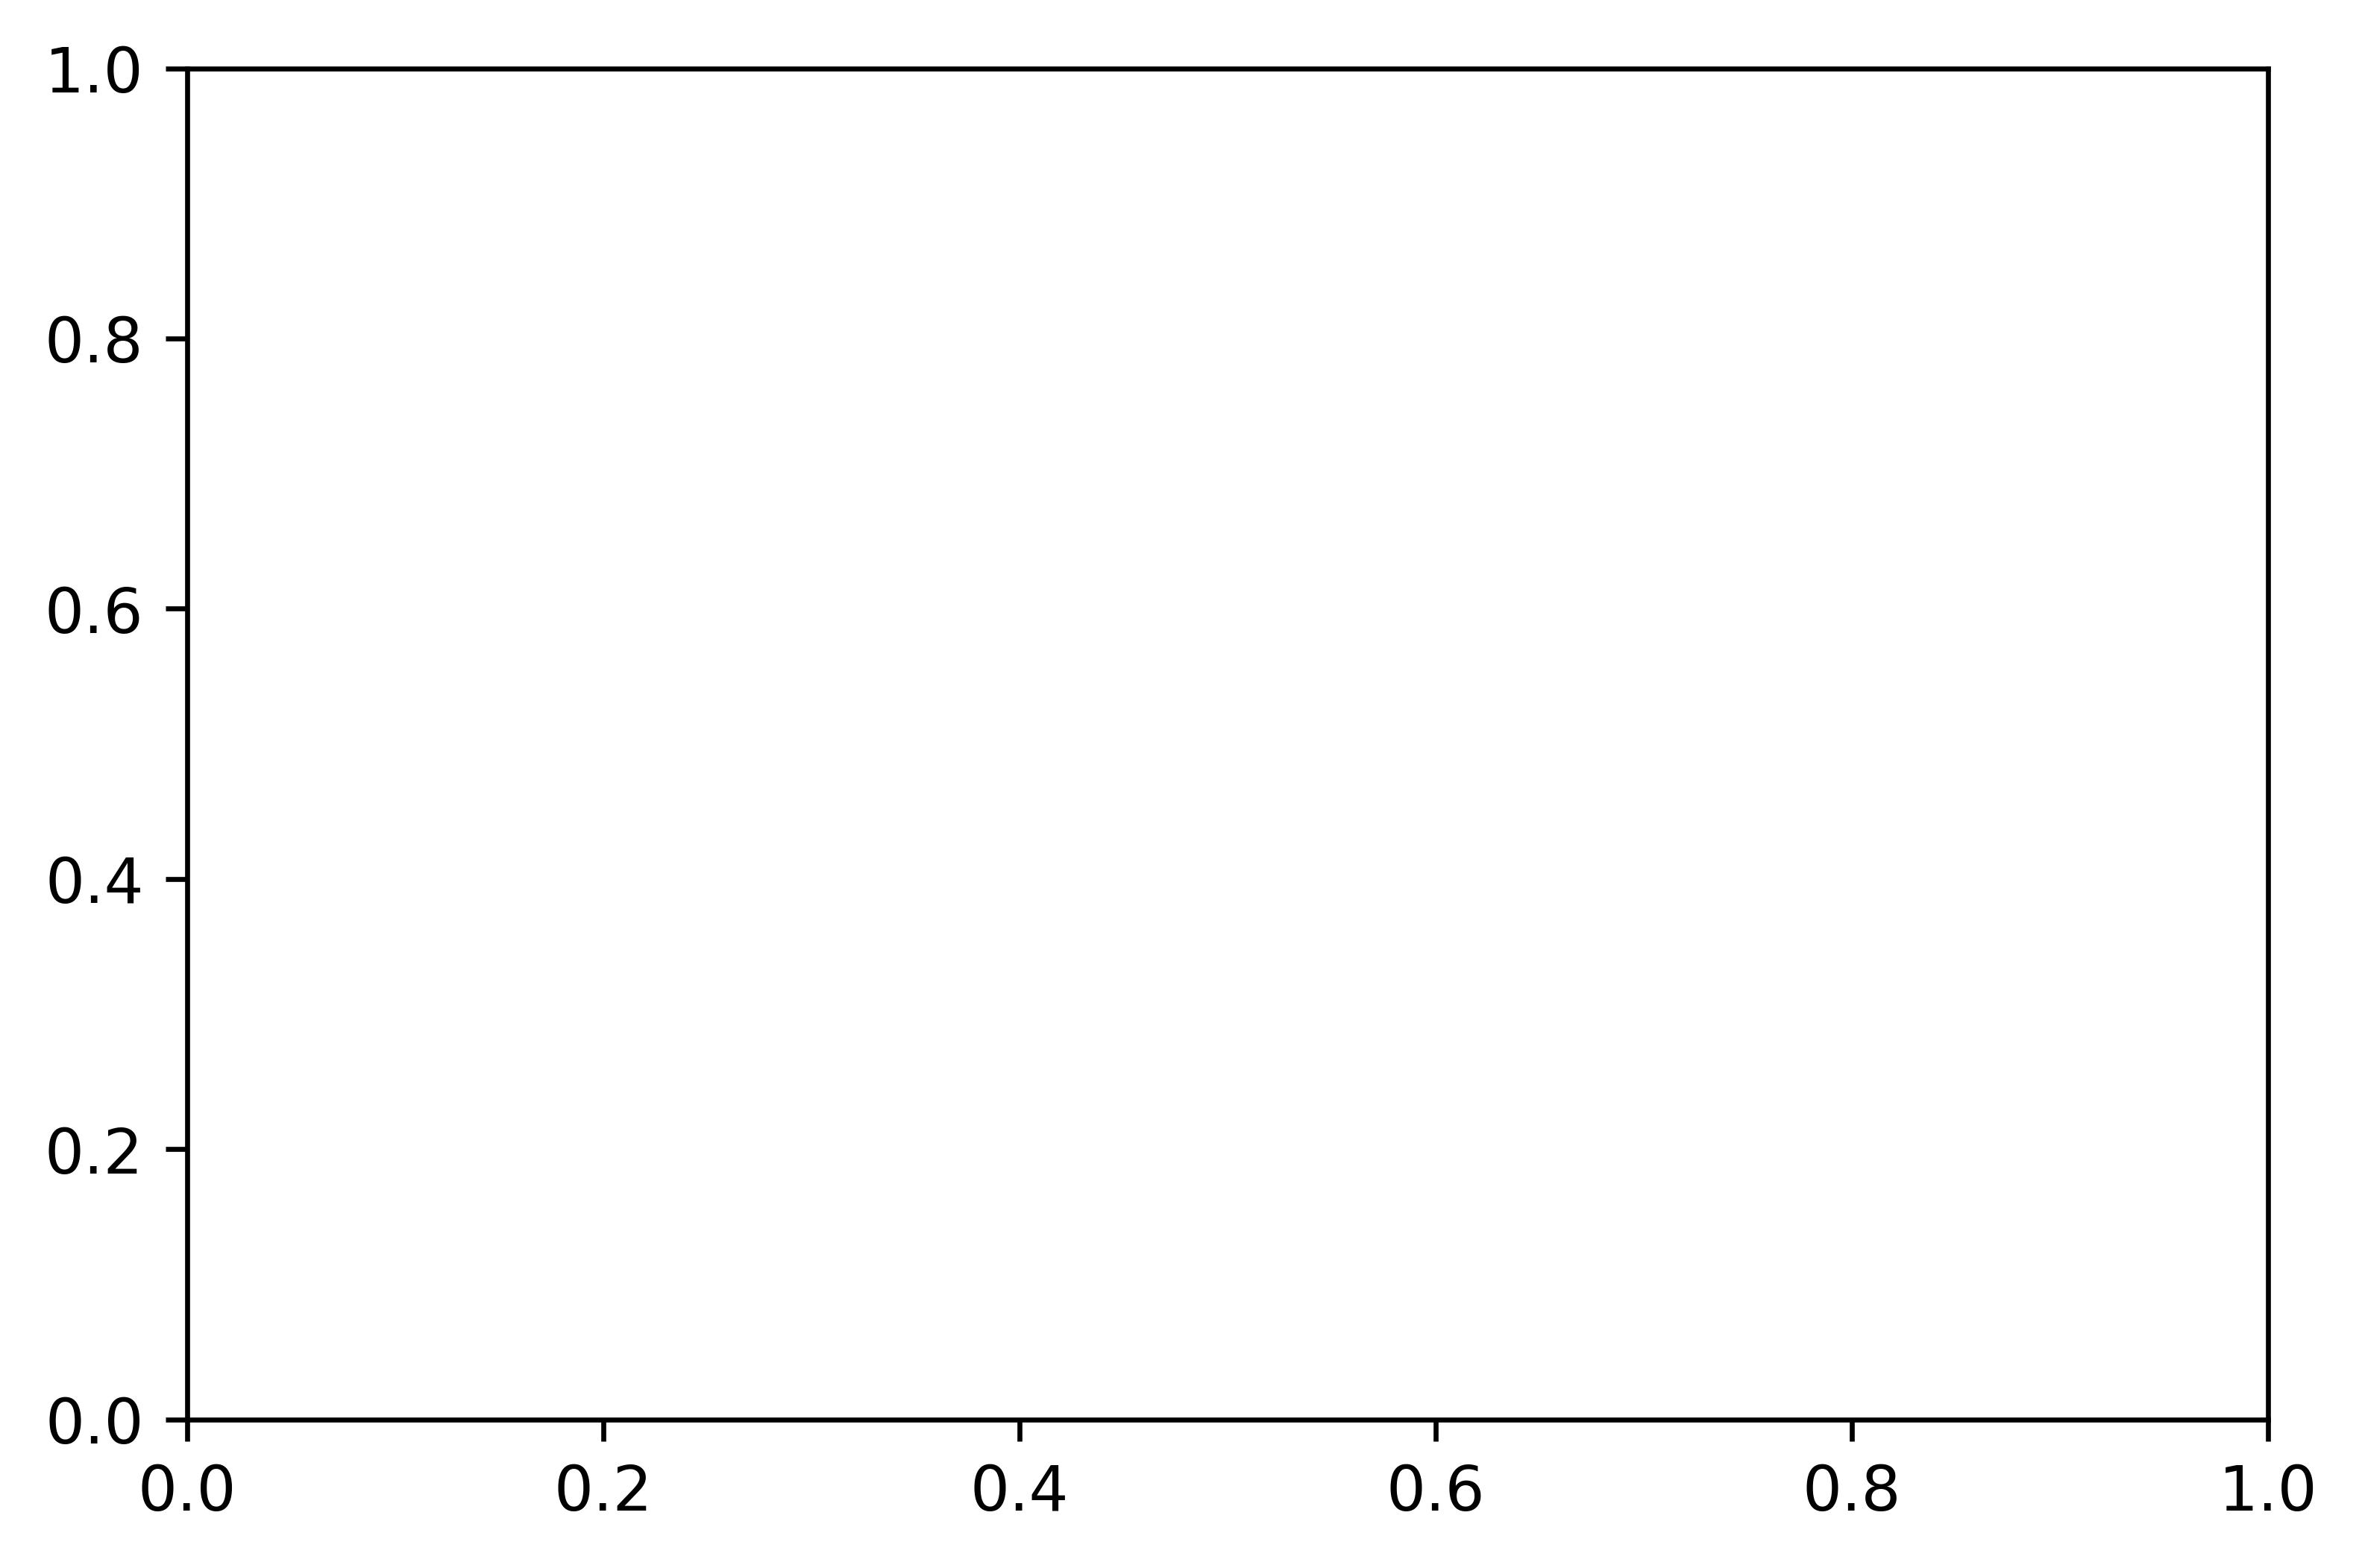

In [8]:
fig, ax = plt.subplots()
plot_baselines("cooling customOccFalse blindsTrueMultiFalse lightingFalse", ax)

In [ ]:
fig, ax = plt.subplots()
plot_baselines("cooling customOccFalse blindsTrueMultiFalse lightingFalse", ax)

# PMV vs. Power

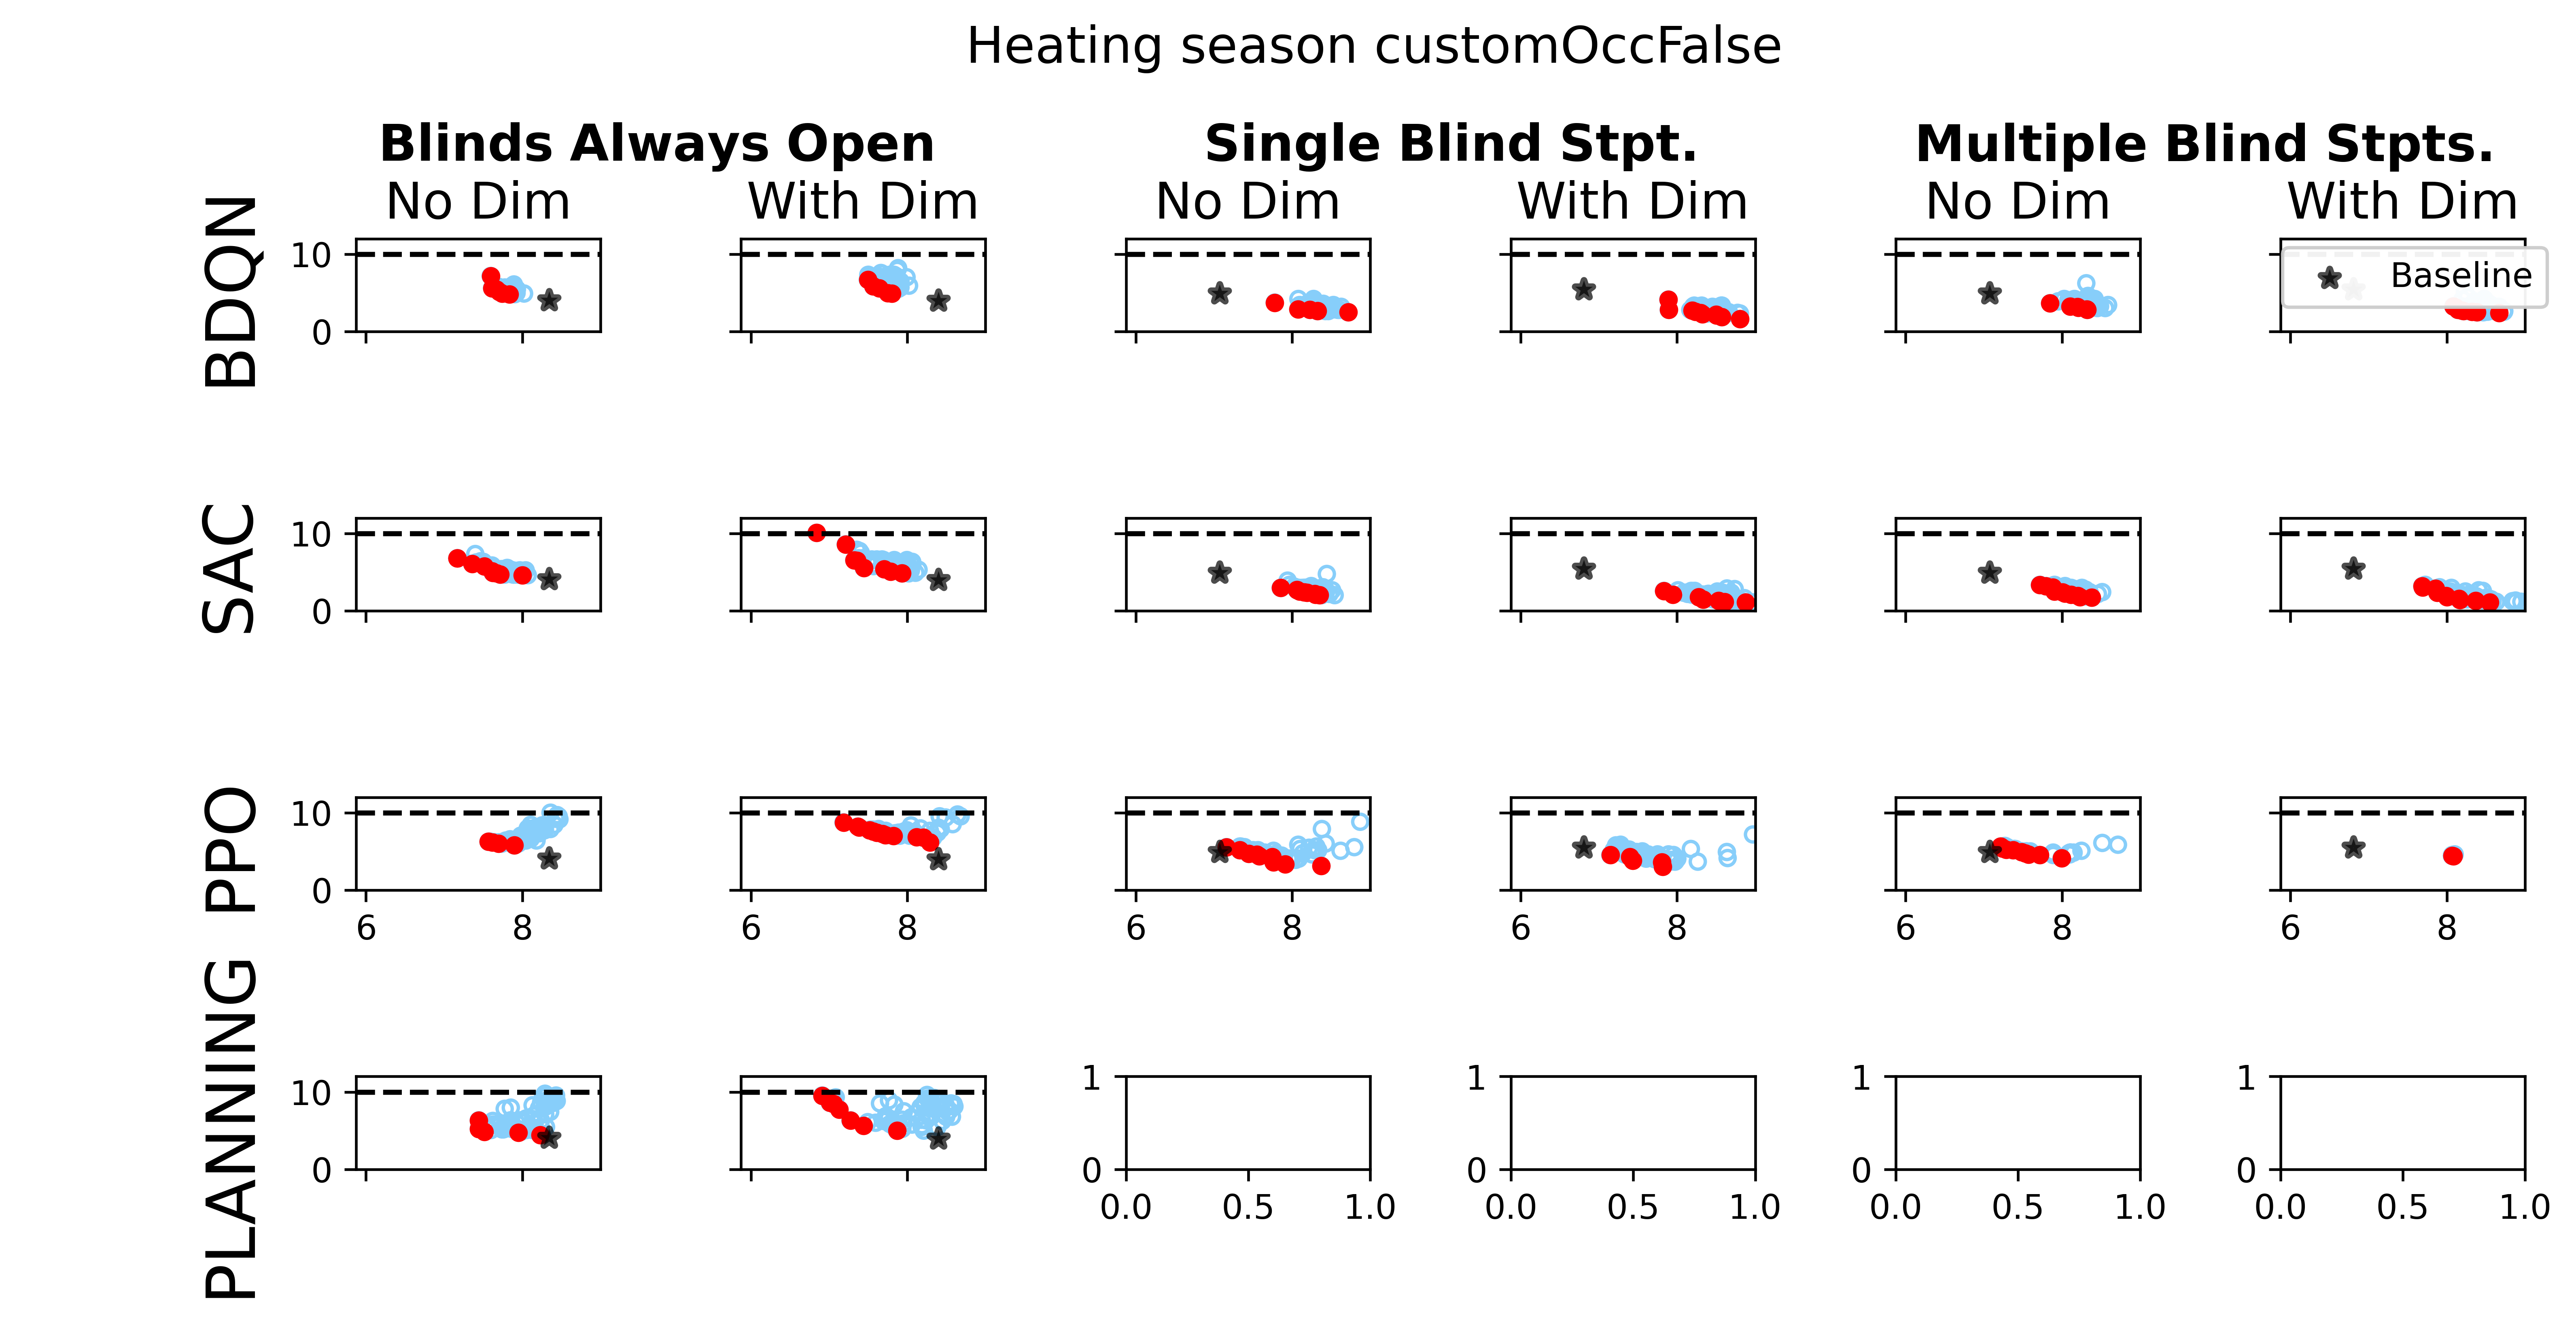

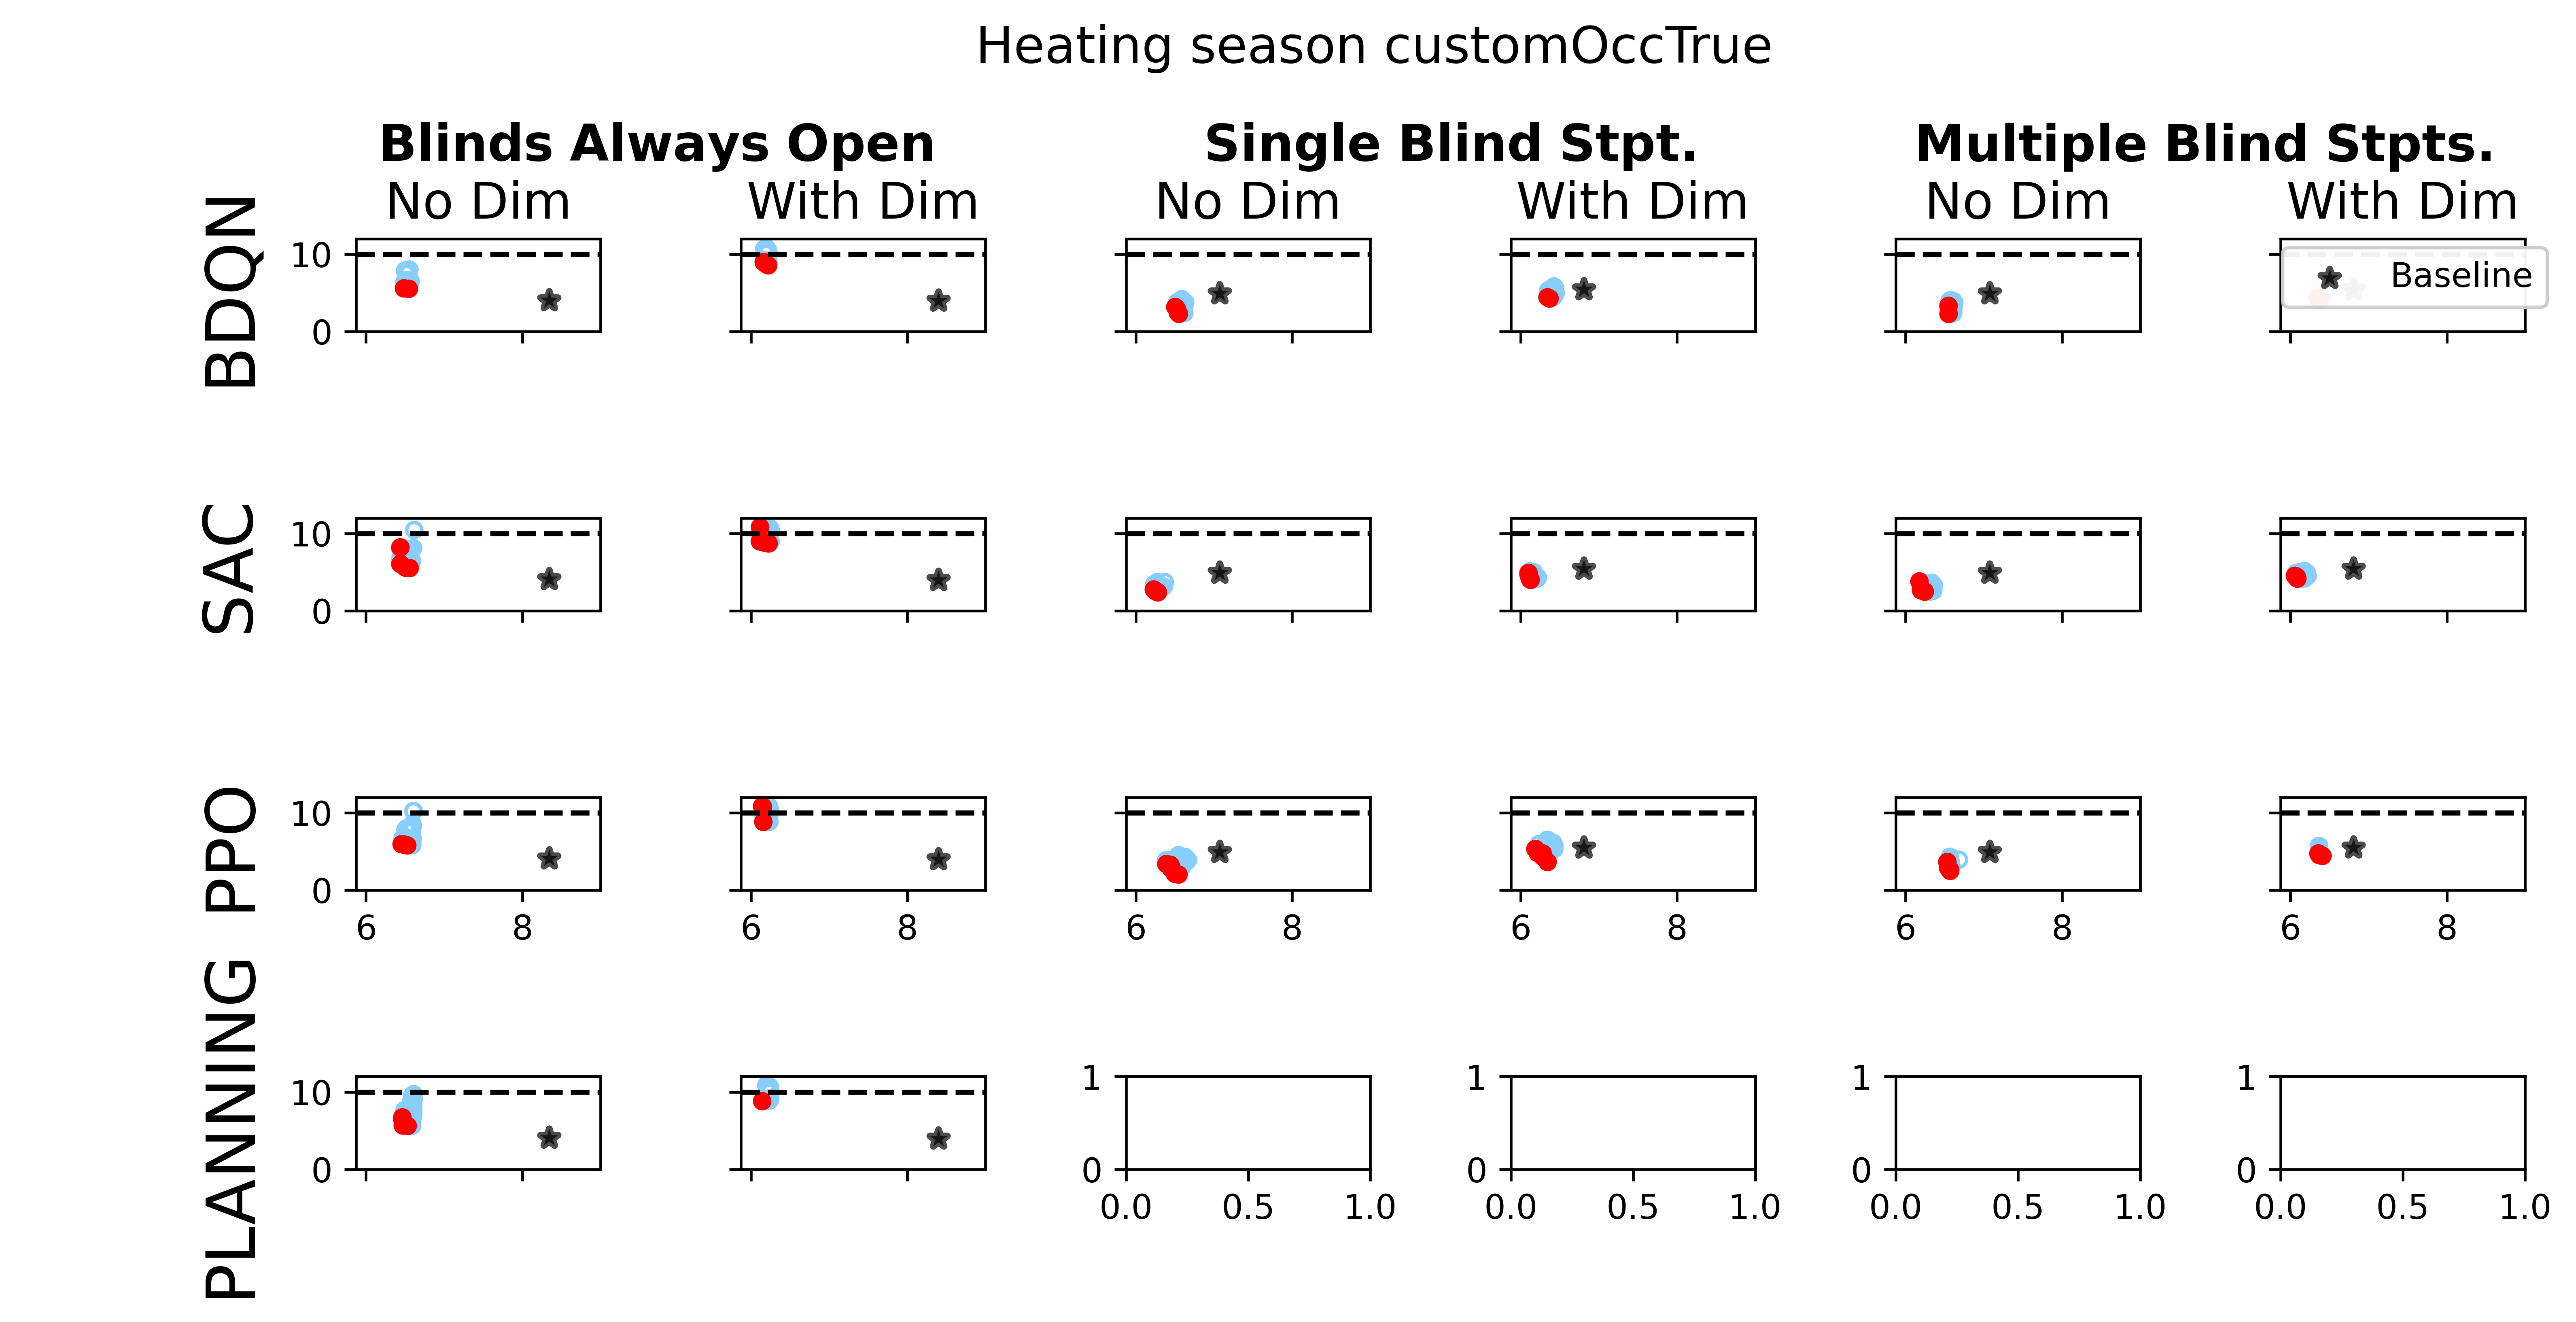

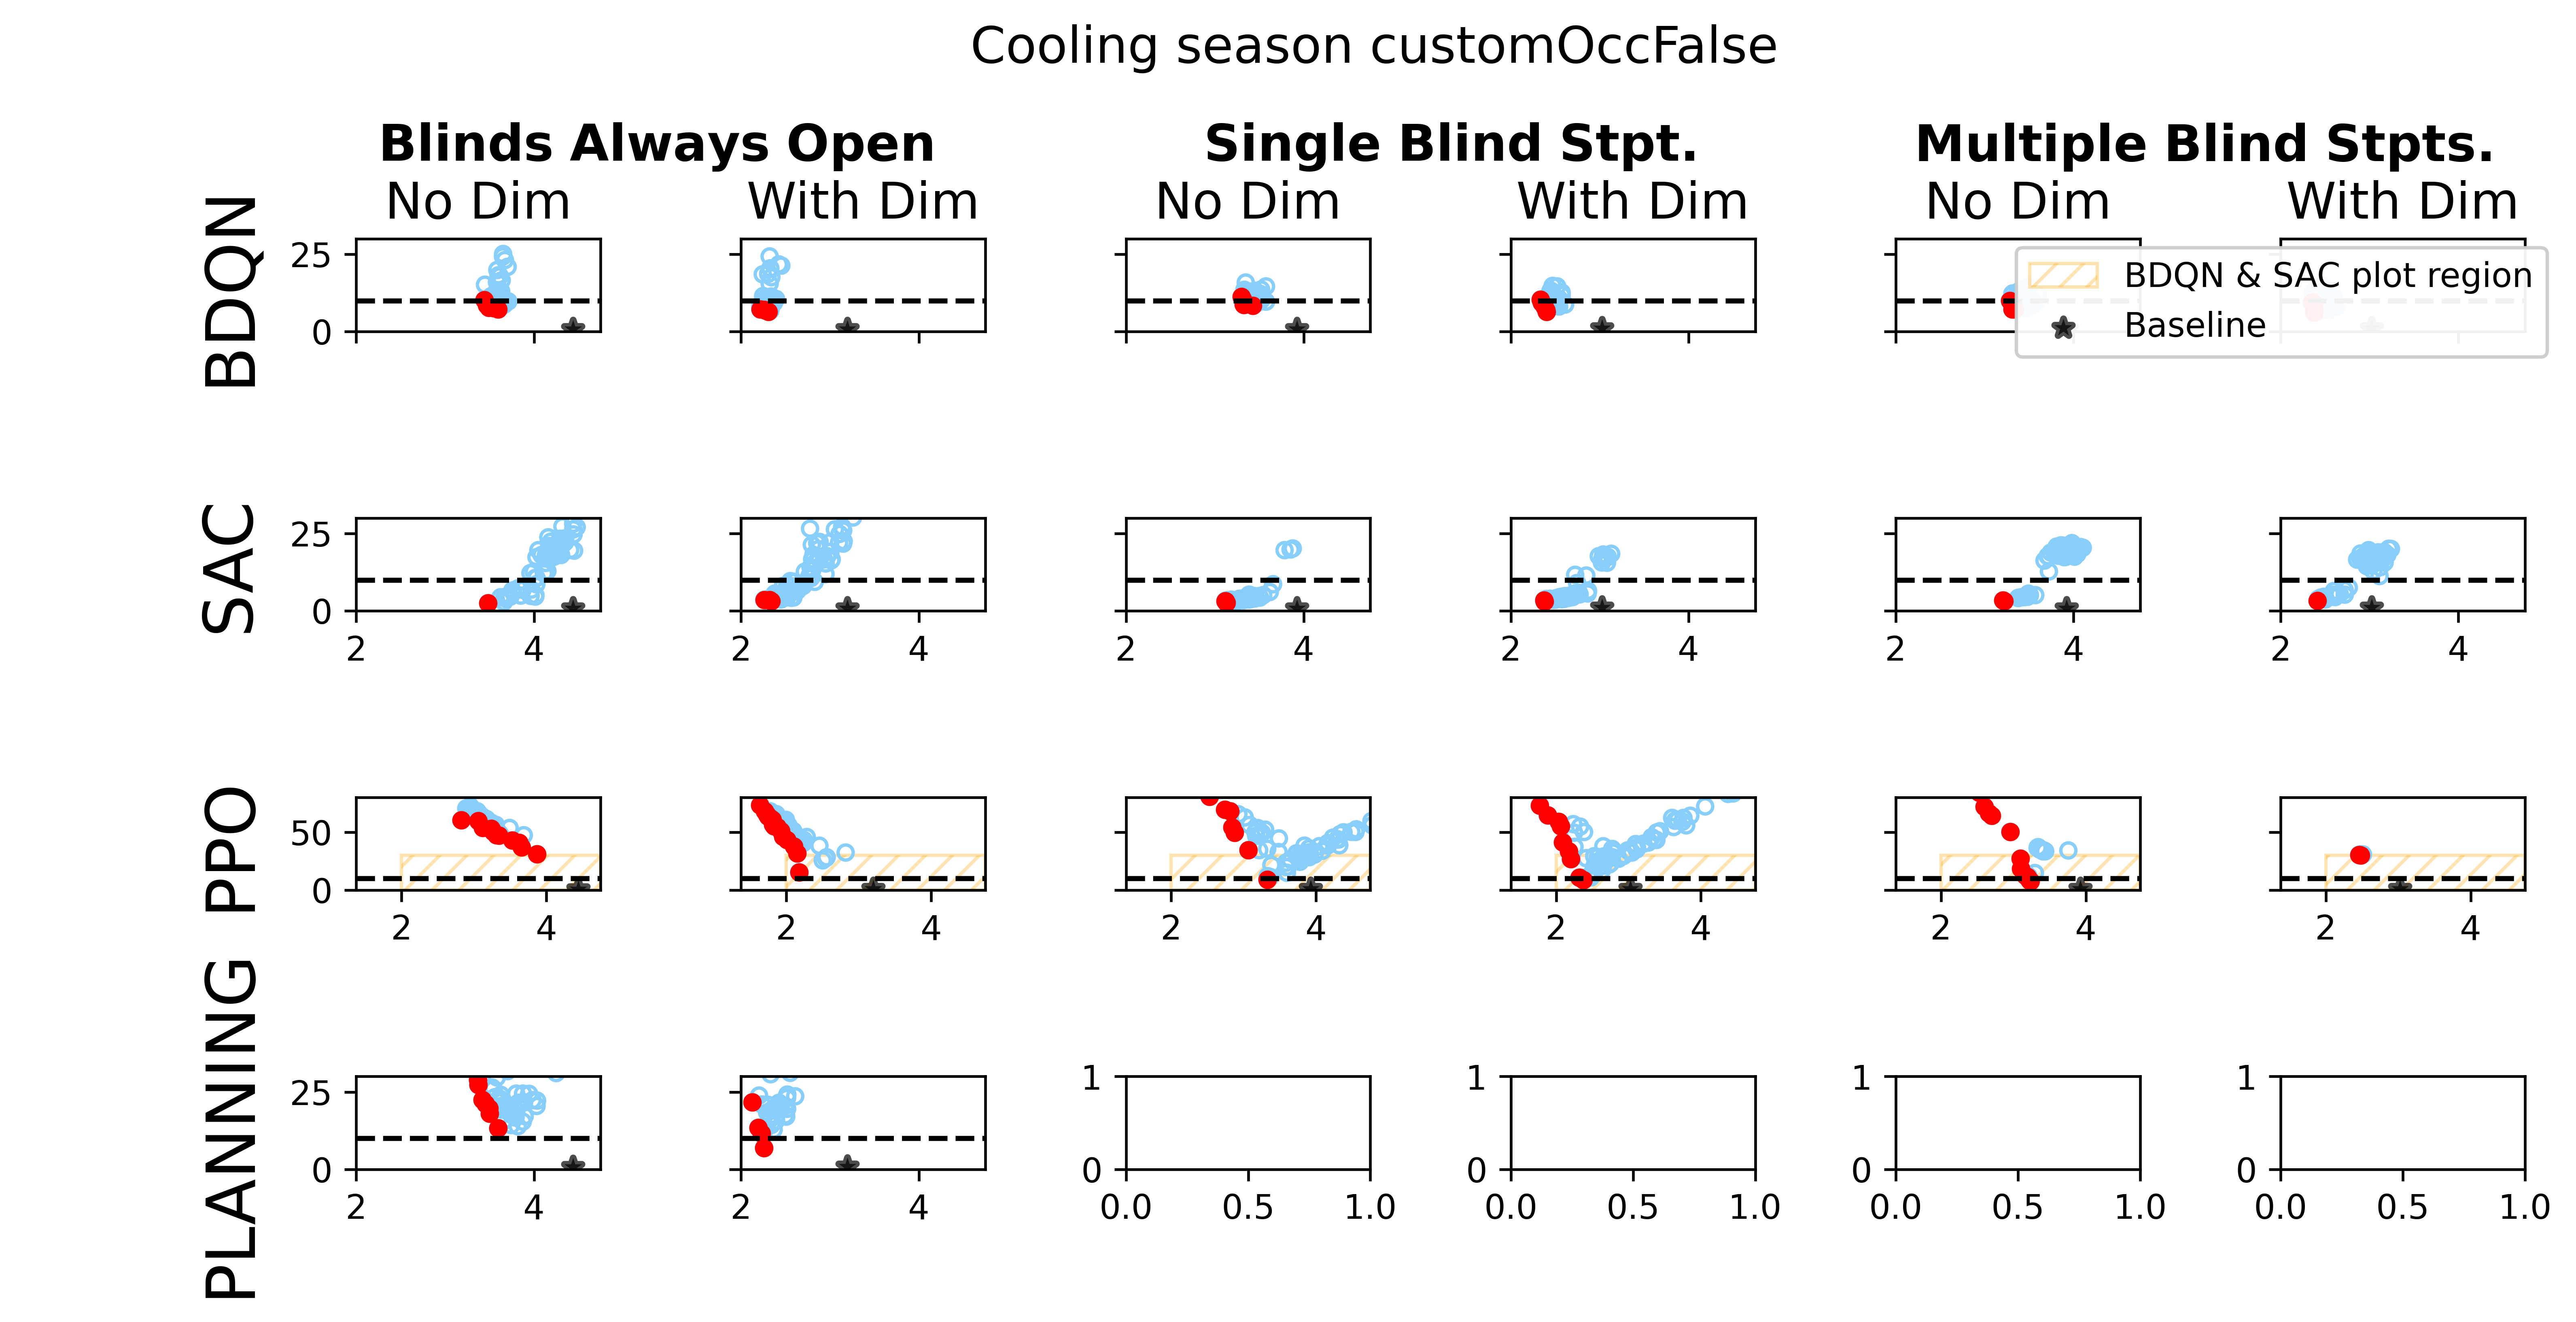

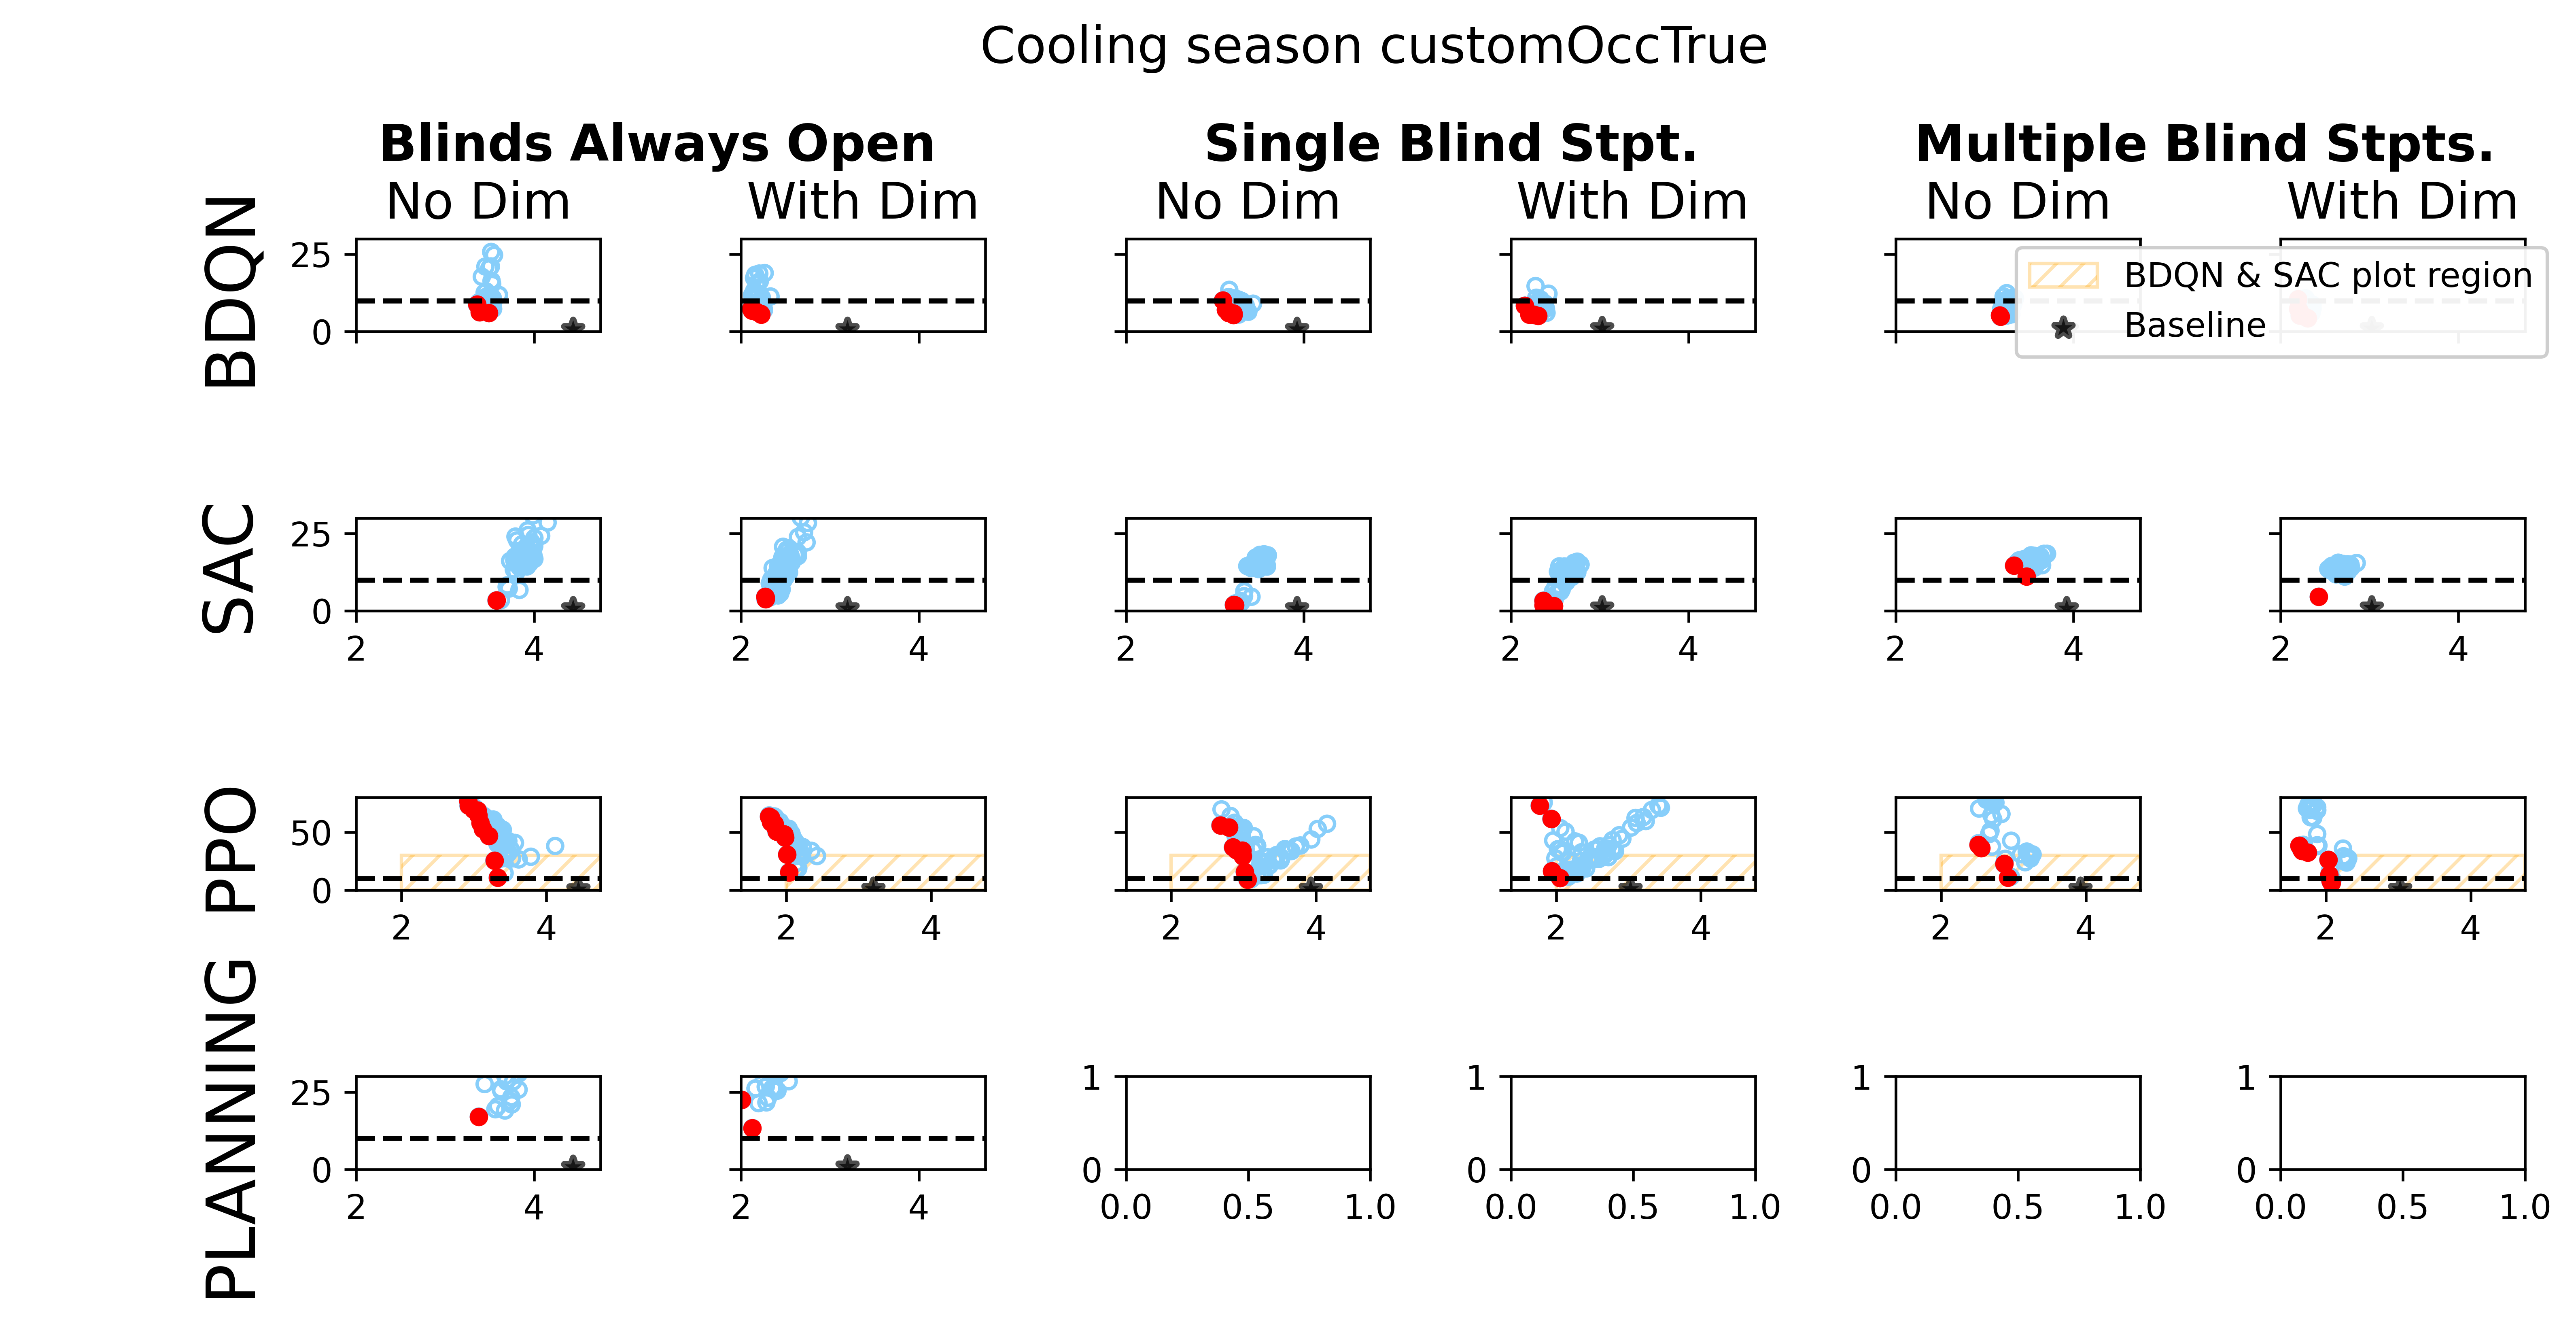

In [20]:
n1 = 'Power'
n2 = 'PMV Violation'
for season in ['heating', 'cooling']:
    for occ in ['customOccFalse', 'customOccTrue']:
        fig, axes = plt.subplots(4, 6, figsize=(10,5), sharex=False, sharey=False)

        all_paretos = {}
        i = 0
        for agent in ['dqn', 'sac', 'ppo', 'planning']:
            agent_paretos = {}
            # Load DataFrame
            df = pd.DataFrame(sheets[agent].get_all_records())
            df.columns = ["Unnamed: 0"] + list(df.columns[1:])
            df["Unnamed: 0"] = df["Unnamed: 0"].replace('', np.nan)
            df = df.fillna(method='ffill')
#             df = pd.read_csv(f'csvs/Result playground - {agent}.csv', index_col=False).fillna(method='ffill')
            df = df.dropna(axis='columns')
#             if agent == 'dqn':
#                 df = df.replace({"Unnamed: 0": dqn_rename})
#             if agent == 'ppo':
#                 df = df.replace({"Unnamed: 0": ppo_rename})
            cases = df['Unnamed: 0'].unique()

            for c in cases:
                info = c.split(' ')

                # Exclude custom occupancy and specify season
                if f'{season} {occ}' in c:
                    plt_case = True

                    # Hardcoding this so we can more easily pick between cases later (ex. should we exclude lighting)
                    if 'blindsFalseMultiFalse lightingFalse' in c:
                        j = 0; title='SAT Setpoint\n                      ' + r'$\bf{Blinds}$ $\bf{Always}$ $\bf{Open}$' + '\nNo Dim'
                    elif 'blindsFalseMultiFalse lightingTrue' in c:
                        j = 1; title='SAT Setpoint\nWith Dim'
                    elif 'blindsTrueMultiFalse lightingFalse' in c:
                        j = 2; title='SAT Setpoint\n                         ' + r'$\bf{Single}$ $\bf{Blind}$ $\bf{Stpt.}$' + '\nNo Dim'
                    elif 'blindsTrueMultiFalse lightingTrue' in c:
                        j = 3; title='SAT Setpoint\nWith Dim'
                    elif 'blindsTrueMultiTrue lightingFalse' in c:
                        j = 4; title='SAT Setpoint\n                       ' + r'$\bf{Multiple}$ $\bf{Blind}$ $\bf{Stpts.}$' + '\nNo Dim'
                    elif 'blindsTrueMultiTrue lightingTrue' in c:
                        j = 5; title='SAT Setpoint\nWith Dim'
                    else:
                        plt_case = False

                    if plt_case:
                        plot_paretos(axes[i, j])
                        plot_baselines(c, axes[i, j])
                        axes[i, j].grid(False)
                        axes[i,j].axhline(10, c='black', linestyle='--')
                        if season == 'heating':
                            axes[i,j].set_xlim(23.5 / 4,9)
                            axes[i,j].set_ylim(0,12)
                            if i != 2:
                                axes[i,j].set_xticklabels([])
                            if j != 0:
                                axes[i,j].set_yticklabels([])
                        else:
                            if agent != "ppo":
                                axes[i,j].set_xlim(2, 19 / 4)
                                axes[i,j].set_ylim(0,30)
                            else:
                                axes[i,j].set_xlim(5.5 / 4, 19 / 4)
                                axes[i,j].set_ylim(0,80)
                            if i == 0:
                                axes[i,j].set_xticklabels([])
                            if j != 0:
                                axes[i,j].set_yticklabels([])
                            if i == 2:
                                axes[i,j].add_patch(Rectangle(xy=(2, 0) ,width=19 / 4 - 2, height=30,
                                                              linewidth=1, color='orange', fill=False, zorder=-999,
                                                              hatch='///', fc='orange', alpha=0.3, label="BDQN & SAC plot region"))
                        if i == 0:
                            axes[i,j].set_title(title[13:], fontsize=15)

            axes[i,0].annotate(agent.upper() if agent != "dqn" else "BDQN", fontsize=20, rotation=90,
                                 xy=(0, 0.5), xytext=(-axes[i,0].yaxis.labelpad, 0),
                                 xycoords=axes[i,0].yaxis.label, textcoords='offset points',
                                 ha='right', va='center')
            i += 1
            plt.tight_layout()
        plt.suptitle(f"{season.capitalize()} season {occ}", fontsize=15, y=1.05)
        
#         lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
#         lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        fig.legend(*(axes[2, 0].get_legend_handles_labels()), loc='upper right', bbox_to_anchor=(0.99, 0.88), framealpha=0.95)
#         plt.legend(loc="upper right")
        plt.savefig(f'./plots/rps_single_{season}_{occ}.png')
        plt.show()
#         plt.figure(figsize=(10, 5))
#         plt.imshow(rgb2gray(mpimg.imread(f'./plots/rps_single_{season}_{occ}.png')), cmap="gray")
#             plt.savefig(f'plots/rps_single_{season}_{occ}.png')

# Illuminance vs. Power

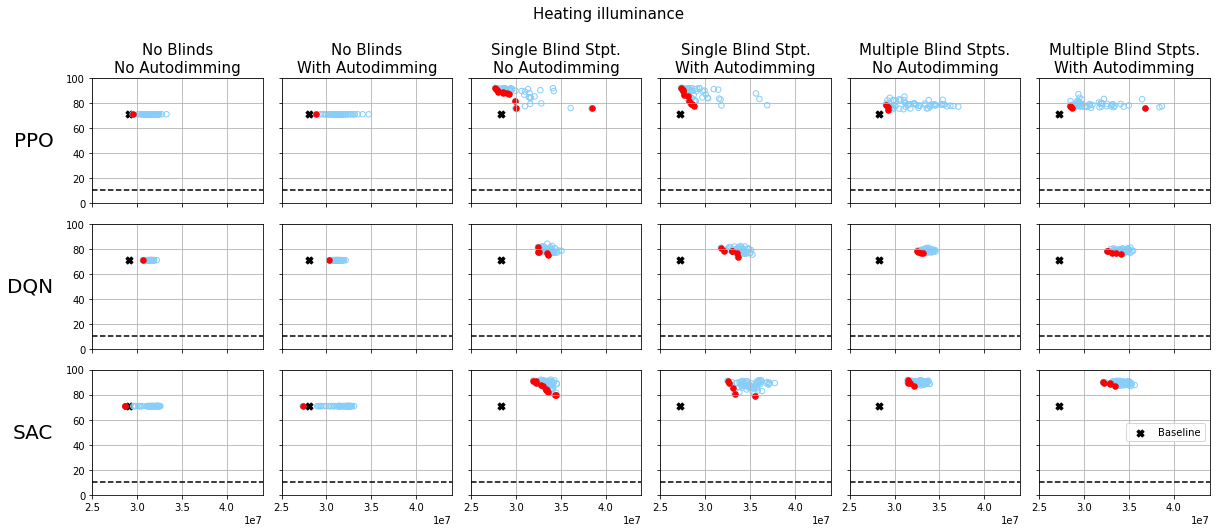

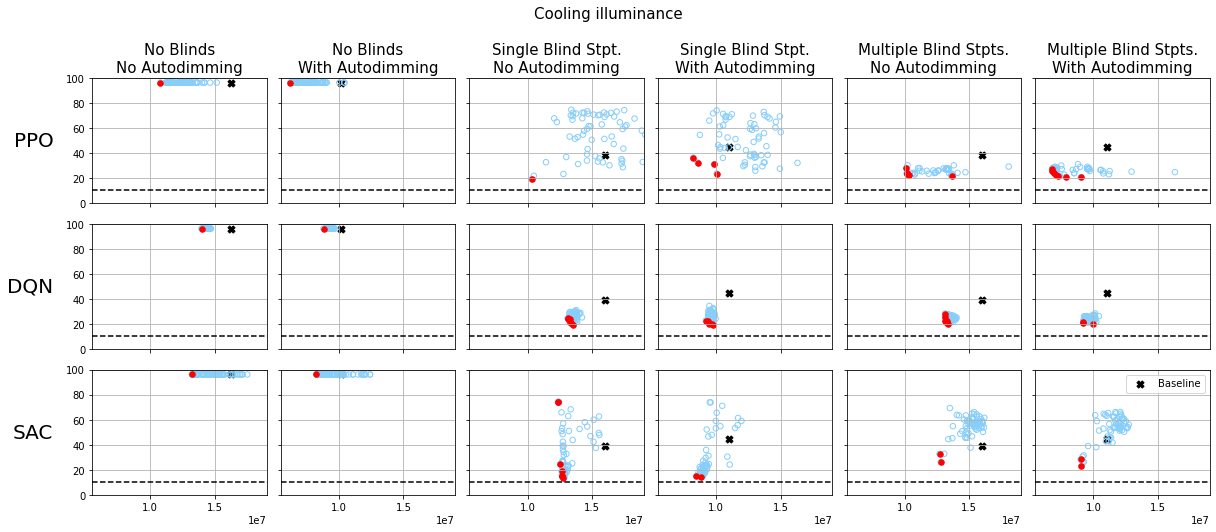

In [31]:
n1 = 'Power'
n2 = 'Illum Violation'

for season in ['heating', 'cooling']:
    fig, axes = plt.subplots(3, 6, figsize=(17,7), sharex=True, sharey=True)

    all_paretos = {}
    i = 0
    for agent in ['ppo', 'dqn', 'sac']:
        agent_paretos = {}
        # Load DataFrame
        df = pd.DataFrame(sheets[agent].get_all_records())
        df.columns = ["Unnamed: 0"] + list(df.columns[1:])
        df["Unnamed: 0"] = df["Unnamed: 0"].replace('', np.nan)
        df = df.fillna(method='ffill')
#         df = pd.read_csv(f'csvs/Result playground - {agent}.csv', index_col=False).fillna(method='ffill')
        df = df.dropna(axis='columns')
        if agent == 'dqn':
            df = df.replace({"Unnamed: 0": dqn_rename})
#         if agent == 'ppo':
#             df = df.replace({"Unnamed: 0": ppo_rename})
        cases = df['Unnamed: 0'].unique()

        for c in cases:
            info = c.split(' ')

            # Exclude custom occupancy and specify season
            if f'{season} customOccFalse' in c:
                plt_case = True
                
                # Hardcoding this so we can more easily pick between cases later (ex. should we exclude lighting)
                if 'blindsFalseMultiFalse lightingFalse' in c:
                    j = 0; title='SAT Setpoint\nNo Blinds\nNo Autodimming'
                elif 'blindsFalseMultiFalse lightingTrue' in c:
                    j = 1; title='SAT Setpoint\nNo Blinds\nWith Autodimming'
                elif 'blindsTrueMultiFalse lightingFalse' in c:
                    j = 2; title='SAT Setpoint\nSingle Blind Stpt.\nNo Autodimming'
                elif 'blindsTrueMultiFalse lightingTrue' in c:
                    j = 3; title='SAT Setpoint\nSingle Blind Stpt.\nWith Autodimming'
                elif 'blindsTrueMultiTrue lightingFalse' in c:
                    j = 4; title='SAT Setpoint\nMultiple Blind Stpts.\nNo Autodimming'
                elif 'blindsTrueMultiTrue lightingTrue' in c:
                    j = 5; title='SAT Setpoint\nMultiple Blind Stpts.\nWith Autodimming'
                else:
                    plt_case = False
            
                if plt_case:
                    plot_baselines(c, agent, axes[i, j])
                    plot_paretos(axes[i, j])
                    axes[i,j].axhline(10, c='black', linestyle='--')
                    if season == 'heating':
                        axes[i,j].set_xlim(2.5e7,4.4e7)
                        axes[i,j].set_ylim(0,100)
                    else:
                        axes[i,j].set_xlim(5.5e6, 1.9e7)
                        axes[i,j].set_ylim(0,100)
                    if i == 0:
                        axes[i,j].set_title(title[13:], fontsize=15)
        
        axes[i,0].annotate(agent.upper(), fontsize=20, rotation=0,
                             xy=(0, 0.5), xytext=(-axes[i,0].yaxis.labelpad - 5, 0),
                             xycoords=axes[i,0].yaxis.label, textcoords='offset points',
                             ha='right', va='center')
        i += 1
        plt.tight_layout()
    plt.suptitle(f"{season.capitalize()} illuminance", fontsize=15, y=1.05)
    plt.legend()
    plt.savefig(f'plots/rps_single_illum_power_{season}.png')
    plt.show()
#         plt.figure(figsize=(17, 7))
#         plt.imshow(rgb2gray(mpimg.imread(f'./plots/rps_single_{season}_{occ}.png')), cmap="gray")

# Choose best set of reward params

In [8]:
# blinds, daylighting, setpoint
heating_baselines = [
    ('heating', 'None', False, 0),
    ('heating', 'None', True, 0),
    ('heating', 'All', False, 90),
    ('heating', 'All', True, 90), 
]
cooling_baselines = [
    ('cooling', 'None', False, 0),
    ('cooling', 'None', True, 0),
    # chosen to minimize visual comfort violation
    ('cooling', 'All', False, 90),
    ('cooling', 'All', True, 90)       
]



def get_pareto_powers(x_agent, y_agent):
    scores = np.stack((x_agent, y_agent), axis=1) #.reshape(-1)
    scores = np.delete(scores, np.where(scores[:,0] <= 0), axis=0)
    # Pareto Front
    pareto = identify_pareto(scores)
    pareto_front = scores[pareto]

    pareto_front_df = pd.DataFrame(pareto_front)
    pareto_front_df.sort_values(0, inplace=True)
    pareto_front = pareto_front_df.values
    x_pareto = pareto_front[:, 0]
    y_pareto = pareto_front[:, 1]

    agent_paretos[c] = get_rps_on_pareto(x_pareto, y_pareto)
    
    return x_pareto, y_pareto
    


        
        # todo, decided how to select reward params here
#         powers_illum, illum_best = get_pareto_powers(powers, illums)
#         powers_pmv, pmv_best = get_pareto_powers(powers, pmvs)
        
#         illum_min_idx = np.argmin(powers_illum)
#         pmv_min_idx = np.argmin(powers_pmv)
        
#         best_idx = powers_illum == powers_pmv
#         powers = powers_pmv[best_idx]
#         pdb.set_trace()
#         assert powers_illum[illum_min_idx] == powers_illum[pmv_min_idx]
#         return powers_illum[illum_min_idx]
#         print(powers_illum[])
#         print(pmv_best)
        
#         print(powers.min())
    
    

def add_dict_list(dct, key, val):
    l = dct.get(key, [])
    l.append(val)
    dct[key] = l
    return dct

def pdiff(x1, x2):
    x1 = np.array(x1) 
    x2 = np.array(x2) 
    x3 = x1.copy()
    x3[x3 == 0] = 1 # handle divide by 0
    return ((x2 - x1) / x3) * 100



## 1. Heating Season

In heating season, agents were able to find strategies that were below the uppoer bound for violation rate, and was not a major difference in the illumination violation rate when compared to baseline. Therefore, the best strategies are chosen based only on minimizing total power use.

[('cooling', 'None', False, 0), ('cooling', 'None', True, 0), ('cooling', 'All', False, 90), ('cooling', 'All', True, 90)]
4.440875411461595 0.22056245401431956 0.78125 1995.5772243683125 96.328125
3.19747133841825 0.27569388538982337 0.8593750000000001 1995.5772243683125 96.328125
3.9232756215700495 0.27259102582864403 0.8593750000000001 359.67445340321086 37.109375
3.0247039835791654 0.3150468167721874 1.015625 359.67445340321086 37.109375
planning | cooling | Blinds Always Open
No Autodimming |   1.45 |  25.84 |  86.55 |   0.51 | 1538.87
planning | cooling | Single Blind Stpt.
No Autodimming |   1.45 |  25.84 |  86.55 |   0.51 | 1538.87
planning | cooling | Multiple Blind Stpts.
No Autodimming |   1.45 |  25.84 |  86.55 |   0.51 | 1538.87
planning | cooling | Blinds Always Open
With Autodimming |   0.88 |  28.04 |  86.55 |   0.62 | 1538.87
planning | cooling | Single Blind Stpt.
With Autodimming |   0.88 |  28.04 |  86.55 |   0.62 | 1538.87
planning | cooling | Multiple Blind Stpts.

No handles with labels found to put in legend.


ppo | cooling | Blinds Always Open
No Autodimming |   1.33 |  10.64 |  86.55 |   0.32 | 1538.87
ppo | cooling | Blinds Always Open
With Autodimming |   0.81 |  15.46 |  86.55 |   0.39 | 1538.87
ppo | cooling | Single Blind Stpt.
No Autodimming |   1.22 |   8.93 |   5.51 |   0.49 | 571.92
ppo | cooling | Single Blind Stpt.
With Autodimming |   0.82 |  10.61 |   7.77 |   0.34 | 606.34
ppo | cooling | Multiple Blind Stpts.
No Autodimming |   1.17 |  10.80 |   4.32 |   0.31 | 588.84
ppo | cooling | Multiple Blind Stpts.
With Autodimming |   0.82 |   8.04 |   2.67 |   0.59 | 559.61


No handles with labels found to put in legend.
No handles with labels found to put in legend.


[('heating', 'None', False, 0), ('heating', 'None', True, 0), ('heating', 'All', False, 90), ('heating', 'All', True, 90)]
8.343361024742007 0.2547578608495723 4.0625 1190.7206647469593 70.15625
8.39865458896566 0.27978204729539563 3.9843749999999996 1190.7206647469593 70.15625
7.074837877063394 0.2801338449546772 4.921875 1190.7206647469593 70.15625
6.80618423906461 0.3156600214503418 5.46875 1190.7206647469593 70.15625
planning | heating | Blinds Always Open
No Autodimming |   2.58 |   5.98 |  50.28 |   0.32 | 1496.27
planning | heating | Single Blind Stpt.
No Autodimming |   2.58 |   5.98 |  50.28 |   0.32 | 1496.27
planning | heating | Multiple Blind Stpts.
No Autodimming |   2.58 |   5.98 |  50.28 |   0.32 | 1496.27
planning | heating | Blinds Always Open
With Autodimming |   2.45 |  10.61 |  47.89 |   0.37 | 1461.01
planning | heating | Single Blind Stpt.
With Autodimming |   2.45 |  10.61 |  47.89 |   0.37 | 1461.01
planning | heating | Multiple Blind Stpts.
With Autodimming |  

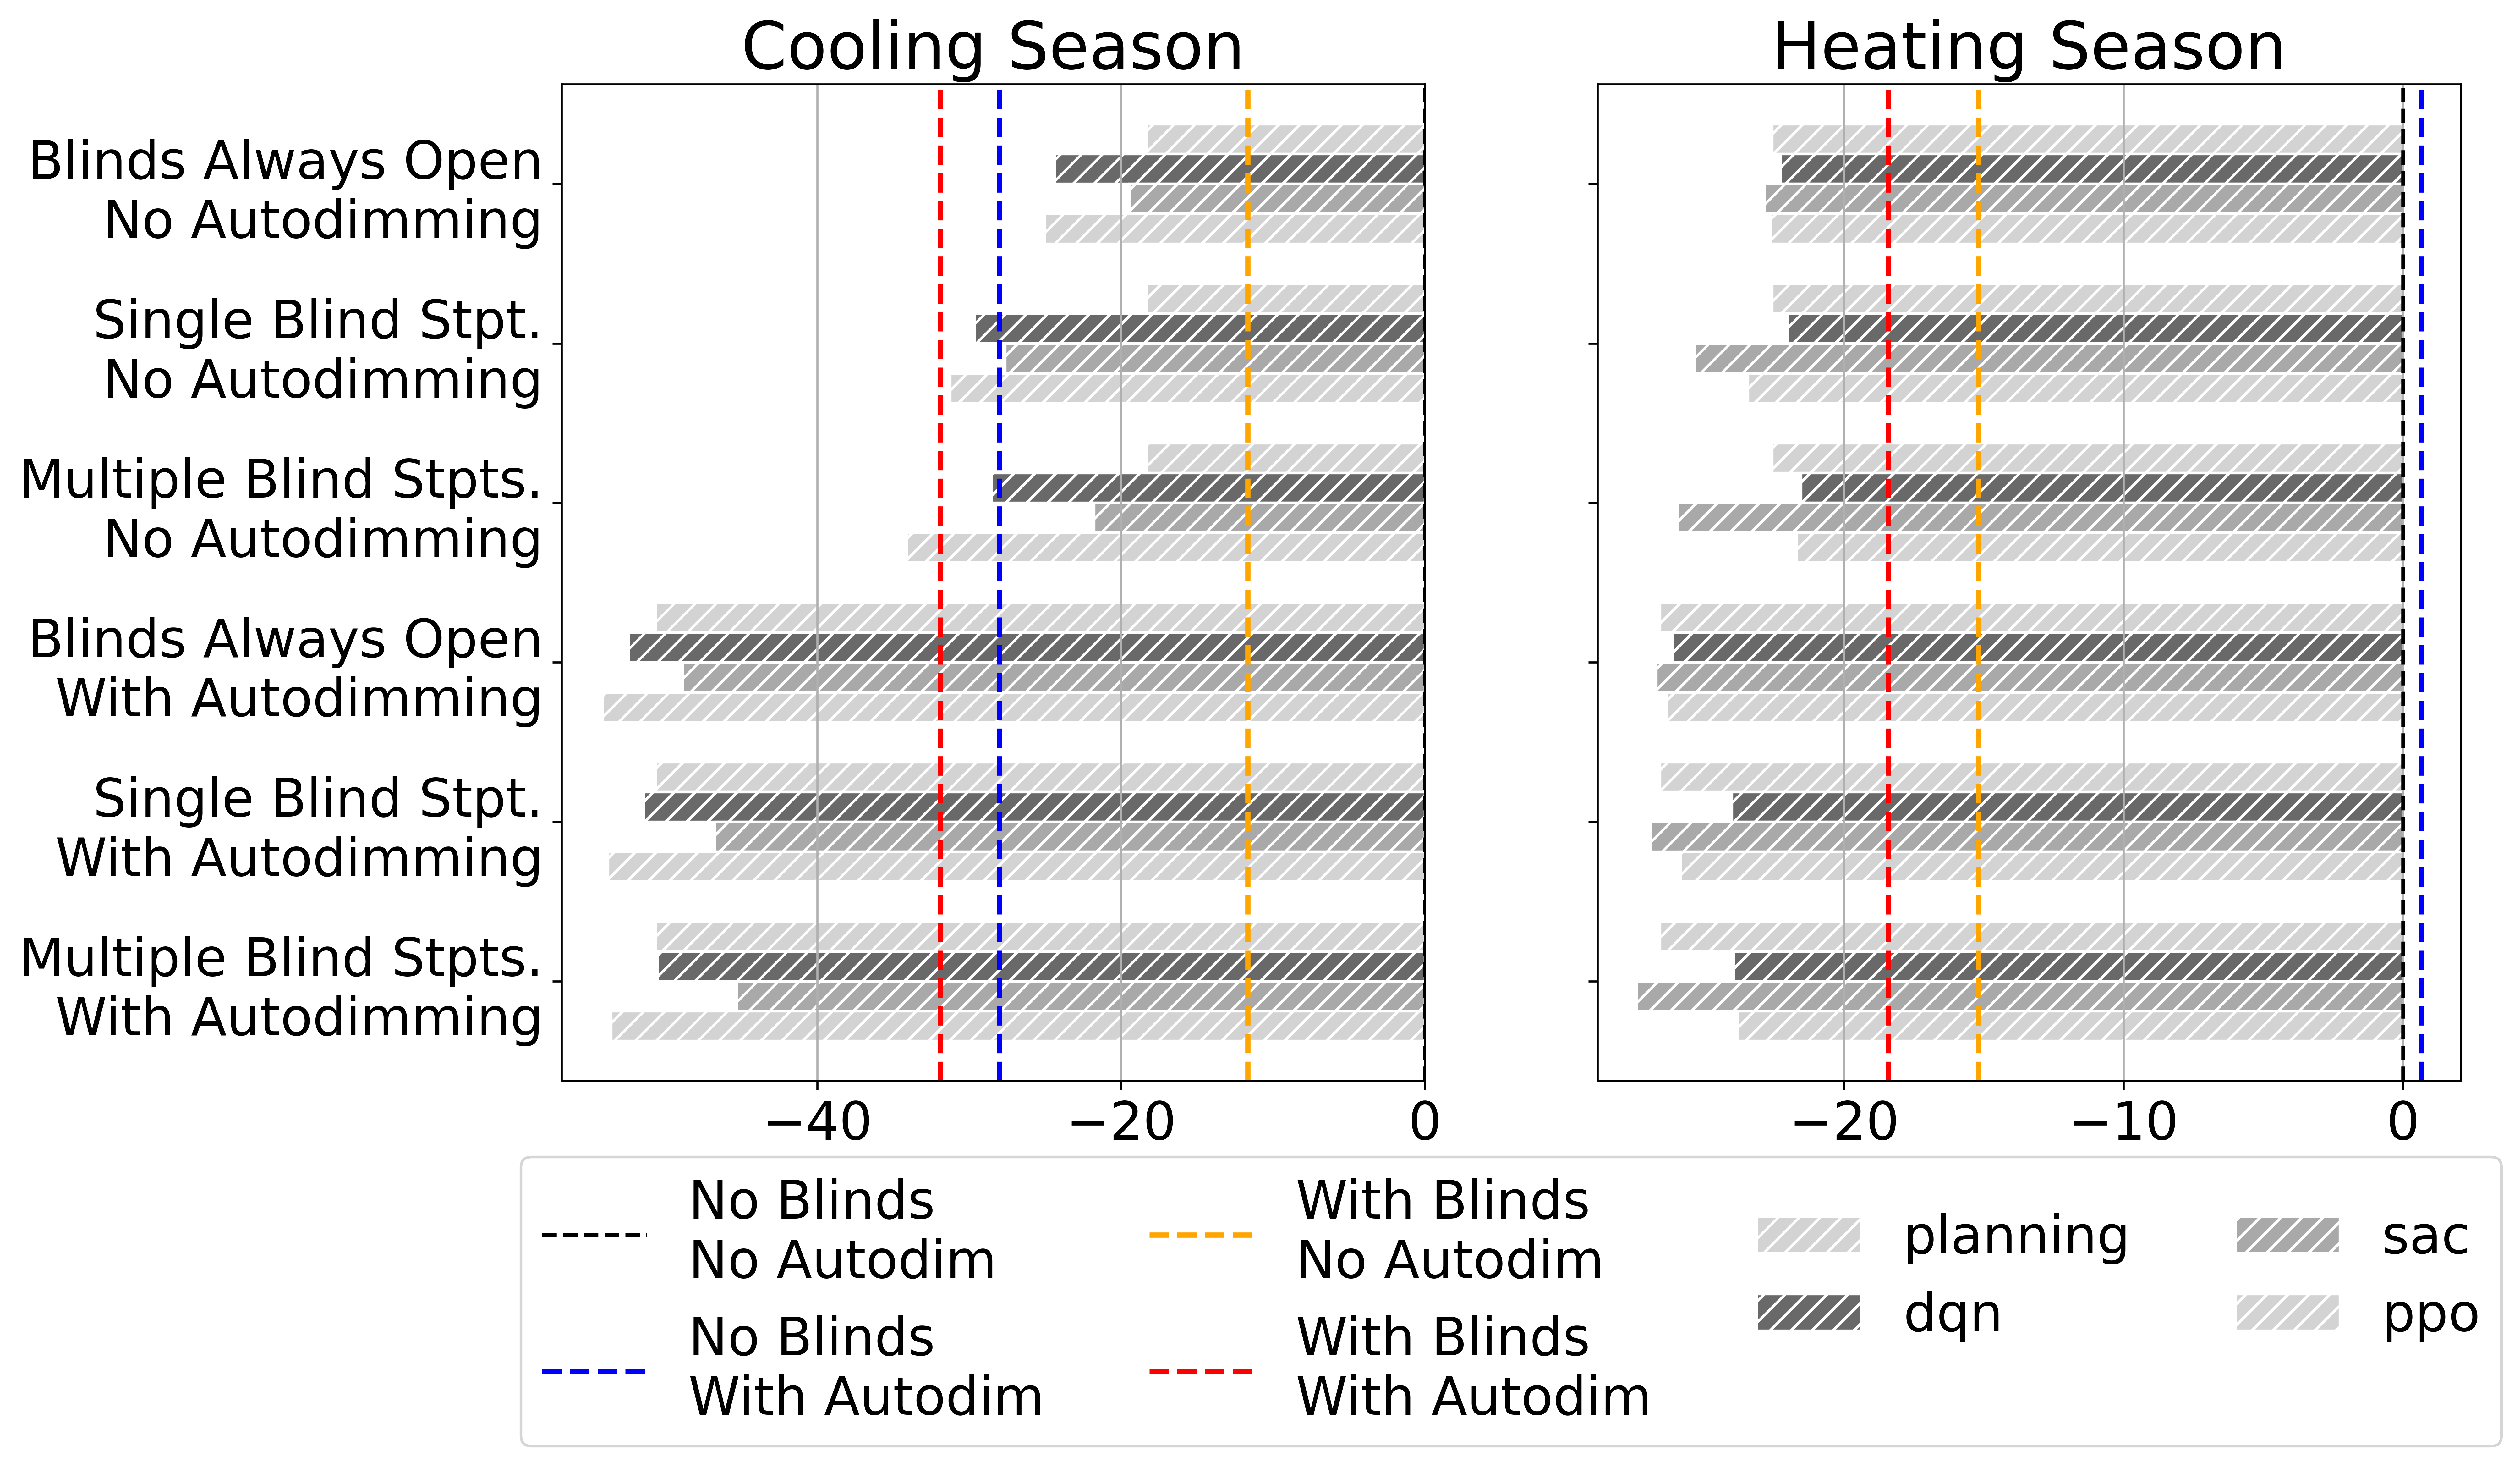

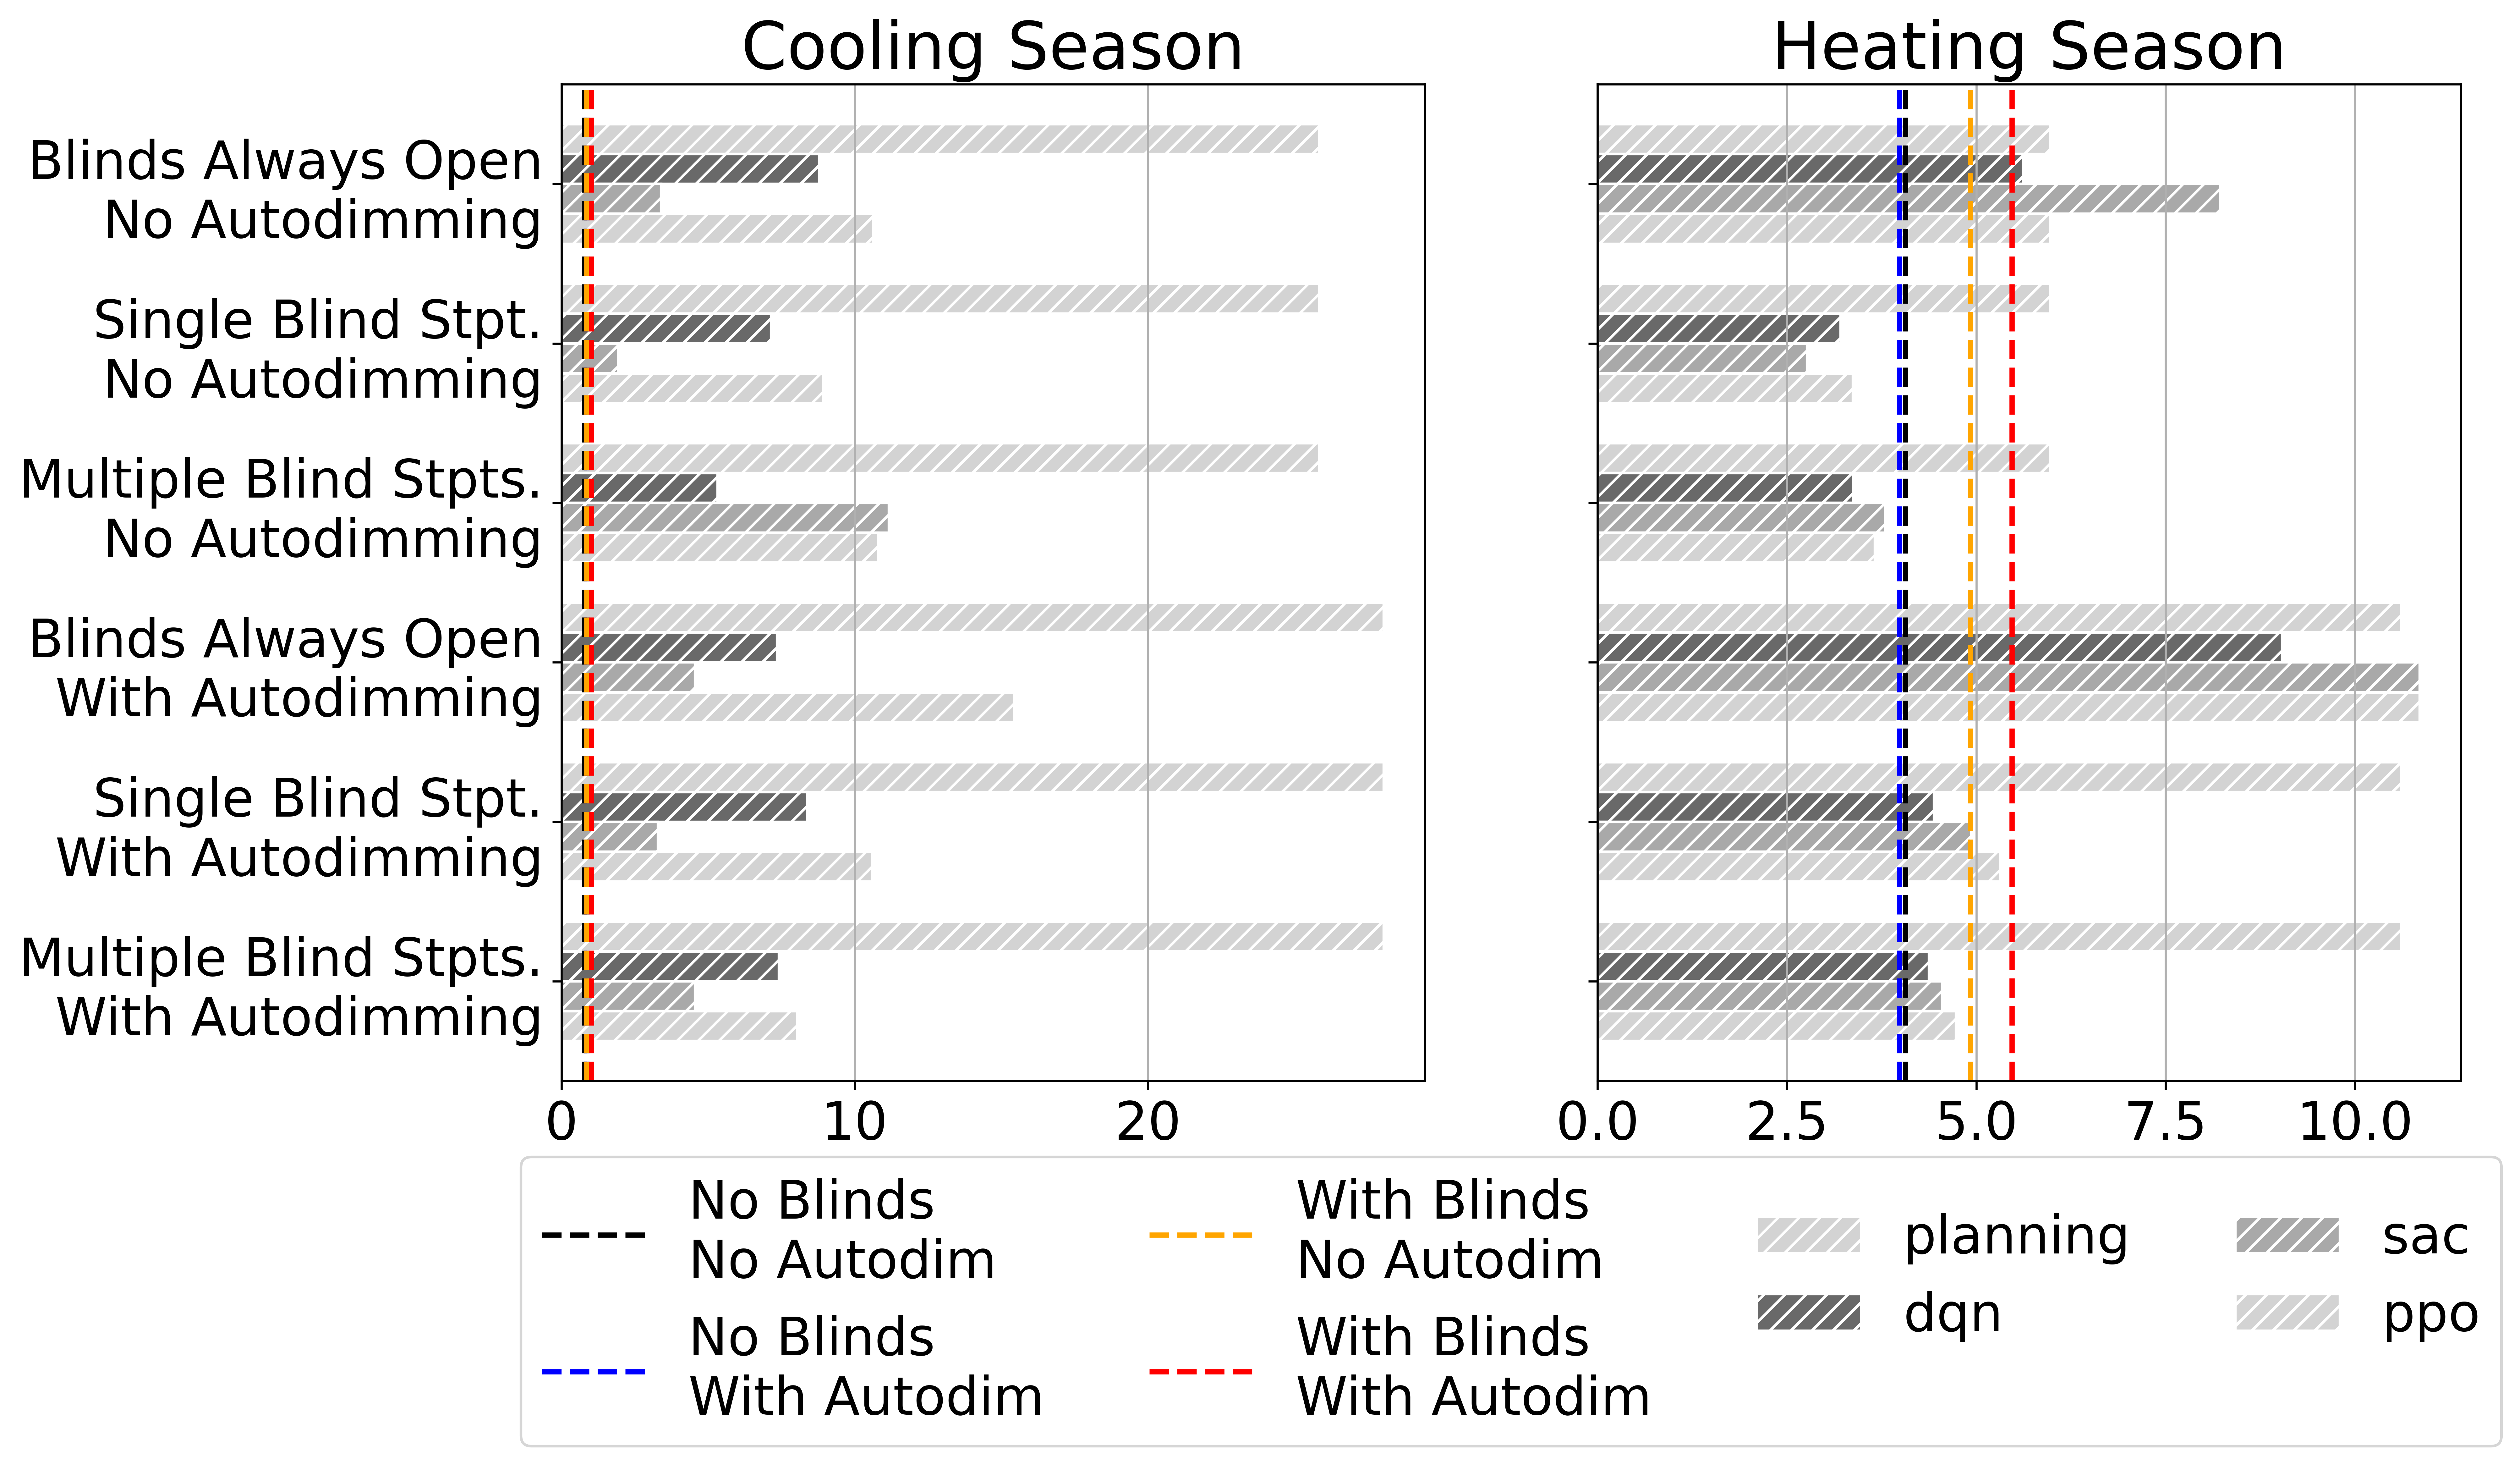

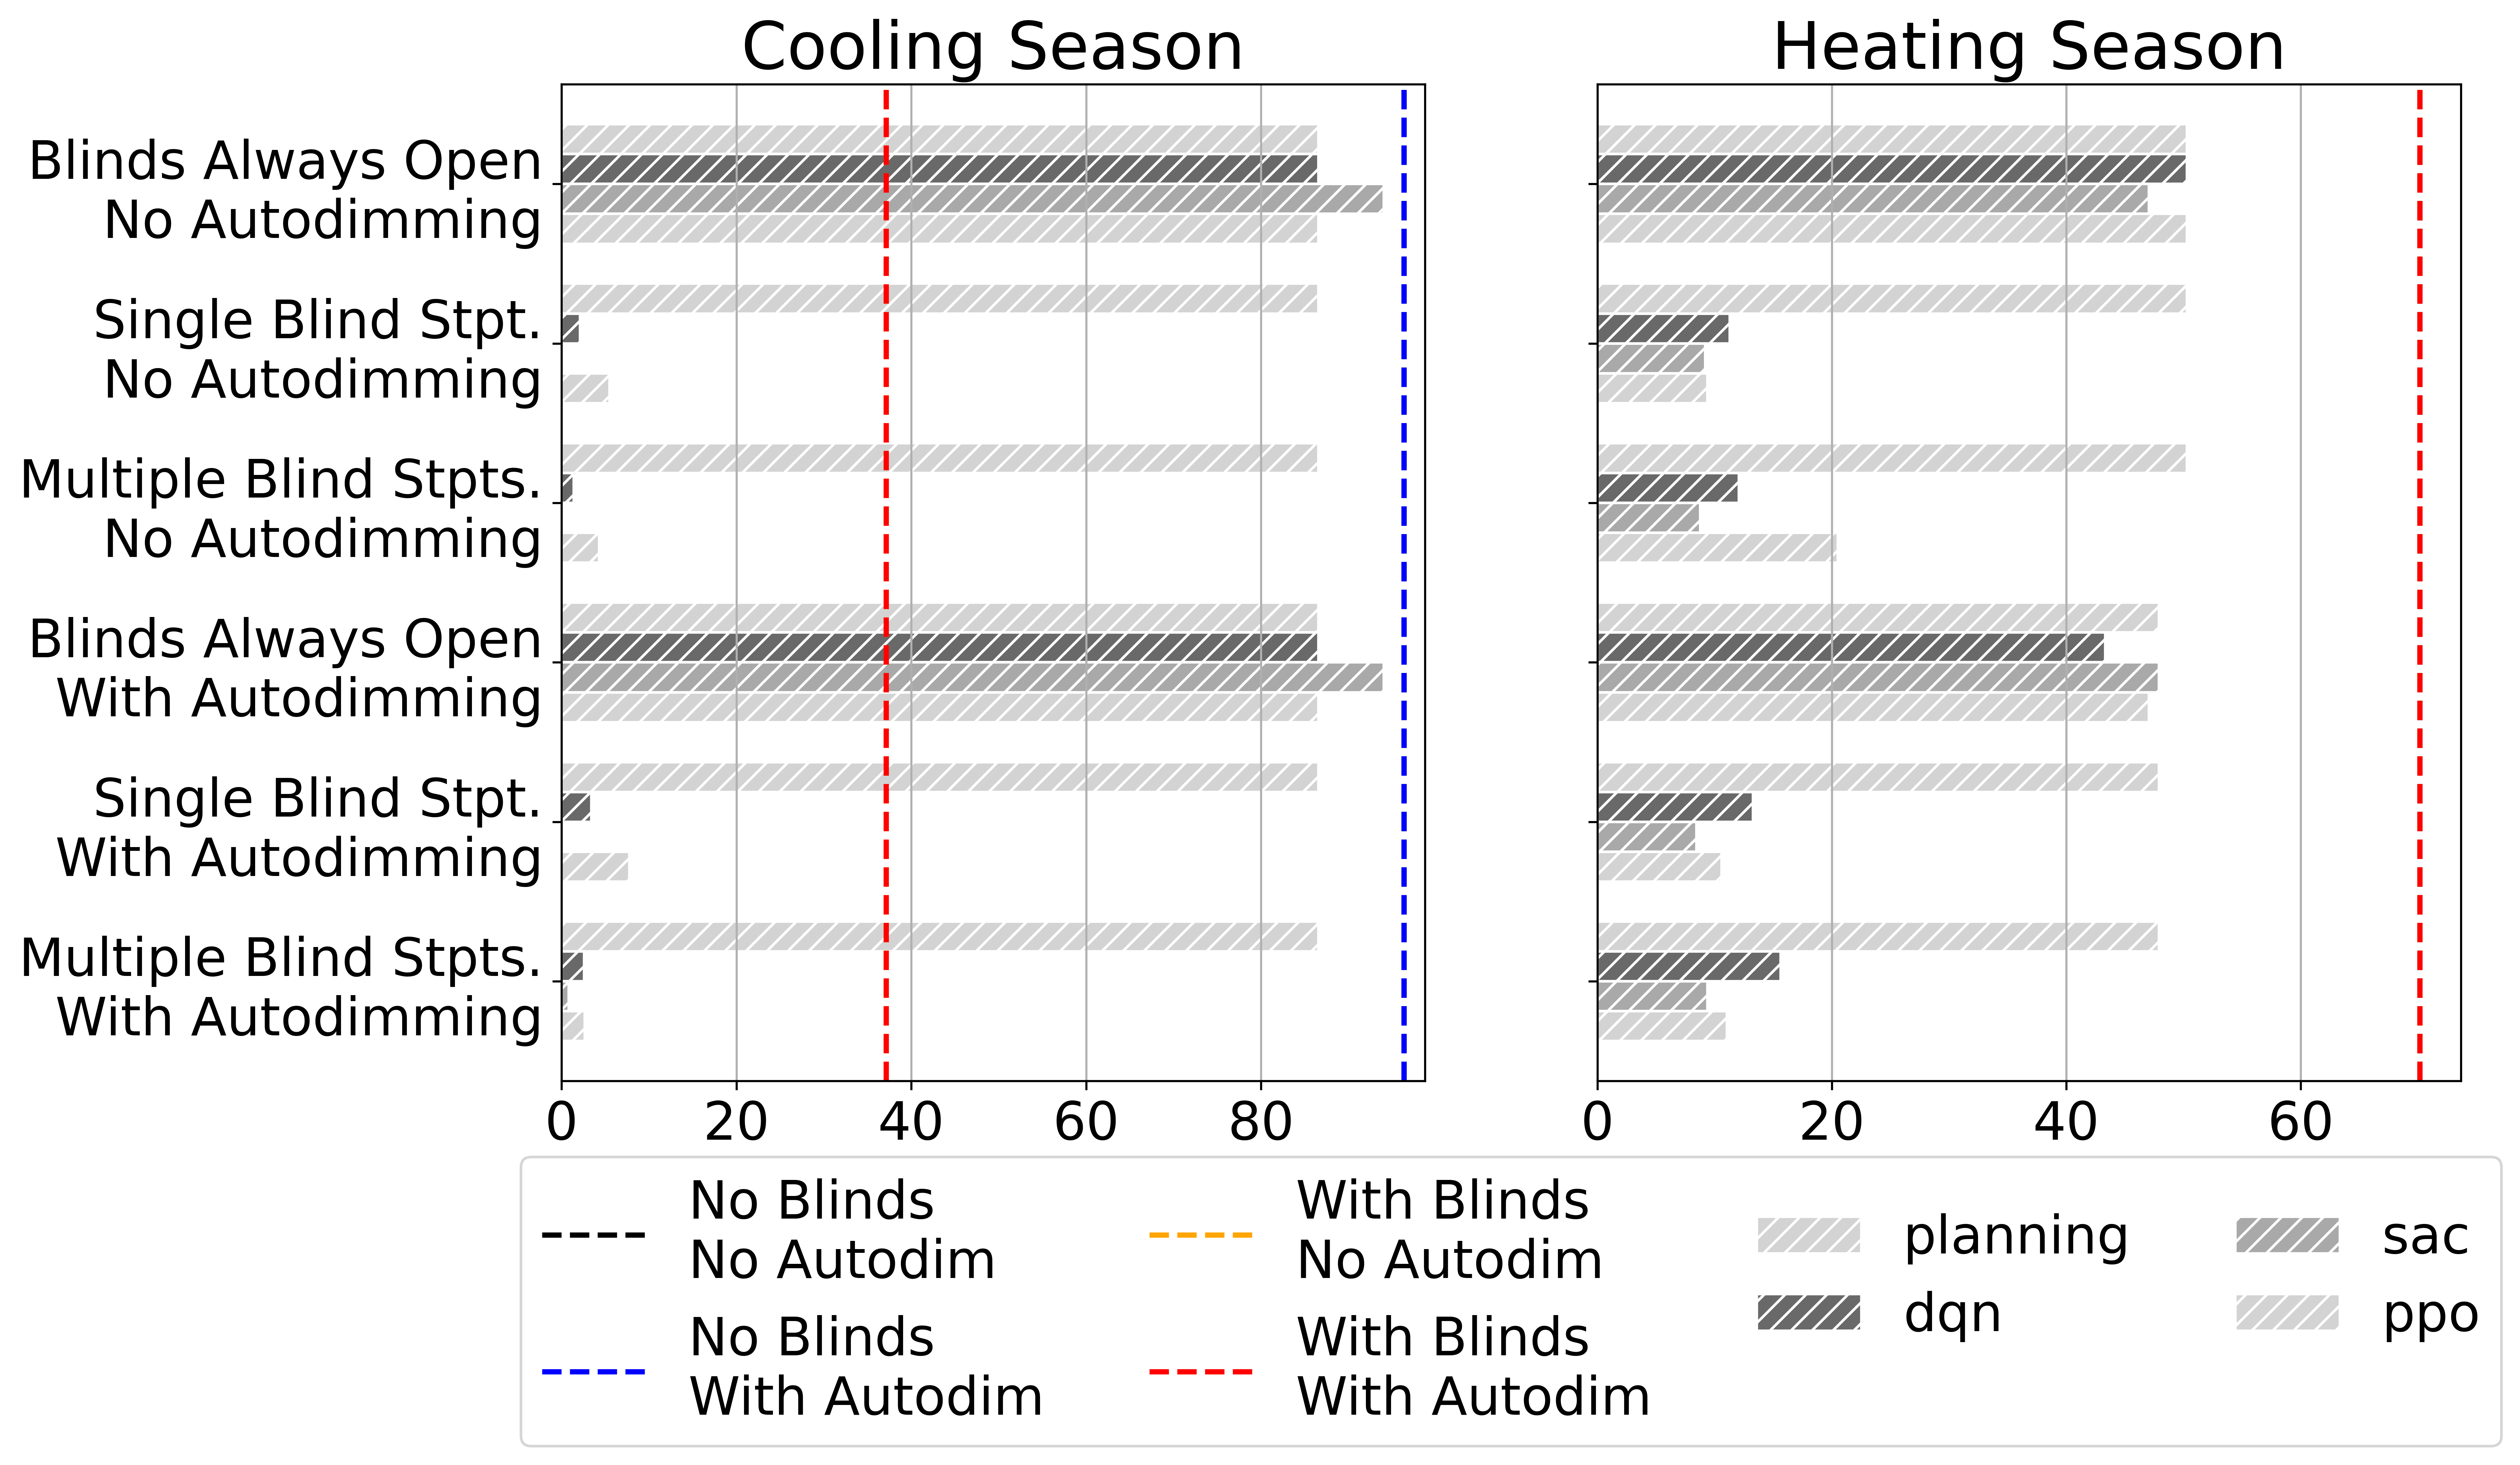

In [19]:
def get_best(season, temp=False): 
    powers = df[df['Unnamed: 0'] == c].iloc[[names['Power']]].values[0][1:]
    illums = df[df['Unnamed: 0'] == c].iloc[[names['Illum Violation']]].values[0][1:]
    pmvs = df[df['Unnamed: 0'] == c].iloc[[names['PMV Violation']]].values[0][1:]
    illums_val = df[df['Unnamed: 0'] == c].iloc[[names['Illum Mean']]].values[0][1:]
    pmvs_val = df[df['Unnamed: 0'] == c].iloc[[names['PMV Mean']]].values[0][1:]
    
    powers[powers == ''] = 99999999
    illums[illums == ''] = 99999
    pmvs[pmvs == ''] = 999
    illums_val[illums_val == ''] = 99999
    pmvs_val[pmvs_val == ''] = 999
    # filter out really low ones.. todo mention this step in paper
#     print(len(powers), len(illums), len(pmvs), powers > 1000)
    
#     filter_bad = powers > 1000
#     powers = powers[filter_bad]
#     illums = illums[filter_bad]
#     pmvs = pmvs[filter_bad]
        
    if season == 'heating':
        min_idx = np.argmin(powers)
    else:
        pmv_acceptable = pmvs < 10
        if pmv_acceptable.any():
            powers = powers[pmv_acceptable]
            pmvs = pmvs[pmv_acceptable]
            illums = illums[pmv_acceptable]
            min_idx = np.argmin(powers)
        else:
#             min_idx = np.argmin(pmvs)
#             min_idx = np.argmax((np.max(powers) - powers) / (pmvs - 0.1))
            min_idx = np.argmin(powers * pmvs)
#             if agent == 'ppo':
#                 if 'blindsFalseMultiFalse lightingFalse' in c:
#                     min_idx = np.argmin(np.abs(powers - 12323233))
#                 elif 'blindsFalseMultiFalse lightingTrue' in c:
#                     min_idx = np.argmin(np.abs(powers - 6652962))
#                 elif 'blindsTrueMultiFalse lightingFalse' in c:
#                     min_idx = np.argmin(np.abs(powers - 12064674))
#                 elif 'blindsTrueMultiFalse lightingTrue' in c:
#                     min_idx = np.argmin(np.abs(powers - 9764268))
#                 elif 'blindsTrueMultiTrue lightingFalse' in c:
#                     min_idx = np.argmin(np.abs(powers - 11151791))
#                 elif 'blindsTrueMultiTrue lightingTrue' in c:
#                     min_idx = np.argmin(np.abs(powers - 8968511))
    
    if temp:
        return powers[min_idx], pmvs[min_idx], illums[min_idx], pmvs_val[min_idx], illums_val[min_idx], min_idx
    return powers[min_idx], pmvs[min_idx], illums[min_idx]


# def get_best(season):  
#     powers = df[df['Unnamed: 0'] == c].iloc[[names['Power']]].values[0][1:]
#     illums = df[df['Unnamed: 0'] == c].iloc[[names['Illum Violation']]].values[0][1:]
#     pmvs = df[df['Unnamed: 0'] == c].iloc[[names['PMV Violation']]].values[0][1:]
    
#     if season == 'heating':
#         min_power = powers[powers > 1000].min()
#         min_
#         min_idx = np.argmin(powers)
#     else:
#         pmv_acceptable = pmvs < 10
#         if pmv_acceptable.any():
#             powers = powers[pmv_acceptable]
#             powers = powers[powers > 1000]
#             min_idx = np.argmin(powers)
#         else:
#             # if there is no acceptable pmv, choose the minimum
#             min_idx = np.argmin(pmvs)

#         return 

n1 = 'Power'
agent_rank = ['planning', 'dqn', 'sac', 'ppo']
fig0, axes0 = plt.subplots(1, 2, figsize=(13,7), sharey=True)
fig1, axes1 = plt.subplots(1, 2, figsize=(13,7), sharey=True)
fig2, axes2 = plt.subplots(1, 2, figsize=(13,7), sharey=True)
table_results = np.zeros((5 * len(agent_rank), 12))
table_baselines = np.zeros((5, 12))
parameter = np.zeros((len(agent_rank), 12))

for season in ['cooling', 'heating']:
    results_powers = {}
    results_powers_vals = {}
    results_pmv = {}
    results_illum = {}
    
    
    if season == 'heating': 
        baselines = heating_baselines
        p_idx = 1
        suptitle = 'Heating Season'
    else:
        baselines = cooling_baselines
        p_idx = 0
        suptitle = 'Cooling Season'
        
    base_hvac, base_iviol, base_pviol, base_light, avg_illu, avg_pmv, _ = load_baseline(*baselines[0], temp=True)
    base_hvac1, base_iviol1, base_pviol1, base_light1, avg_illu1, avg_pmv1, _ = load_baseline(*baselines[1], temp=True)
    base_hvac2, base_iviol2, base_pviol2, base_light2, avg_illu2, avg_pmv2, _ = load_baseline(*baselines[2], temp=True)
    base_hvac3, base_iviol3, base_pviol3, base_light3, avg_illu3, avg_pmv3, _ = load_baseline(*baselines[3], temp=True)
        
    base_power = base_hvac + base_light
    base_power1 = base_hvac1 + base_light1
    base_power2 = base_hvac2 + base_light2
    base_power3 = base_hvac3 + base_light3
    
    print(baselines)
    print(base_power / 4000000, avg_pmv, base_pviol, avg_illu, base_iviol)
    print(base_power1 / 4000000, avg_pmv1, base_pviol1, avg_illu1, base_iviol1)
    print(base_power2 / 4000000, avg_pmv2, base_pviol2, avg_illu2, base_iviol2)
    print(base_power3 / 4000000, avg_pmv3, base_pviol3, avg_illu3, base_iviol3)
    
    table_baselines[0, season != 'heating'::2] = np.array([base_power, base_power1, base_power2, base_power3, base_power2, base_power3]) / 4000000
    table_baselines[1, season != 'heating'::2] = base_pviol, base_pviol1, base_pviol2, base_pviol3, base_pviol2, base_pviol3
    table_baselines[2, season != 'heating'::2] = base_iviol, base_iviol1, base_iviol2, base_iviol3, base_iviol2, base_iviol3
    table_baselines[3, season != 'heating'::2] = avg_pmv, avg_pmv1, avg_pmv2, avg_pmv3, avg_pmv2, avg_pmv3
    table_baselines[4, season != 'heating'::2] = avg_illu, avg_illu1, avg_illu2, avg_illu3, avg_illu2, avg_illu3

    all_paretos = {}
    i = 0
    for agent in agent_rank:
        results_powers = add_dict_list(results_powers, 'agent', agent)
        results_powers_vals = add_dict_list(results_powers_vals, 'agent', agent)
        results_pmv = add_dict_list(results_pmv, 'agent', agent)
        results_illum = add_dict_list(results_illum, 'agent', agent)
        
        agent_paretos = {}
        # Load DataFrame
        df = pd.DataFrame(sheets[agent].get_all_records())
        df.columns = ["Unnamed: 0"] + list(df.columns[1:])
        df["Unnamed: 0"] = df["Unnamed: 0"].replace('', np.nan)
        df = df.fillna(method='ffill')
#         df = pd.read_csv(f'csvs/Result playground - {agent}.csv', index_col=False).fillna(method='ffill')
        df = df.dropna(axis='columns')
#         if agent == 'dqn':
#             df = df.replace({"Unnamed: 0": dqn_rename})
#         if agent == 'ppo':
#             df = df.replace({"Unnamed: 0": ppo_rename})
        cases = df['Unnamed: 0'].unique()

        for c in cases:
            info = c.split(' ')

            # Exclude custom occupancy and specify season
            if f'{season} customOccTrue' in c:
                plt_case = True
                
                # Hardcoding this so we can more easily pick between cases later (ex. should we exclude lighting)
                titles = ['Blinds Always Open\nNo Autodimming',
                          'Blinds Always Open\nWith Autodimming',
                          'Single Blind Stpt.\nNo Autodimming',
                          'Single Blind Stpt.\nWith Autodimming',
                          'Multiple Blind Stpts.\nNo Autodimming',
                          'Multiple Blind Stpts.\nWith Autodimming']
                if 'blindsFalseMultiFalse lightingFalse' in c:
                    j = 0; title=titles[j]
                elif 'blindsFalseMultiFalse lightingTrue' in c:
                    j = 1; title=titles[j]
                elif 'blindsTrueMultiFalse lightingFalse' in c:
                    j = 2; title=titles[j]
                elif 'blindsTrueMultiFalse lightingTrue' in c:
                    j = 3; title=titles[j]
                elif 'blindsTrueMultiTrue lightingFalse' in c:
                    j = 4; title=titles[j]
                elif 'blindsTrueMultiTrue lightingTrue' in c:
                    j = 5; title=titles[j]
                else:
                    plt_case = False
                
                if agent == "planning":
                    jk = j
                    for k in range(3):
                        j = jk + k * 2
                        title = titles[j]
                        best_power, pmv_chosen, illum_chosen, pmv_mean, illum_mean, p = get_best(season, temp=True)
                        parameter[agent_rank.index(agent), 2 * j + (season == "cooling")] = p
                        print(f"{agent} | {season} | {title} | {best_power / 10000000:6.2f} | {pmv_chosen:6.2f} | {illum_chosen:6.2f} | {pmv_mean:6.2f} | {illum_mean:.2f}")
                        table_results[agent_rank.index(agent), 2 * j + (season == "cooling")] = best_power / 4000000#0
                        table_results[agent_rank.index(agent) + len(agent_rank), 2 * j + (season == "cooling")] = pmv_chosen
                        table_results[agent_rank.index(agent) + 2 * len(agent_rank), 2 * j + (season == "cooling")] = illum_chosen
                        table_results[agent_rank.index(agent) + 3 * len(agent_rank), 2 * j + (season == "cooling")] = pmv_mean
                        table_results[agent_rank.index(agent) + 4 * len(agent_rank), 2 * j + (season == "cooling")] = illum_mean
                        results_powers = add_dict_list(results_powers, title, (pdiff(base_power, best_power)))
                        rps = df.columns[(df == best_power).any()].values[0]
                        results_powers_vals = add_dict_list(results_powers_vals, title, rps)
                        results_pmv = add_dict_list(results_pmv, title, pmv_chosen)
                        results_illum = add_dict_list(results_illum, title, illum_chosen)
                else:
                    best_power, pmv_chosen, illum_chosen, pmv_mean, illum_mean, p = get_best(season, temp=True)
                    parameter[agent_rank.index(agent), 2 * j + (season == "cooling")] = p
                    print(f"{agent} | {season} | {title} | {best_power / 10000000:6.2f} | {pmv_chosen:6.2f} | {illum_chosen:6.2f} | {pmv_mean:6.2f} | {illum_mean:.2f}")
                    table_results[agent_rank.index(agent), 2 * j + (season == "cooling")] = best_power / 4000000#0
                    table_results[agent_rank.index(agent) + len(agent_rank), 2 * j + (season == "cooling")] = pmv_chosen
                    table_results[agent_rank.index(agent) + 2 * len(agent_rank), 2 * j + (season == "cooling")] = illum_chosen
                    table_results[agent_rank.index(agent) + 3 * len(agent_rank), 2 * j + (season == "cooling")] = pmv_mean
                    table_results[agent_rank.index(agent) + 4 * len(agent_rank), 2 * j + (season == "cooling")] = illum_mean
                    results_powers = add_dict_list(results_powers, title, (pdiff(base_power, best_power)))
                    rps = df.columns[(df == best_power).any()].values[0]
                    results_powers_vals = add_dict_list(results_powers_vals, title, rps)
                    results_pmv = add_dict_list(results_pmv, title, pmv_chosen)
                    results_illum = add_dict_list(results_illum, title, illum_chosen)
                
                
    df = pd.DataFrame(results_powers)
    
    
    
    df.index = df.agent
    ax = axes0[p_idx]
    colors = ['lightgrey', 'dimgrey', 'darkgrey']
    df1 = df.copy()
#     df.T.drop('agent').plot.barh(ax=ax, hatch='///', width=0.75, edgecolor='white', color=colors)
    df.T.drop('agent').plot.barh(ax=ax, hatch='///', width=0.75, edgecolor='white', color=colors)
    ax.axvline(0, c='black', label='No Blinds\nNo Autodim', linestyle='--')
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set_title(suptitle, fontsize=25)
#     fig0.suptitle('Percent change from baseline', fontsize=30)
    wdth = 2
    ax.axvline(pdiff(base_power, base_power1), label='No Blinds\nWith Autodim',
              c='b', linestyle='--', linewidth=wdth)
    ax.axvline(pdiff(base_power, base_power2), label='With Blinds\nNo Autodim',
              c='orange', linestyle='--', linewidth=wdth)
    ax.axvline(pdiff(base_power, base_power3), label='With Blinds\nWith Autodim',
              c='red', linestyle='--', linewidth=wdth)
    ax.get_legend().remove()
    ax.tick_params(axis='both', which='major', labelsize=20)
    axes0[1].legend(loc='upper center',bbox_to_anchor=(-0.1, -0.05), fontsize=20, ncol=4)
    fig0.savefig('plots/single_agent_power_savings.png', bbox_inches = "tight")
    
    df = pd.DataFrame(results_pmv)
    df.index = df.agent
    ax = axes1[p_idx]
    df2 = df.copy()
    colors = ['lightgrey', 'dimgrey', 'darkgrey']
    df.T.drop('agent').plot.barh(ax=ax, hatch='///', width=0.75, edgecolor='white', color=colors)
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.axvline(base_pviol, label='No Blinds\nNo Autodim',
              c='black', linestyle='--', linewidth=wdth)
    ax.axvline(base_pviol1, label='No Blinds\nWith Autodim',
              c='b', linestyle='--', linewidth=wdth)
    ax.axvline(base_pviol2, label='With Blinds\nNo Autodim',
              c='orange', linestyle='--', linewidth=wdth)
    ax.axvline(base_pviol3, label='With Blinds\nWith Autodim',
              c='red', linestyle='--', linewidth=wdth)
    ax.get_legend().remove()
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title(suptitle, fontsize=25)
    axes1[1].legend(loc='upper center',bbox_to_anchor=(-0.1, -0.05), fontsize=20, ncol=4)
    fig1.savefig('plots/single_agent_pmv.png',bbox_inches = "tight")
#     fig1.suptitle('PMV Violation Rate', fontsize=30)
    
    
    df = pd.DataFrame(results_illum)
    df.index = df.agent
    df3 = df.copy()
    ax = axes2[p_idx]
    colors = ['lightgrey', 'dimgrey', 'darkgrey']
    df.T.drop('agent').plot.barh(ax=ax, hatch='///', width=0.75, edgecolor='white', color=colors)
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.axvline(base_iviol, label='No Blinds\nNo Autodim',
              c='black', linestyle='--', linewidth=wdth)
    ax.axvline(base_iviol1, label='No Blinds\nWith Autodim',
              c='b', linestyle='--', linewidth=wdth)
    ax.axvline(base_iviol2, label='With Blinds\nNo Autodim',
              c='orange', linestyle='--', linewidth=wdth)
    ax.axvline(base_iviol3, label='With Blinds\nWith Autodim',
              c='red', linestyle='--', linewidth=wdth)
    ax.get_legend().remove()
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title(suptitle, fontsize=25)
#     fig2.suptitle('Illumination Violation Rate', fontsize=30)


#     axes[2,1].legend(title='title', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes2[1].legend(loc='upper center',bbox_to_anchor=(-0.1, -0.05), fontsize=20, ncol=4)
    fig2.savefig('plots/single_agent_illum.png', bbox_inches = "tight")


In [16]:
parameter_choice = [0.1, 0.4, 0.7, 1.0]
parameter_index = list()
for i in parameter_choice:
    for j in parameter_choice:
        for k in parameter_choice:
            parameter_index.append(f"{i}-{j}-{k}")

In [18]:
parameter_text = list()
for i in range(parameter.shape[0]):
    parameter_text.append(list())
    for j in range(parameter.shape[1]):
        parameter_text[-1].append(parameter_index[int(parameter[i, j])])

In [26]:
for row in parameter_text:
    print(" & ".join(row), "\\\\ \cline{2-14}")

0.4-0.1-0.7 & 0.1-0.7-0.7 & 0.1-0.1-0.7 & 0.1-0.4-0.4 & 0.1-0.7-1.0 & 0.1-0.1-0.4 & 0.7-0.1-0.1 & 0.1-0.4-0.4 & 1.0-0.7-0.4 & 1.0-0.7-0.1 & 0.7-1.0-0.1 & 0.1-0.7-0.1 \\ \cline{2-14}
1.0-0.1-1.0 & 0.1-0.4-0.1 & 1.0-0.1-1.0 & 0.1-0.4-1.0 & 0.7-0.1-0.4 & 0.1-0.4-1.0 & 0.1-1.0-0.1 & 0.1-1.0-0.1 & 0.7-0.1-1.0 & 0.7-0.1-1.0 & 1.0-0.1-0.7 & 0.1-0.1-0.1 \\ \cline{2-14}
1.0-0.7-0.7 & 0.7-0.4-1.0 & 0.1-0.1-1.0 & 0.7-0.1-0.7 & 0.7-1.0-1.0 & 0.1-0.1-0.1 & 1.0-0.7-0.4 & 1.0-0.1-0.1 & 0.4-1.0-0.1 & 0.1-1.0-0.4 & 0.4-1.0-1.0 & 0.1-0.1-1.0 \\ \cline{2-14}


In [10]:
# table_results = np.round(table_results, 2)
title_names = ["Energy", "Thermal Violation", "Visual Violation", "Thermal Comfort", "Visual Comfort"]

In [32]:
" & ".join(map(str, np.round(table_baselines[0, :], 2)))

'7.28 & 4.06 & 7.02 & 2.55 & 7.08 & 3.99 & 6.81 & 2.75 & 7.08 & 3.99 & 6.81 & 2.75'

In [29]:
for i in range(table_results.shape[0]):
    print("&", agent_rank[i % 3], "&", " & ".join(map(str, table_results[i, :])), "\\\\ \cline{2-14}")

& dqn & 7.59433387 & 3.4703206349999998 & 7.495768862499999 & 2.215054155 & 7.7774394325000005 & 3.3244103475 & 7.889908815 & 2.34509265375 & 7.8491063 & 3.3112427675 & 8.0824465025 & 2.34937696325 \\ \cline{2-14}
& sac & 7.16895452 & 3.48508577 & 6.8405822800000005 & 2.25997172775 & 7.853718865 & 3.1182215775 & 7.833676445 & 2.37385759125 & 7.7187312949999995 & 3.2083102225 & 7.687036934999999 & 2.41573917225 \\ \cline{2-14}
& ppo & 7.5672592875 & 3.8724442675 & 7.184827167500001 & 2.17567211775 & 7.1597473125 & 3.3265391275 & 7.1471421125 & 2.3770685145 & 7.2173433525 & 3.2122936225 & 8.06677377 & 2.46658259075 \\ \cline{2-14}
& dqn & 7.1875 & 8.59375 & 6.71875 & 7.1875 & 3.75 & 8.828125 & 4.140625 & 9.375 & 3.671875 & 7.265625 & 3.28125 & 9.453125 \\ \cline{2-14}
& sac & 6.796875 & 2.5 & 10.078125 & 3.59375 & 2.96875 & 3.203125 & 2.578125 & 3.4375 & 3.359375 & 3.359375 & 3.203125 & 3.28125 \\ \cline{2-14}
& ppo & 6.25 & 30.859375 & 8.75 & 15.46875 & 5.546875 & 8.984375 & 4.53125 & 8

In [31]:
print("\\begin{tabular}{cccccccccccccc}"
      "\\toprule & & \\multicolumn{4}{c}{\\textbf{Blinds always open}} & \\multicolumn{4}{c}{\\textbf{Single blind setpoint}} & \\multicolumn{4}{c}{\\textbf{Multiple blind setpoints}} \\\\"
      " & & \\multicolumn{2}{c}{\\textbf{No dimming}} & \\multicolumn{2}{c}{\\textbf{With Dimming}} & \\multicolumn{2}{c}{\\textbf{No dimming}} & \\multicolumn{2}{c}{\\textbf{With Dimming}} & \\multicolumn{2}{c}{\\textbf{No dimming}} & \\multicolumn{2}{c}{\\textbf{With Dimming}} \\\\"
      "\\cmidrule(lr){3-4}\\cmidrule(lr){5-6}\\cmidrule(lr){7-8}\\cmidrule(lr){9-10}\\cmidrule(lr){11-12}\\cmidrule(lr){13-14}"
      " & & \\textbf{Jan.} & \\textbf{Jul.} & \\textbf{Jan.} & \\textbf{Jul.} & \\textbf{Jan.} & \\textbf{Jul.} & \\textbf{Jan.} & \\textbf{Jul.} & \\textbf{Jan.} & \\textbf{Jul.} & \\textbf{Jan.} & \\textbf{Jul.} \\\\"
      "\\midrule")

names_for_agents = ["Baseline", "BDQN", "SAC", "PPO"]
names_for_row = ["1Energy\\\\ ($MWh$)", "2Thermal\\\\Comfort\\\\($|PMV|$)", "3Thermal\\\\Comfort\\\\Violation ($\\%$)", "4Visual\\\\Comfort\\\\Violation ($\\%$)"]
for i in [0, 3, 1, 2]:
    name_temp = names_for_row.pop(0)
    print("\\multirow{4}{*}{\\begin{tabular}[c]{@{}c@{}}" + name_temp[1:] + "\\end{tabular}}")
    data = np.round(np.concatenate((table_baselines[i, :].reshape(1, -1), table_results[i * 3:i * 3 + 3]), axis=0), 2)
    print(data)
    np.savetxt(f"{name_temp[0]}.csv", data, delimiter=",")
    minimum_value = np.argmin(data, axis=0)
#     print(title_names[i])
    for j, name in enumerate(names_for_agents):
        print_result = list(map(str, data[j, :]))
        for k in np.where(minimum_value == j)[0]:
            print_result[k] = "\\textbf{\\textit{" + print_result[k] + "}}"
        print("&", names_for_agents[j], "&", " & ".join(print_result), "\\\\", "\\cline{2-14}" if j != 3 else "\\midrule")

\begin{tabular}{cccccccccccccc}\toprule & & \multicolumn{4}{c}{\textbf{Blinds always open}} & \multicolumn{4}{c}{\textbf{Single blind setpoint}} & \multicolumn{4}{c}{\textbf{Multiple blind setpoints}} \\ & & \multicolumn{2}{c}{\textbf{No dimming}} & \multicolumn{2}{c}{\textbf{With Dimming}} & \multicolumn{2}{c}{\textbf{No dimming}} & \multicolumn{2}{c}{\textbf{With Dimming}} & \multicolumn{2}{c}{\textbf{No dimming}} & \multicolumn{2}{c}{\textbf{With Dimming}} \\\cmidrule(lr){3-4}\cmidrule(lr){5-6}\cmidrule(lr){7-8}\cmidrule(lr){9-10}\cmidrule(lr){11-12}\cmidrule(lr){13-14} & & \textbf{Jan.} & \textbf{Jul.} & \textbf{Jan.} & \textbf{Jul.} & \textbf{Jan.} & \textbf{Jul.} & \textbf{Jan.} & \textbf{Jul.} & \textbf{Jan.} & \textbf{Jul.} & \textbf{Jan.} & \textbf{Jul.} \\\midrule
\multirow{4}{*}{\begin{tabular}[c]{@{}c@{}}Energy\\ ($MWh$)\end{tabular}}
[[8.34 4.44 8.4  3.2  7.07 3.92 6.81 3.02 7.07 3.92 6.81 3.02]
 [7.59 3.47 7.5  2.22 7.78 3.32 7.89 2.35 7.85 3.31 8.08 2.35]
 [7.17 3.49 6.8

In [17]:
df1

agent  No Blinds\nNo Autodimming  No Blinds\nWith Autodimming  \
agent                                                                 
ppo     ppo                   1.285603                    -0.984137   
dqn     dqn                   5.200092                     4.098069   
sac     sac                  -1.559568                    -6.068595   

       Single Blind Stpt.\nNo Autodimming  \
agent                                       
ppo                             -4.847795   
dqn                             11.465394   
sac                              9.687385   

       Single Blind Stpt.\nWith Autodimming  \
agent                                         
ppo                               -6.193652   
dqn                                9.047235   
sac                               11.524303   

       Multiple Blind Stpts.\nNo Autodimming  \
agent                                          
ppo                                -0.369887   
dqn                                11.745995   
sac                                 7.963579   

       Multiple Blind Stpts.\nWith Autodimming  
agent                                           
ppo                                  -2.338621  
dqn                                  11.830550  
sac                                  10.360574

In [43]:
i = 0
data = np.concatenate((table_baselines[i, :].reshape(1, -1), table_results[i * 3:i * 3 + 3]), axis=0)

In [46]:
pd.DataFrame(data[:, ::2], columns=df1.columns[1:], index=["Baseline", "PPO", "BDQN", "SAC"])

Blinds Always Open\nNo Autodimming  \
Baseline                        2.913143e+07   
PPO                             2.950594e+07   
BDQN                            3.064629e+07   
SAC                             2.867711e+07   

          Blinds Always Open\nWith Autodimming  \
Baseline                          2.809418e+07   
PPO                               2.884474e+07   
BDQN                              3.032526e+07   
SAC                               2.736356e+07   

          Single Blind Stpt.\nNo Autodimming  \
Baseline                        2.830815e+07   
PPO                             2.771920e+07   
BDQN                            3.247146e+07   
SAC                             3.195350e+07   

          Single Blind Stpt.\nWith Autodimming  \
Baseline                          2.723665e+07   
PPO                               2.732713e+07   
BDQN                              3.176702e+07   
SAC                               3.248862e+07   

          Multiple Blind Stpts.\nNo Autodimming  \
Baseline                           2.830815e+07   
PPO                                2.902368e+07   
BDQN                               3.255321e+07   
SAC                                3.145133e+07   

          Multiple Blind Stpts.\nWith Autodimming  
Baseline                             2.723665e+07  
PPO                                  2.845016e+07  
BDQN                                 3.257784e+07  
SAC                                  3.214961e+07

In [37]:
df1

agent  Blinds Always Open\nNo Autodimming  \
agent                                                    
planning  planning                          -10.794175   
dqn            dqn                           -8.977523   
sac            sac                          -14.075940   
ppo            ppo                           -9.302028   

          Single Blind Stpt.\nNo Autodimming  \
agent                                          
planning                          -10.794175   
dqn                                -6.782897   
sac                                -5.868644   
ppo                               -14.186294   

          Multiple Blind Stpts.\nNo Autodimming  \
agent                                             
planning                             -10.794175   
dqn                                   -5.923928   
sac                                   -7.486548   
ppo                                  -13.495972   

          Blinds Always Open\nWith Autodimming  \
agent                                            
planning                            -17.149917   
dqn                                 -10.158882   
sac                                 -18.011671   
ppo                                 -13.885697   

          Single Blind Stpt.\nWith Autodimming  \
agent                                            
planning                            -17.149917   
dqn                                  -5.434887   
sac                                  -6.108864   
ppo                                 -14.337374   

          Multiple Blind Stpts.\nWith Autodimming  
agent                                              
planning                               -17.149917  
dqn                                     -3.127211  
sac                                     -7.866423  
ppo                                     -3.315058

In [31]:
data

array([[8.34336102, 4.44087541, 8.39865459, 3.19747134, 7.07483788,
        3.92327562, 6.80618424, 3.02470398, 7.07483788, 3.92327562,
        6.80618424, 3.02470398],
       [7.44276405, 3.59570641, 6.9124815 , 2.25618287, 7.44276405,
        3.59570641, 6.9124815 , 2.25618287, 7.44276405, 3.59570641,
        6.9124815 , 2.25618287],
       [7.59433387, 3.47032063, 7.49576886, 2.21505415, 7.77743943,
        3.32441035, 7.88990882, 2.34509265, 7.8491063 , 3.31124277,
        8.0824465 , 2.34937696],
       [7.16895452, 3.48508577, 6.84058228, 2.25997173, 7.85371887,
        3.11822158, 7.83367645, 2.37385759, 7.71873129, 3.20831022,
        7.68703693, 2.41573917],
       [7.56725929, 3.87244427, 7.18482717, 2.17567212, 7.15974731,
        3.32653913, 7.14714211, 2.37706851, 7.21734335, 3.21229362,
        8.06677377, 2.46658259]])

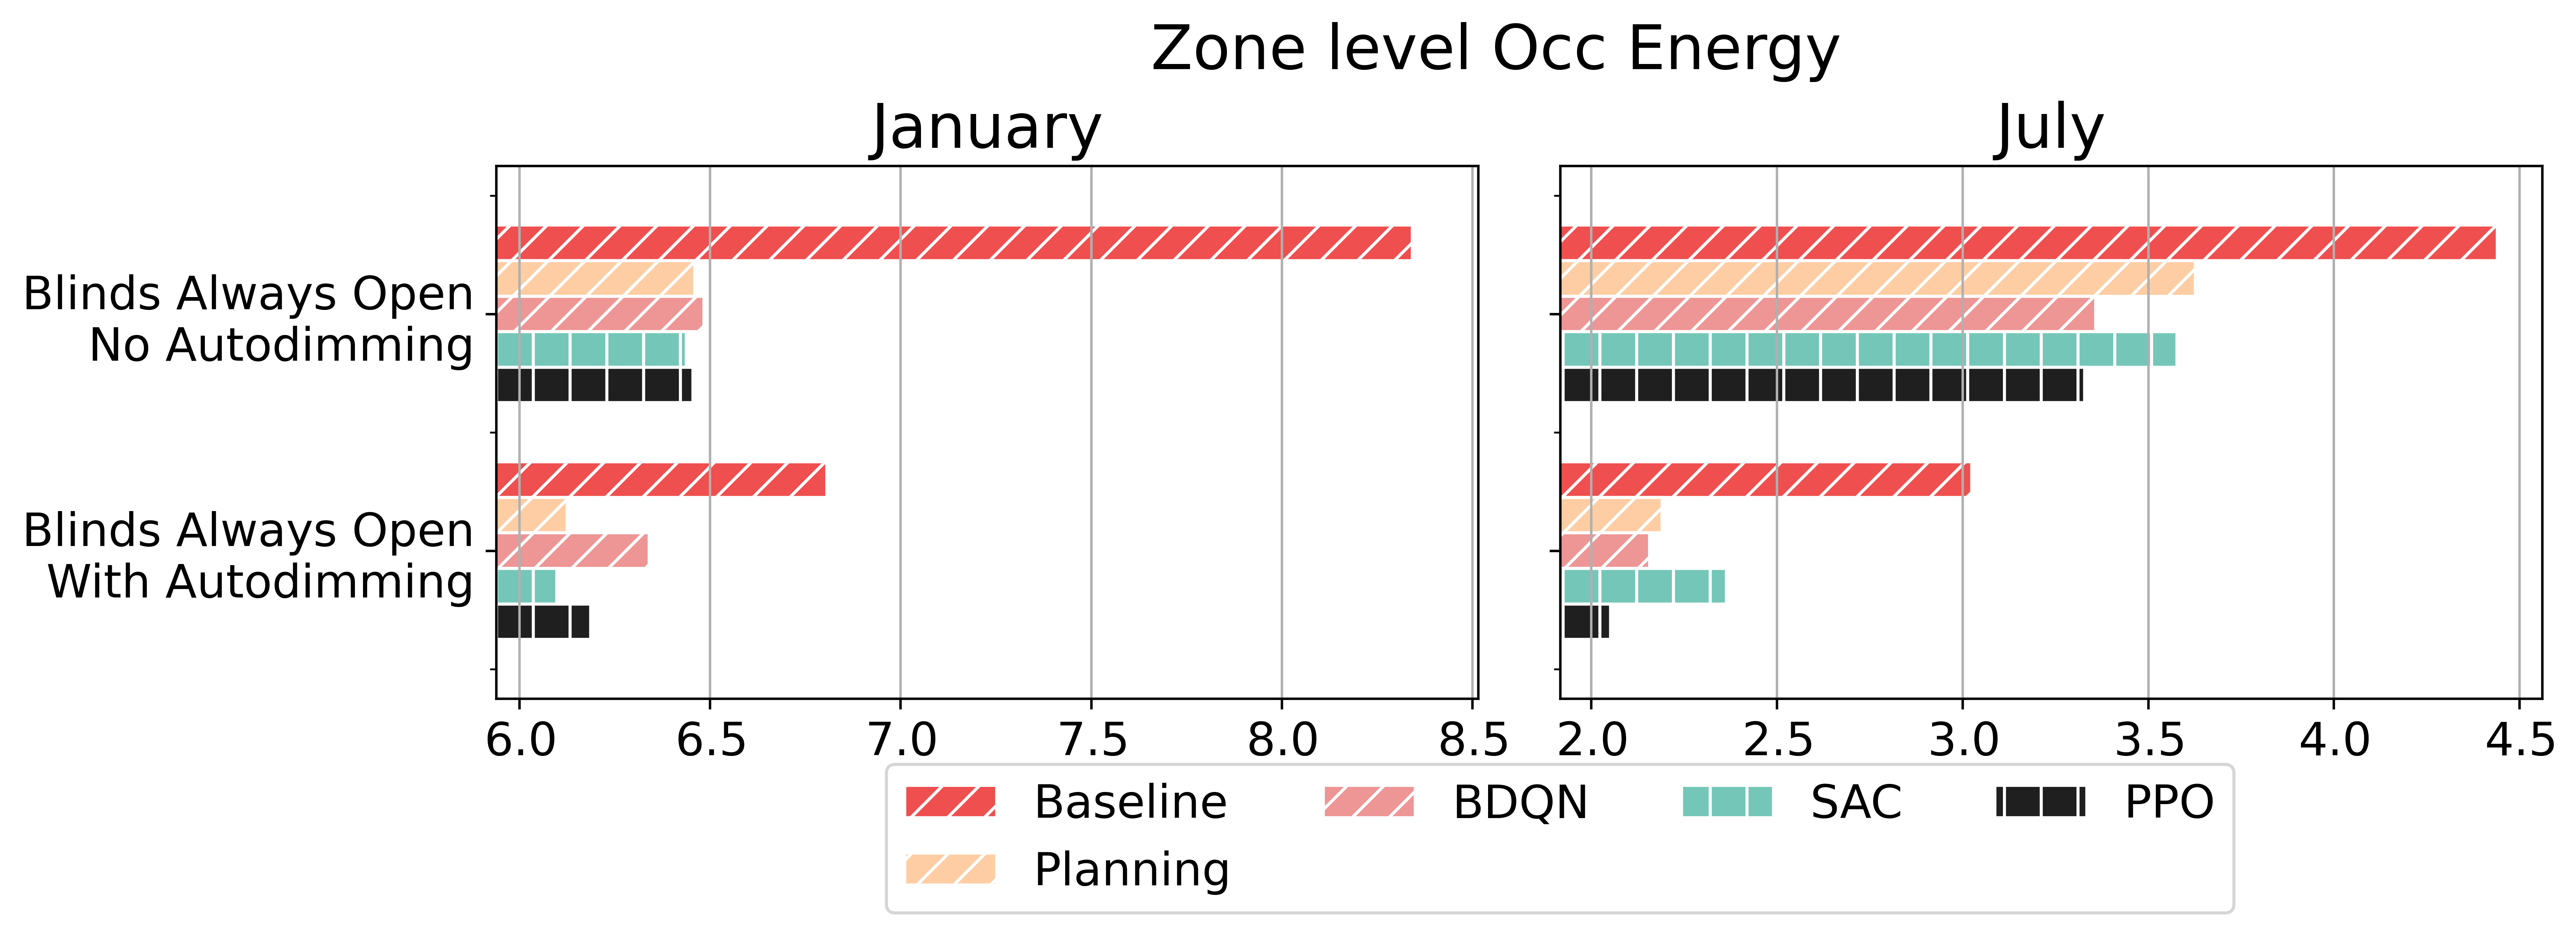

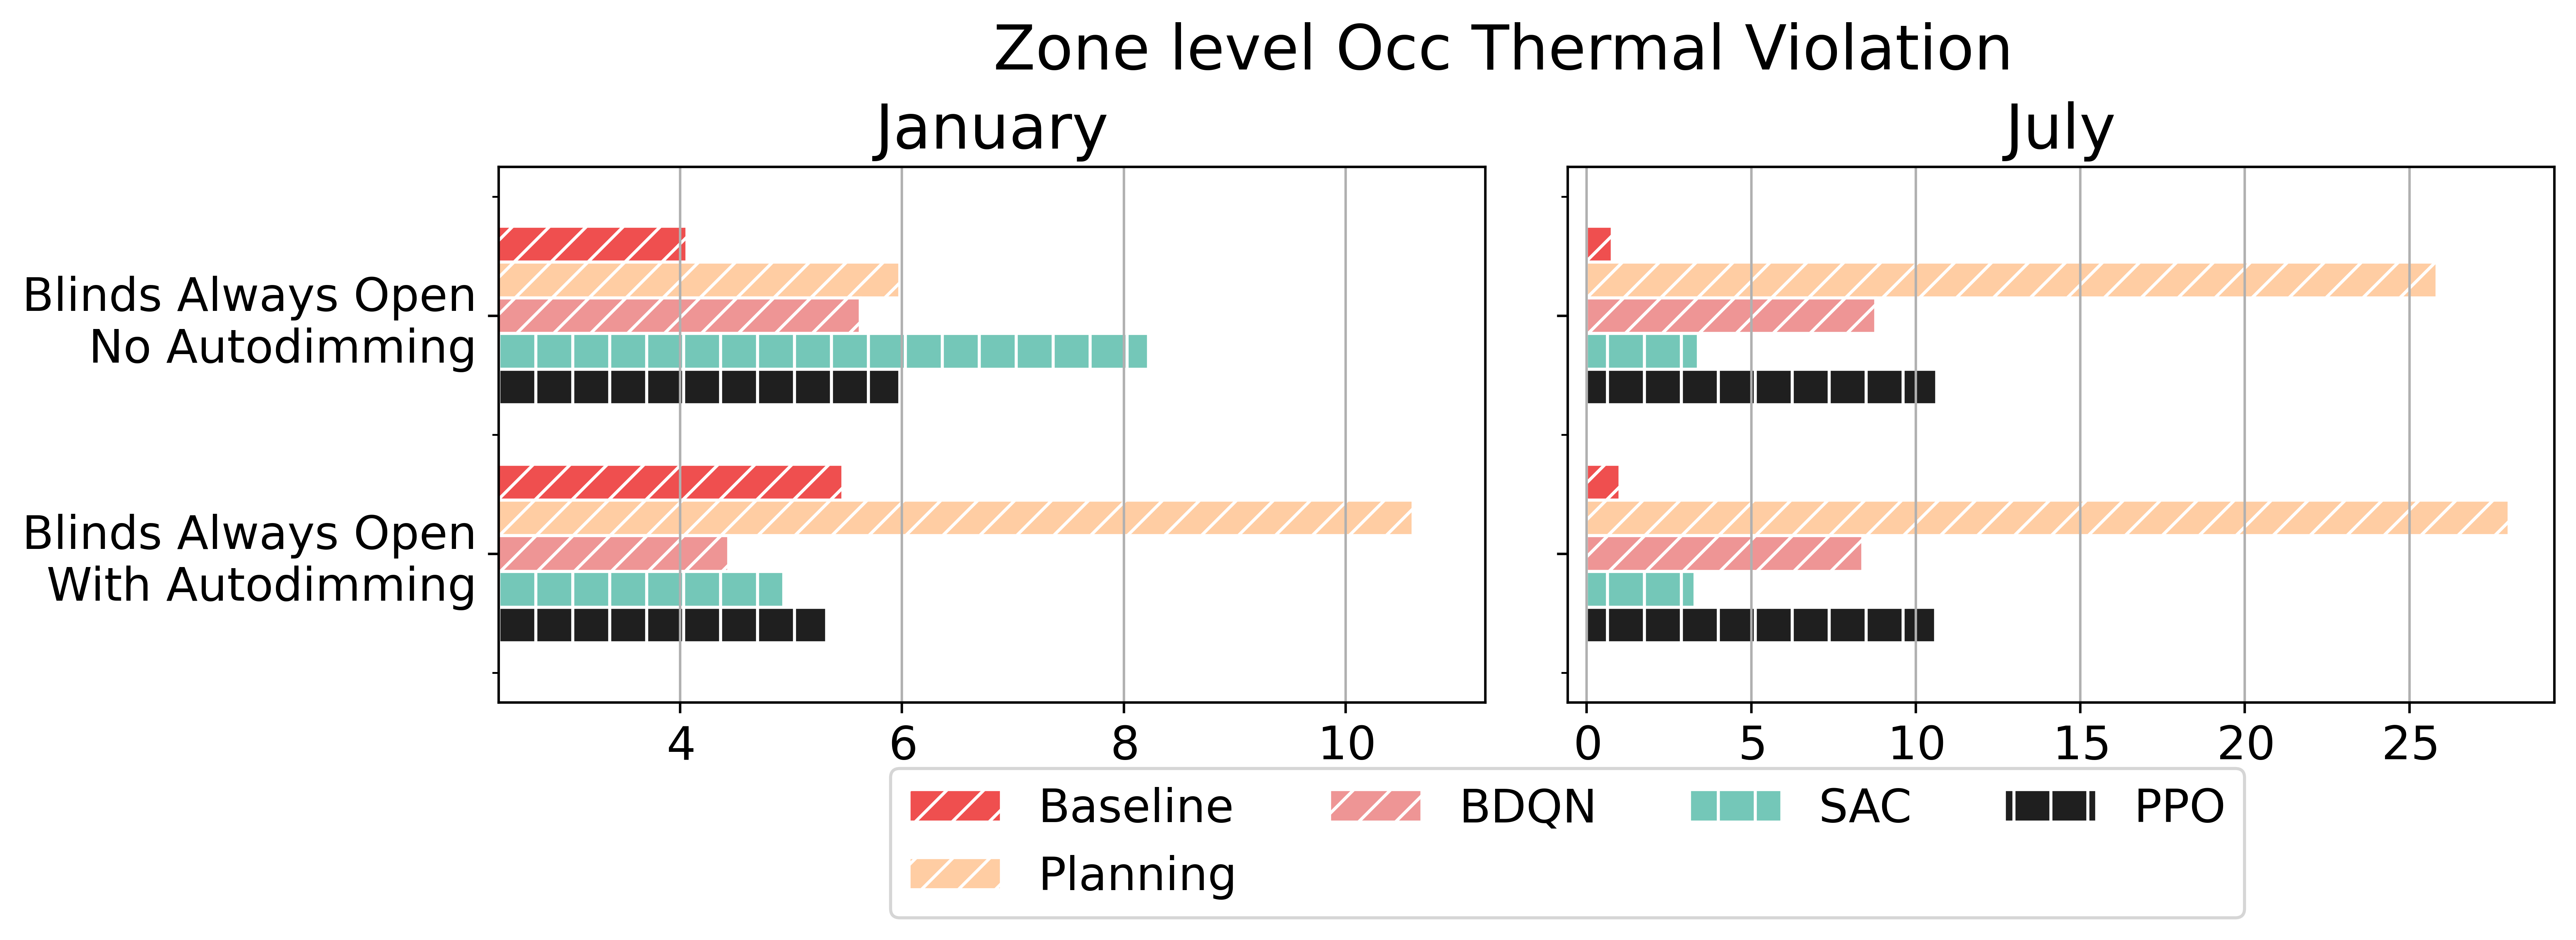

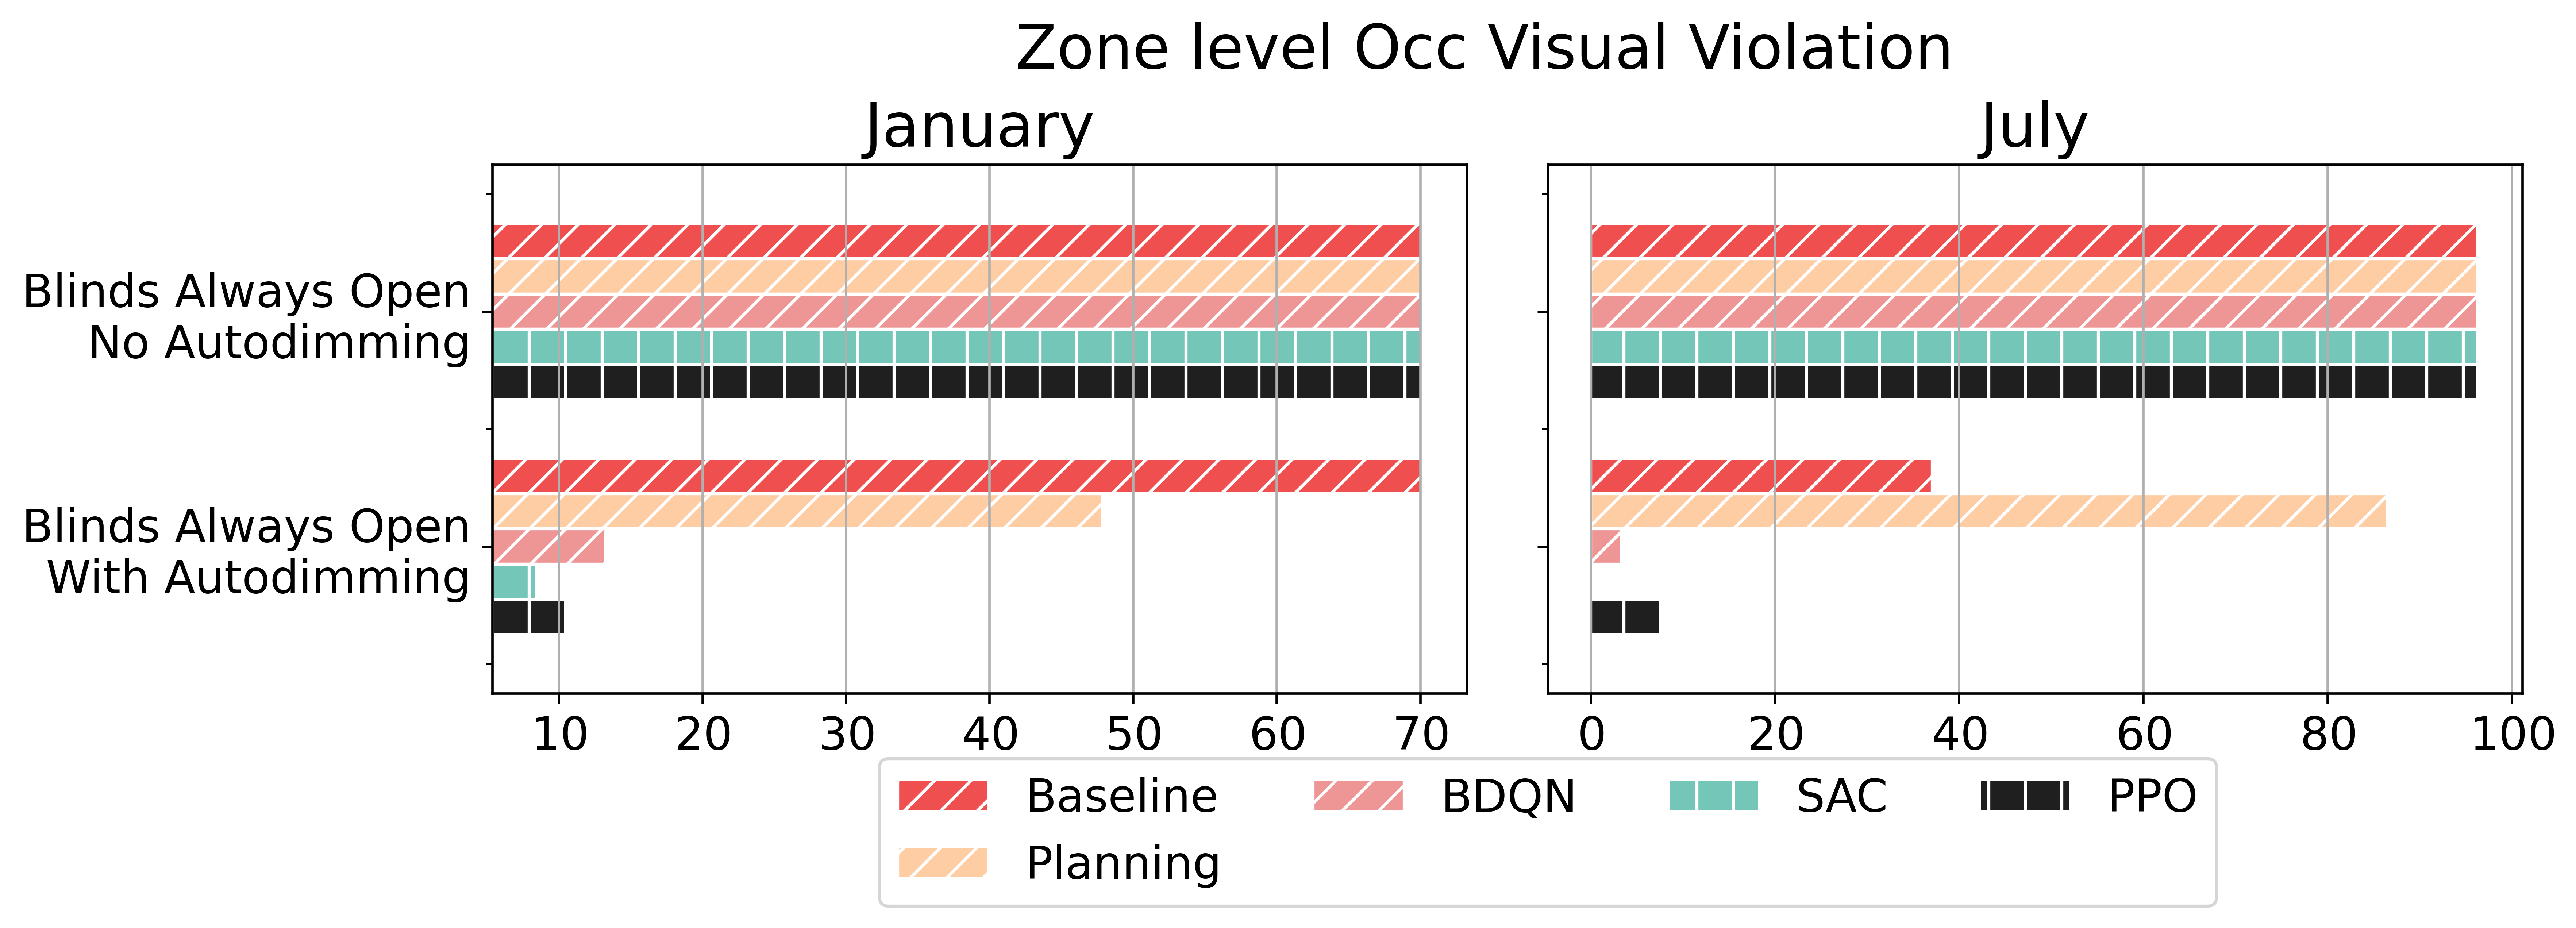

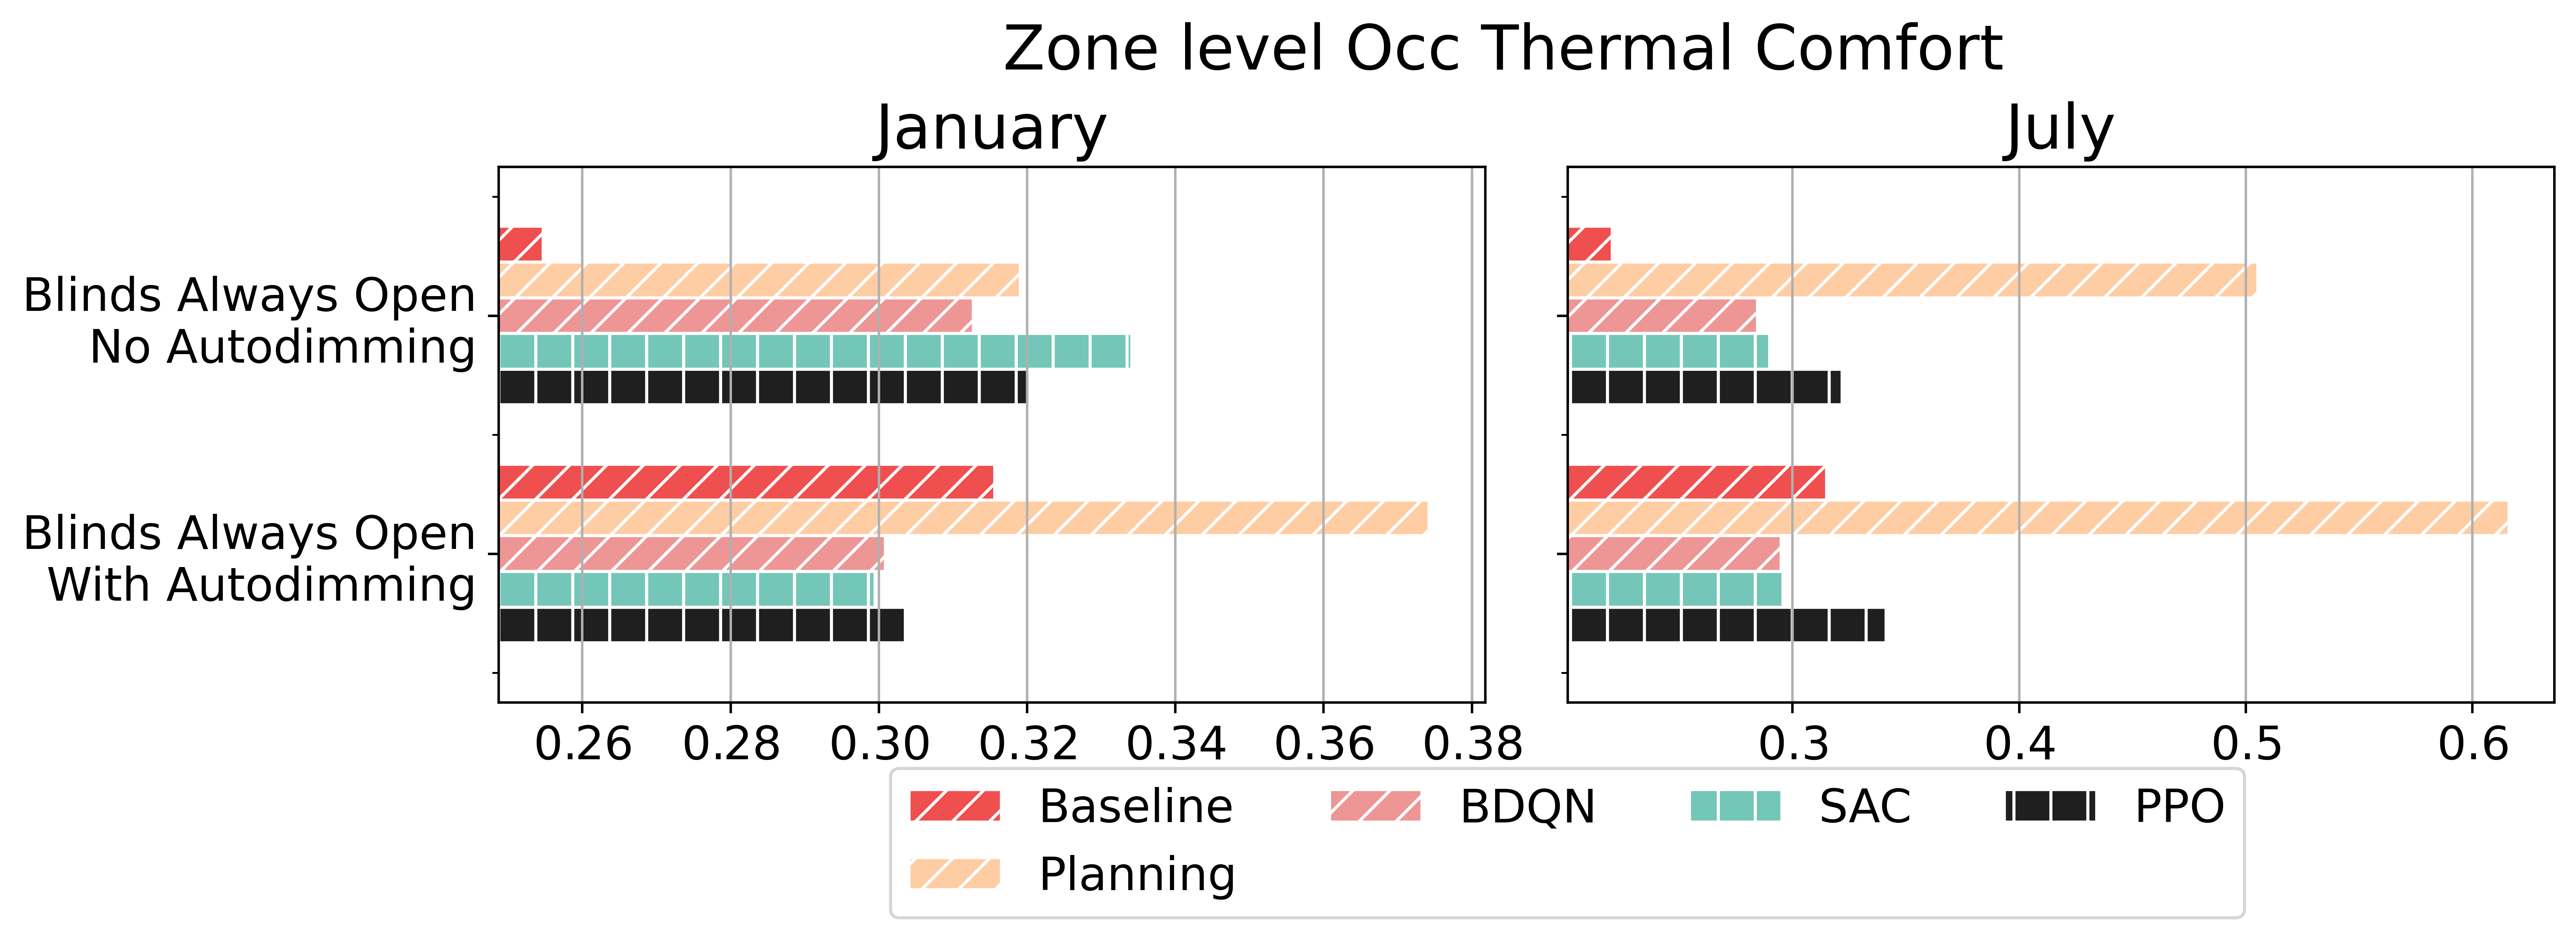

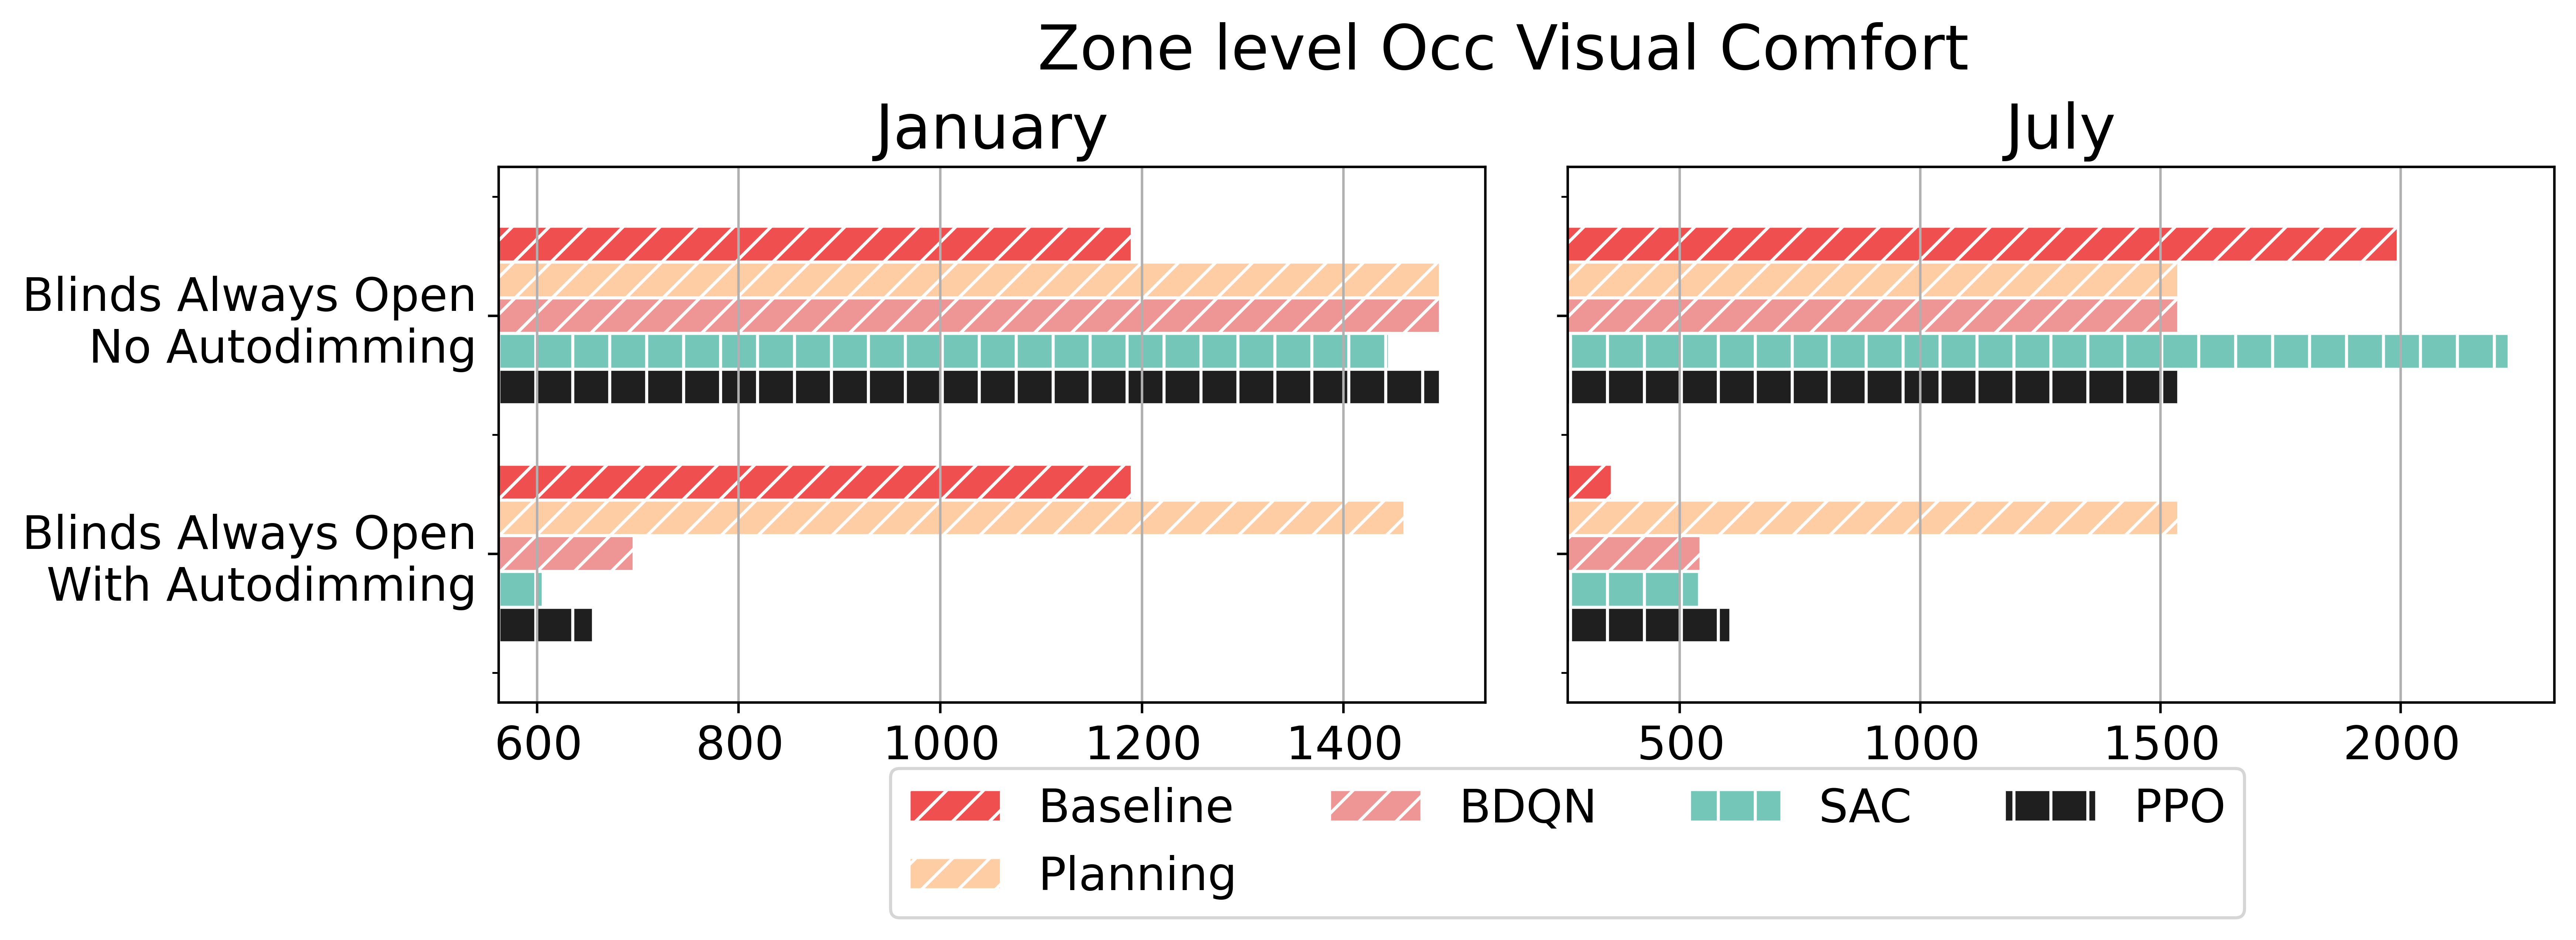

In [20]:
for i in range(5):
    data = np.concatenate((table_baselines[i, :].reshape(1, -1), table_results[i * len(agent_rank):i * len(agent_rank) + len(agent_rank)]), axis=0)
    if i == 2:
        data[1:, :4] = data[0, :4]
    fig, axes = plt.subplots(1, 2, figsize=(10,3), sharey=True)
    fig.tight_layout()
    for j in range(2):
        plt.rc('font', size=10)
        pd.DataFrame(data[:, j::2][:, ::3], columns=df1.columns[1::3], index=["Baseline", "Planning", "BDQN", "SAC", "PPO"]).T.plot.barh(ax=axes[j], width=0.75, edgecolor='white', color=['#ef4f4f', '#ffcda3', '#ee9595', '#74c7b8', "#1f1f1f"])
        bars = axes[j].patches
        for k, bar in enumerate(bars):
            bar.set_hatch(["//", "|", "\\", "///", "\\\\"][k // 6])

        axes[j].grid(axis='x')
        axes[j].get_legend().remove()
        axes[j].tick_params(labelsize=15)
        maximum = np.max(data[:, j::2])
        minimum = np.min(data[:, j::2])
        five_perc = (maximum - minimum) * 0.05
        axes[j].set_xlim(minimum - five_perc, maximum + five_perc)
        axes[j].set_title(["January", "July"][j], fontsize=20)
        axes[j].ticklabel_format(axis='x', useMathText=True)
    axes[0].invert_yaxis()
    axes[1].legend(loc='upper center',bbox_to_anchor=(0, -0.08), fontsize=15, ncol=4)
    plt.savefig(f'plots/bar_{["January", "July"][j]}_{title_names[i]}.png', bbox_inches="tight")
    plt.suptitle("Zone level Occ " + title_names[i], fontsize=20, y=1.15)
    plt.show()
    # plt.figure(figsize=(13, 7))
    # plt.imshow(rgb2gray(mpimg.imread(f'plots/bar_{["January", "July"][j]}_{title_names[i]}.png')), cmap="gray")

In [22]:
table_baselines

array([[2.91314304e+07, 1.62274752e+07, 2.80941821e+07, 1.01816625e+07,
        2.83081451e+07, 1.59687277e+07, 2.72366480e+07, 1.10183534e+07,
        2.83081451e+07, 1.59687277e+07, 2.72366480e+07, 1.10183534e+07],
       [2.59583672e-01, 3.08486239e-01, 2.98097685e-01, 3.66533503e-01,
        2.59590573e-01, 3.58680617e-01, 2.97430938e-01, 4.14709165e-01,
        2.59590573e-01, 3.58680617e-01, 2.97430938e-01, 4.14709165e-01],
       [2.03125000e+00, 2.50000000e+00, 2.89062500e+00, 3.12500000e+00,
        2.42187500e+00, 3.35937500e+00, 3.04687500e+00, 4.76562500e+00,
        2.42187500e+00, 3.35937500e+00, 3.04687500e+00, 4.76562500e+00],
       [1.18443547e+03, 1.98450723e+03, 1.18443547e+03, 1.98450723e+03,
        1.18443547e+03, 5.00863352e+02, 1.18443547e+03, 5.91632602e+02,
        1.18443547e+03, 5.00863352e+02, 1.18443547e+03, 5.91632602e+02],
       [7.08593750e+01, 9.61718750e+01, 7.08593750e+01, 9.61718750e+01,
        7.08593750e+01, 3.86718750e+01, 7.08593750e+01, 4.43

In [20]:
table_results

array([[2.95059450e+00, 1.23232334e+00, 2.88447374e+00, 6.65296285e-01,
        2.77191985e+00, 1.20646742e+00, 2.73271311e+00, 9.76426872e-01,
        2.90236769e+00, 1.11517914e+00, 2.84501567e+00, 8.96851141e-01],
       [3.06462915e+00, 1.39663850e+00, 3.03252565e+00, 8.80652066e-01,
        3.24714637e+00, 1.31011677e+00, 3.17670194e+00, 9.19864330e-01,
        3.25532067e+00, 1.31290412e+00, 3.25778388e+00, 9.21546335e-01],
       [2.86771059e+00, 1.32086628e+00, 2.73635620e+00, 8.23744049e-01,
        3.19535041e+00, 1.23557158e+00, 3.24886248e+00, 8.47221835e-01,
        3.14513348e+00, 1.26933112e+00, 3.21496139e+00, 9.01672869e-01],
       [3.75000000e+00, 5.02343750e+01, 5.85937500e+00, 4.53906250e+01,
        2.50000000e+00, 3.68750000e+01, 2.50000000e+00, 1.74218750e+01,
        3.04687500e+00, 3.85937500e+01, 3.35937500e+00, 1.64843750e+01],
       [3.51562500e+00, 7.42187500e+00, 4.45312500e+00, 5.23437500e+00,
        1.09375000e+00, 6.17187500e+00, 1.17187500e+00, 6.25

In [259]:
df = pd.read_csv(f'csvs/Result playground - sac.csv', index_col=False).fillna(method='ffill')

In [264]:
df.columns[(df == 6641318.07).any()]

Index(['0.7-0.4-0.1'], dtype='object')

In [254]:
heat_hvac, _, _, _, _ = load_baseline(*heating_baselines[0])
cool_hvac, _, _, _, _ = load_baseline(*cooling_baselines[0])

"{:e}".format(heat_hvac), "{:e}".format(cool_hvac)

('2.291892e+07', '1.001497e+07')

# Scratch

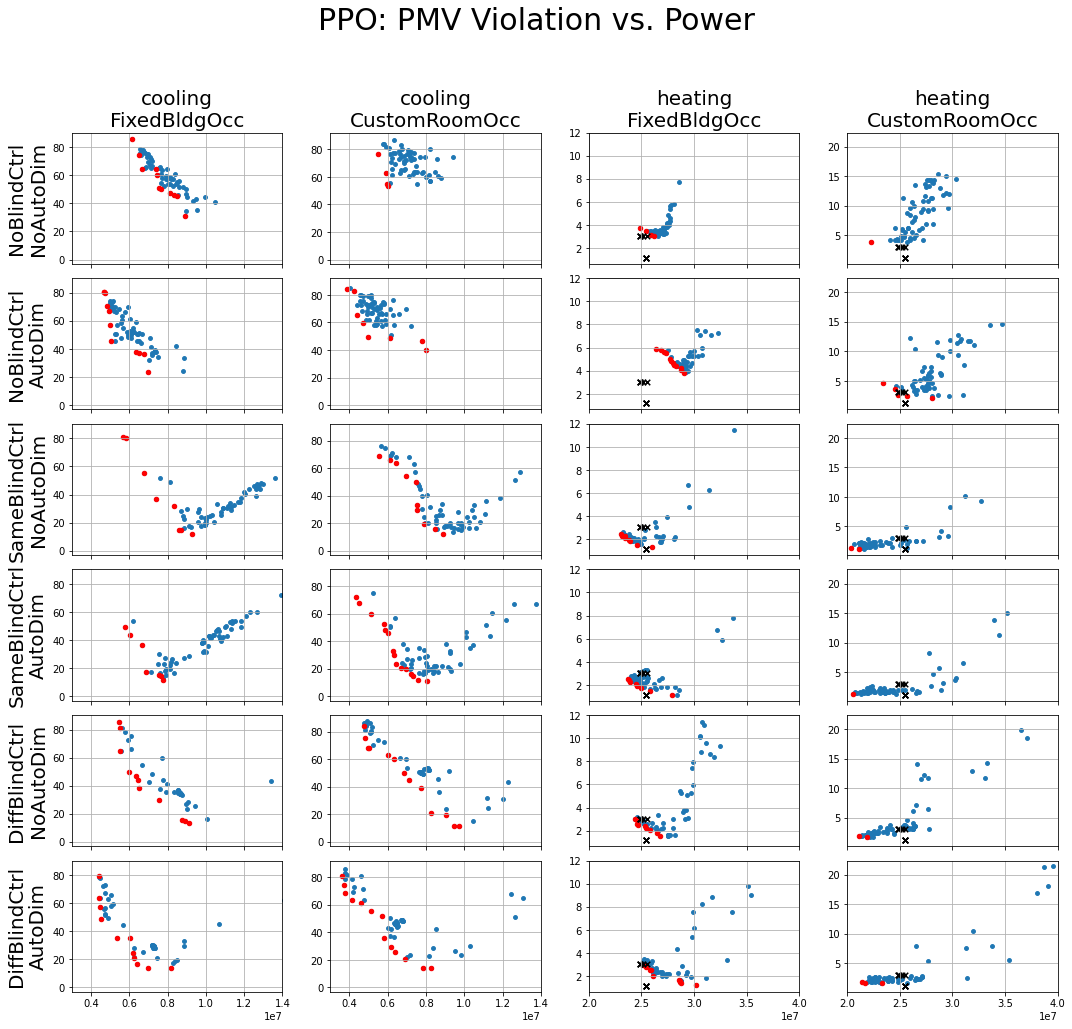

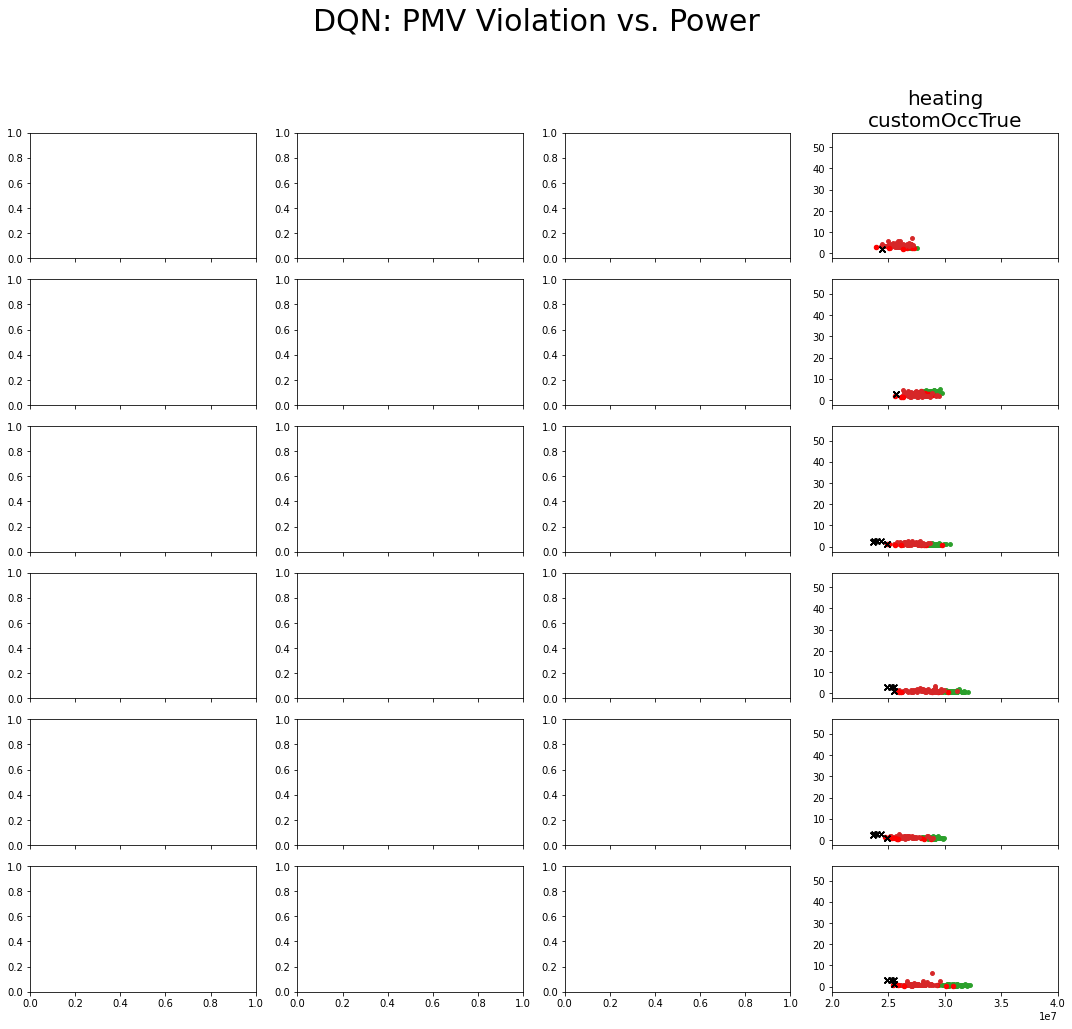

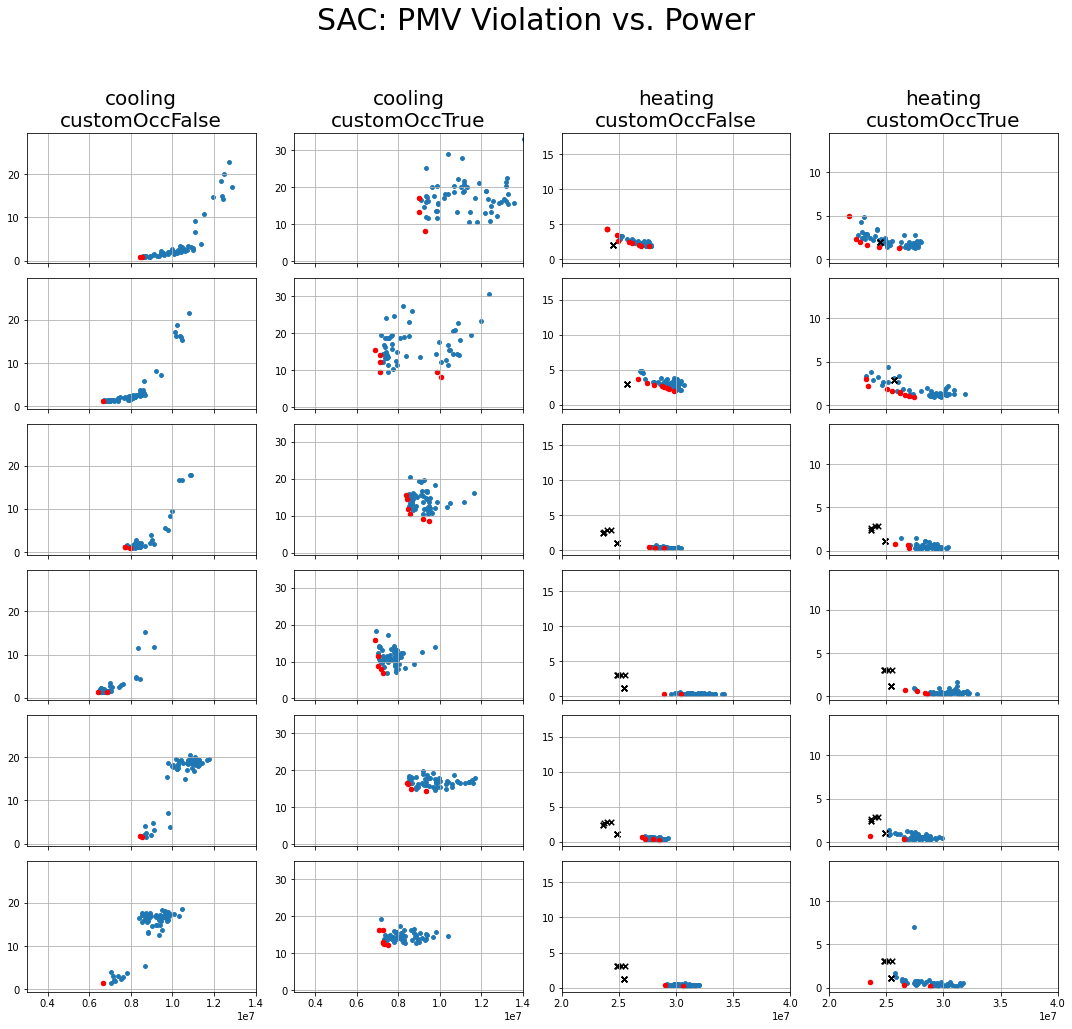

In [21]:
all_paretos = {}
for agent in ['ppo', 'dqn', 'sac']:
    agent_paretos = {}
    df = pd.read_csv(f'csvs/Result playground - {agent}.csv', index_col=False).fillna(method='ffill')
    df = df.dropna(axis='columns')
    if agent == 'dqn':
        df = df.replace({"Unnamed: 0": dqn_rename})
    cases = df['Unnamed: 0'].unique()

    n1 = 'Power'
    n2 = 'PMV Violation'
    fig, axes = plt.subplots(24//4, 4, figsize=(15,15), sharex='col', sharey='col')
    title = f"{agent.upper()}: {n2} vs. {n1}"
    plt.suptitle(title, fontsize=30)
    i = -1
    for c in cases:
        info = c.split(' ')
        i += 1
        if not agent == 'sac':
            if 'cooling FixedBldgOcc' in c:
                j = 0
            elif 'cooling CustomRoomOcc' in c:
                j = 1
            elif 'heating FixedBldgOcc' in c:
                j = 2
            elif 'heating CustomRoomOcc' in c:
                j = 3
        else: 
            if 'cooling customOccFalse' in c:
                j = 0
            elif 'cooling customOccTrue' in c:
                j = 1
            elif 'heating customOccFalse' in c:
                j = 2
            elif 'heating customOccTrue' in c:
                j = 3
                
        ax = axes[i%6,j]

        x_agent = df[df['Unnamed: 0'] == c].iloc[[names[n1]]].values[0][1:]
        y_agent = df[df['Unnamed: 0'] == c].iloc[[names[n2]]].values[0][1:]
        scores = np.stack((x_agent, y_agent), axis=1) #.reshape(-1)
        scores = np.delete(scores, np.where(scores[:,0] <= 0), axis=0)
        
        ax.scatter(scores[:,0], scores[:,1], s=15)

        # Pareto Front
        pareto = identify_pareto(scores)
        pareto_front = scores[pareto]
        
        pareto_front_df = pd.DataFrame(pareto_front)
        pareto_front_df.sort_values(0, inplace=True)
        pareto_front = pareto_front_df.values
        x_pareto = pareto_front[:, 0]
        y_pareto = pareto_front[:, 1]

        agent_paretos[c] = get_rps_on_pareto(x_pareto, y_pareto)

        ax.scatter(x_pareto, y_pareto, color='r', s=20)
        if j == 0:
            ax.set_ylabel(f'{info[-2]}\n{info[-1]}', fontsize=20)
        if i%6 == 0:
            ax.set_title(f'{info[0]}\n{info[1]}', fontsize=20)
            
        if j == 0 or j == 1:
            # set lim for cooling season
            ax.set_xlim(0.3e7, 1.4e7)
        else:
            ax.set_xlim(2e7, 4e7)
            
        if agent == 'sac':
            ax.set_ylabel('', fontsize=20)
            
        # Plot Baselines
        bls = get_baseline(c, agent)
        ax.scatter(bls[n1].values, bls[n2].values, color='black', s=30,  marker='x')
        ax.grid()
    all_paretos[agent] = agent_paretos
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.savefig(f'{title}.png') 

NoBlindCtrl, NoAutoDim [26242007.08, 25435295.02, 25912426.96, 24846565.78]
NoBlindCtrl, AutoDim [26913702.21, 29030716.7, 27756284.3, 28319425.58, 27974765.92, 27816795.98, 28756807.65, 27380620.12, 27166167.78, 28121081.34, 26436620.52, 28802873.24]
SameBlindCtrl, NoAutoDim [23134707.86, 25982687.99, 23870739.35, 23884853.42, 24570847.96, 23059819.28, 23452563.34, 23459453.38]
SameBlindCtrl, AutoDim [23795057.83, 23741368.37, 25786253.83, 24941214.82, 24618773.27, 23889754.4, 24509226.63, 27890524.53]
DiffBlindCtrl, NoAutoDim [24616917.07, 24722982.59, 26449257.56, 25853733.61, 25443924.01, 26807563.87, 24364297.73, 25319557.74, 24544520.68]
DiffBlindCtrl, AutoDim [28689851.0, 25445962.22, 28733641.18, 25917355.74, 26083113.06, 30160407.21, 25113868.27, 28692693.45, 25834931.08, 28614236.7]


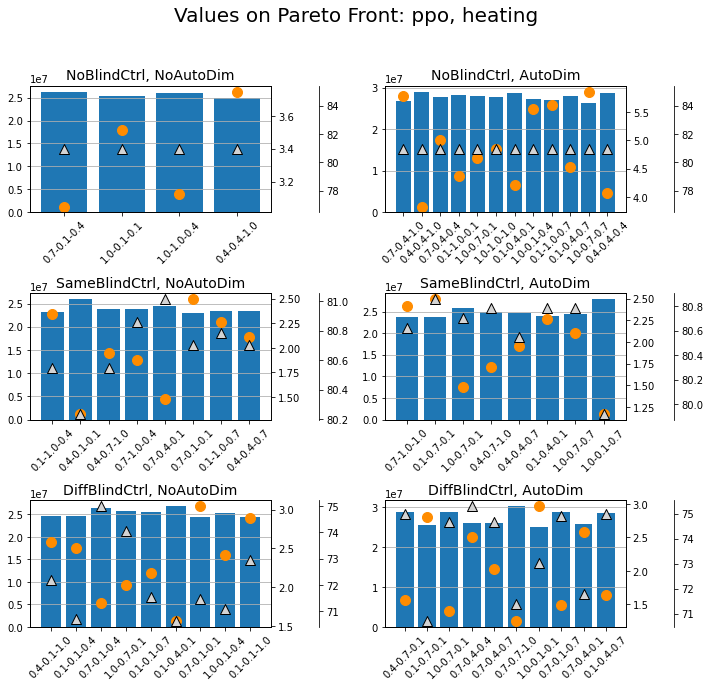

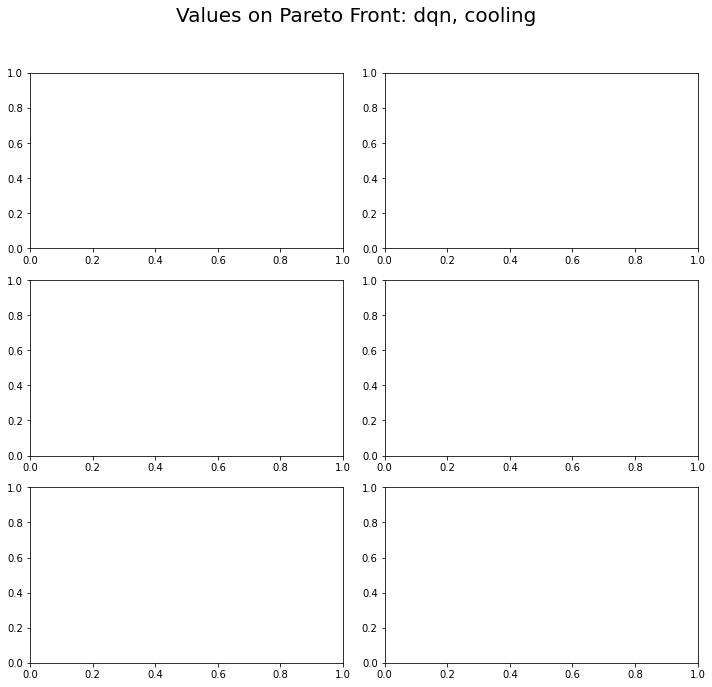

In [22]:
# Chose these based on the pareto fronts:
bests = [('ppo', 'heating'), ('dqn', 'cooling')]

for agent, season in bests:
    d = all_paretos[agent]
    fig, axes = plt.subplots(3, 2, figsize=(10,10))
    plt.suptitle(f'Values on Pareto Front: {agent}, {season}', fontsize=20)
    i = 0
    for key, value in d.items():
        if (season in key) and ('FixedBldgOcc' in key):
            keys = key.split(' ')
            ax = axes[i//2,i%2]
            t = f'{keys[-2]}, {keys[-1]}'
            print(t, value['Power'])
            ax.set_title(t, fontsize=14)
            ax.bar(value['rps'], value['Power'], label='Power')

            for tick in ax.get_xticklabels():
                tick.set_rotation(45)
            ax1 = ax.twinx()
            ax2 = ax.twinx()
            ax.grid(axis='y')
            ax1.scatter(value['rps'], value['PMV Violation'], marker='o', s = 100, c='darkorange', label='PMV')
            ax2.scatter(value['rps'], value['Illum Violation'], marker='^', s = 100, c='lightgrey', label='PMV',  edgecolor='black')
            ax2.spines["right"].set_position(("axes", 1.2))
            i += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.savefig(f'rps on paretos, {agent}, {season}.png')
    plt.show()

In [2]:
import pickle
with open("all_all_results", "rb") as file:
    data = pickle.load(file)

In [65]:
data = np.vstack(data)

In [66]:
mean = data.mean(axis=0)

In [67]:
mean

array([0.36562672, 0.61466962, 0.85641778, 1.10047948, 1.33793831,
       1.56954181, 1.79873204, 2.02137375, 2.23770118, 2.45236826,
       2.65974522, 2.86324835, 3.06292486, 3.2580905 , 3.44914746,
       3.63151312, 3.81254053, 3.98847842, 4.1654706 , 4.33669281])

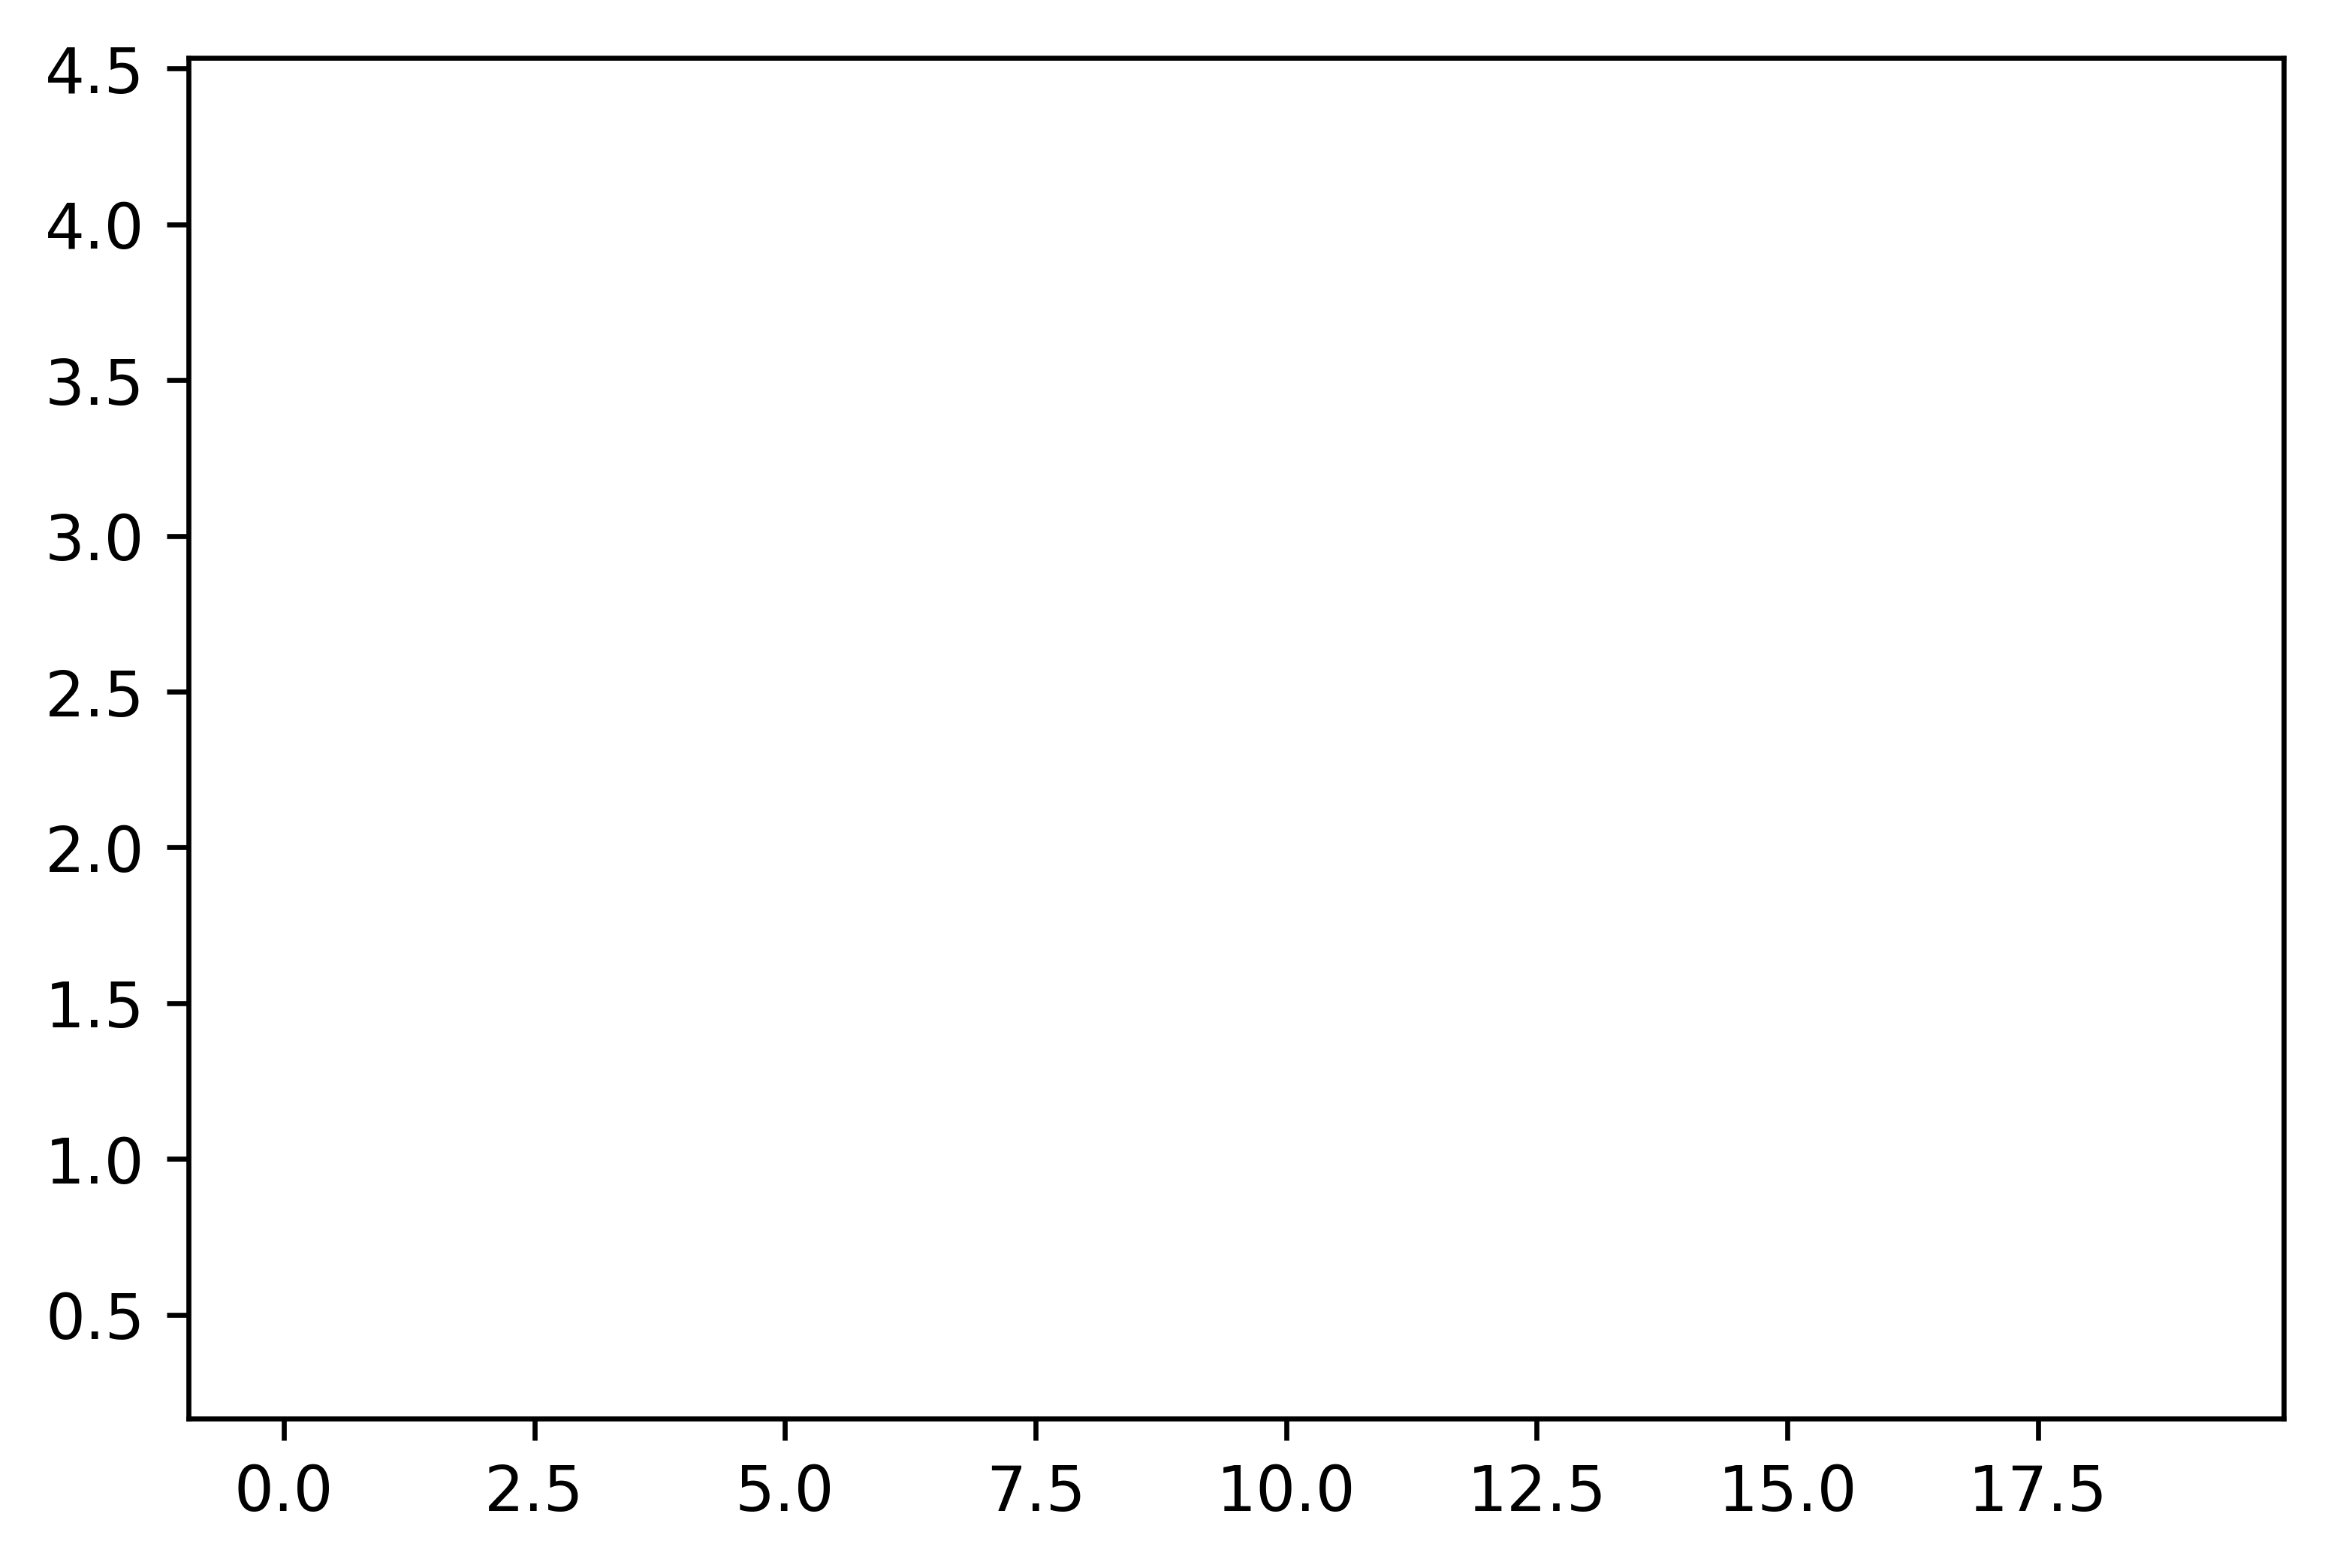

In [69]:
import scipy.stats

se = scipy.stats.sem(data, axis=0)
m = data.mean(axis=0)
h = se * 1.96 / (10 ** 0/5)
plt.fill_between(np.arange(20), m + h, m - h)

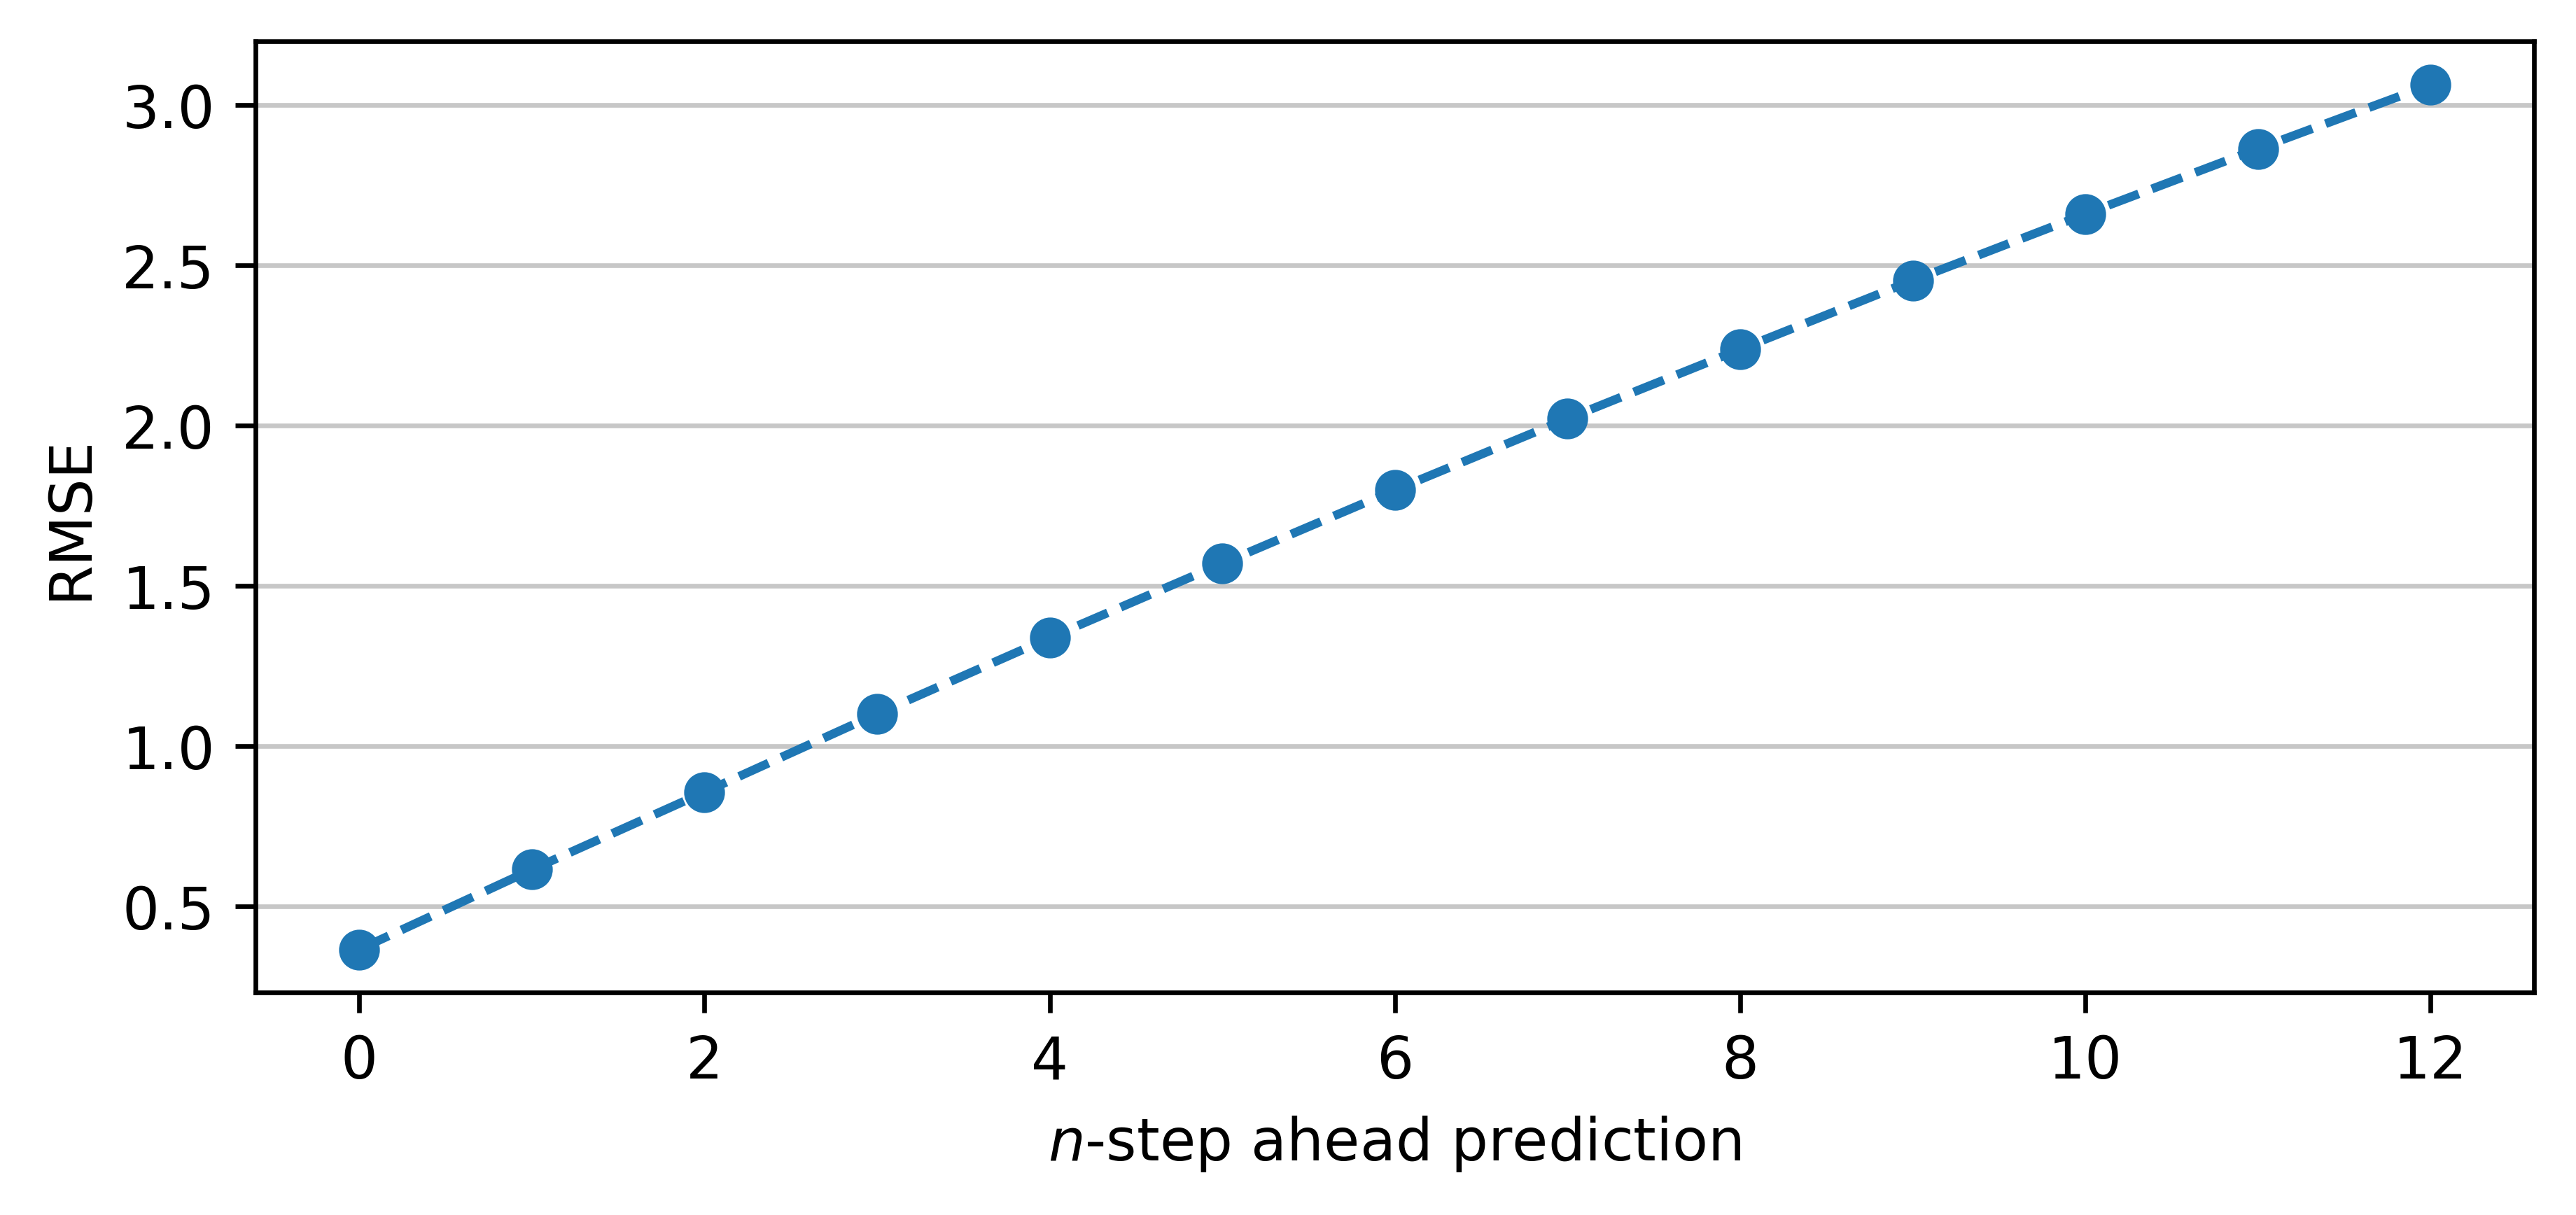

<function matplotlib.pyplot.savefig(*args, **kwargs)>

In [71]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(mean[:13], marker='o', linestyle='--')
# plt.fill_between(np.arange(15), np.max(data, axis=0), np.min(data, axis=0))
ax.set_xlabel("$n$-step ahead prediction")
ax.set_ylabel("RMSE")
plt.tick_params(axis='y', which='minor')
# ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))
plt.grid(True, axis='y', alpha=0.7)
plt.grid(True, axis='y', which='minor', alpha=0.2)
plt.show()
plt.savefig

In [72]:
np.min(data, axis=0)

array([0.36562672, 0.61466962, 0.85641778, 1.10047948, 1.33793831,
       1.56954181, 1.79873204, 2.02137375, 2.23770118, 2.45236826,
       2.65974522, 2.86324835, 3.06292486, 3.2580905 , 3.44914746,
       3.63151312, 3.81254053, 3.98847842, 4.1654706 , 4.33669281])

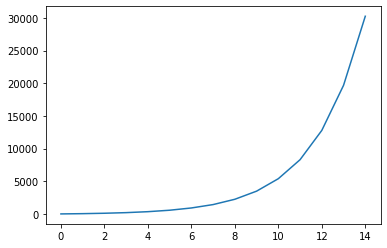

In [78]:
plt.plot(data[9, :])

In [62]:
data[:, 1]

array([43.01789856, 26.17759132, 39.93069839, 22.70094109, 46.46406937,
       11.29599094,  9.66280746, 20.09350395, 16.9287281 , 40.13822556])

In [64]:
import pickle
data = list()
for i in range(10):
    if i == 6:
        continue
    with open("home0", "rb") as file:
        _, reward = pickle.load(file)
        data.append(reward)

In [18]:
df = pd.read_csv("baselines/SAT_SP_cooling_blindsAll_setpoint0_daylightingTrue.csv", index_col="time")

In [19]:
df.columns

Index(['Outdoor Temp.', 'Diff. Solar Rad.', 'Direct Solar Rad.', 'HVAC Power',
       'Sys Out Temp.', 'Heat Coil Power', 'Cool Coil Power', 'Occupancy Flag',
       'MA Temp.', 'Indoor Temp. Setpoint', 'In Node Temp Zone 1',
       'In Node Temp Zone 2', 'In Node Temp Zone 3', 'In Node Temp Zone 4',
       'In Node Temp Zone 5', 'In Node Flow Zone 1', 'In Node Flow Zone 2',
       'In Node Flow Zone 3', 'In Node Flow Zone 4', 'In Node Flow Zone 5',
       'PPD', 'PPD Zone 1', 'PPD Zone 2', 'PPD Zone 3', 'PPD Zone 4',
       'PPD Zone 5', 'PMV Zone 1', 'PMV Zone 2', 'PMV Zone 3', 'PMV Zone 4',
       'PMV Zone 5', 'Indoor Temp.', 'Temp Zone 1', 'Temp Zone 2',
       'Temp Zone 3', 'Temp Zone 4', 'Temp Zone 5', 'Lights Zone 1',
       'Lights Zone 2', 'Lights Zone 3', 'Lights Zone 4', 'Lights Zone 5',
       'Shade On Zone 1', 'Blind Angle Zone 1', 'Blind Angle Zone 4',
       'Blind Angle Zone 2', 'Blind Angle Zone 3', 'Illum 1 Zone 1',
       'Illum 2 Zone 1', 'Illum 1 Zone 3', 'Illum

<AxesSubplot:xlabel='time'>

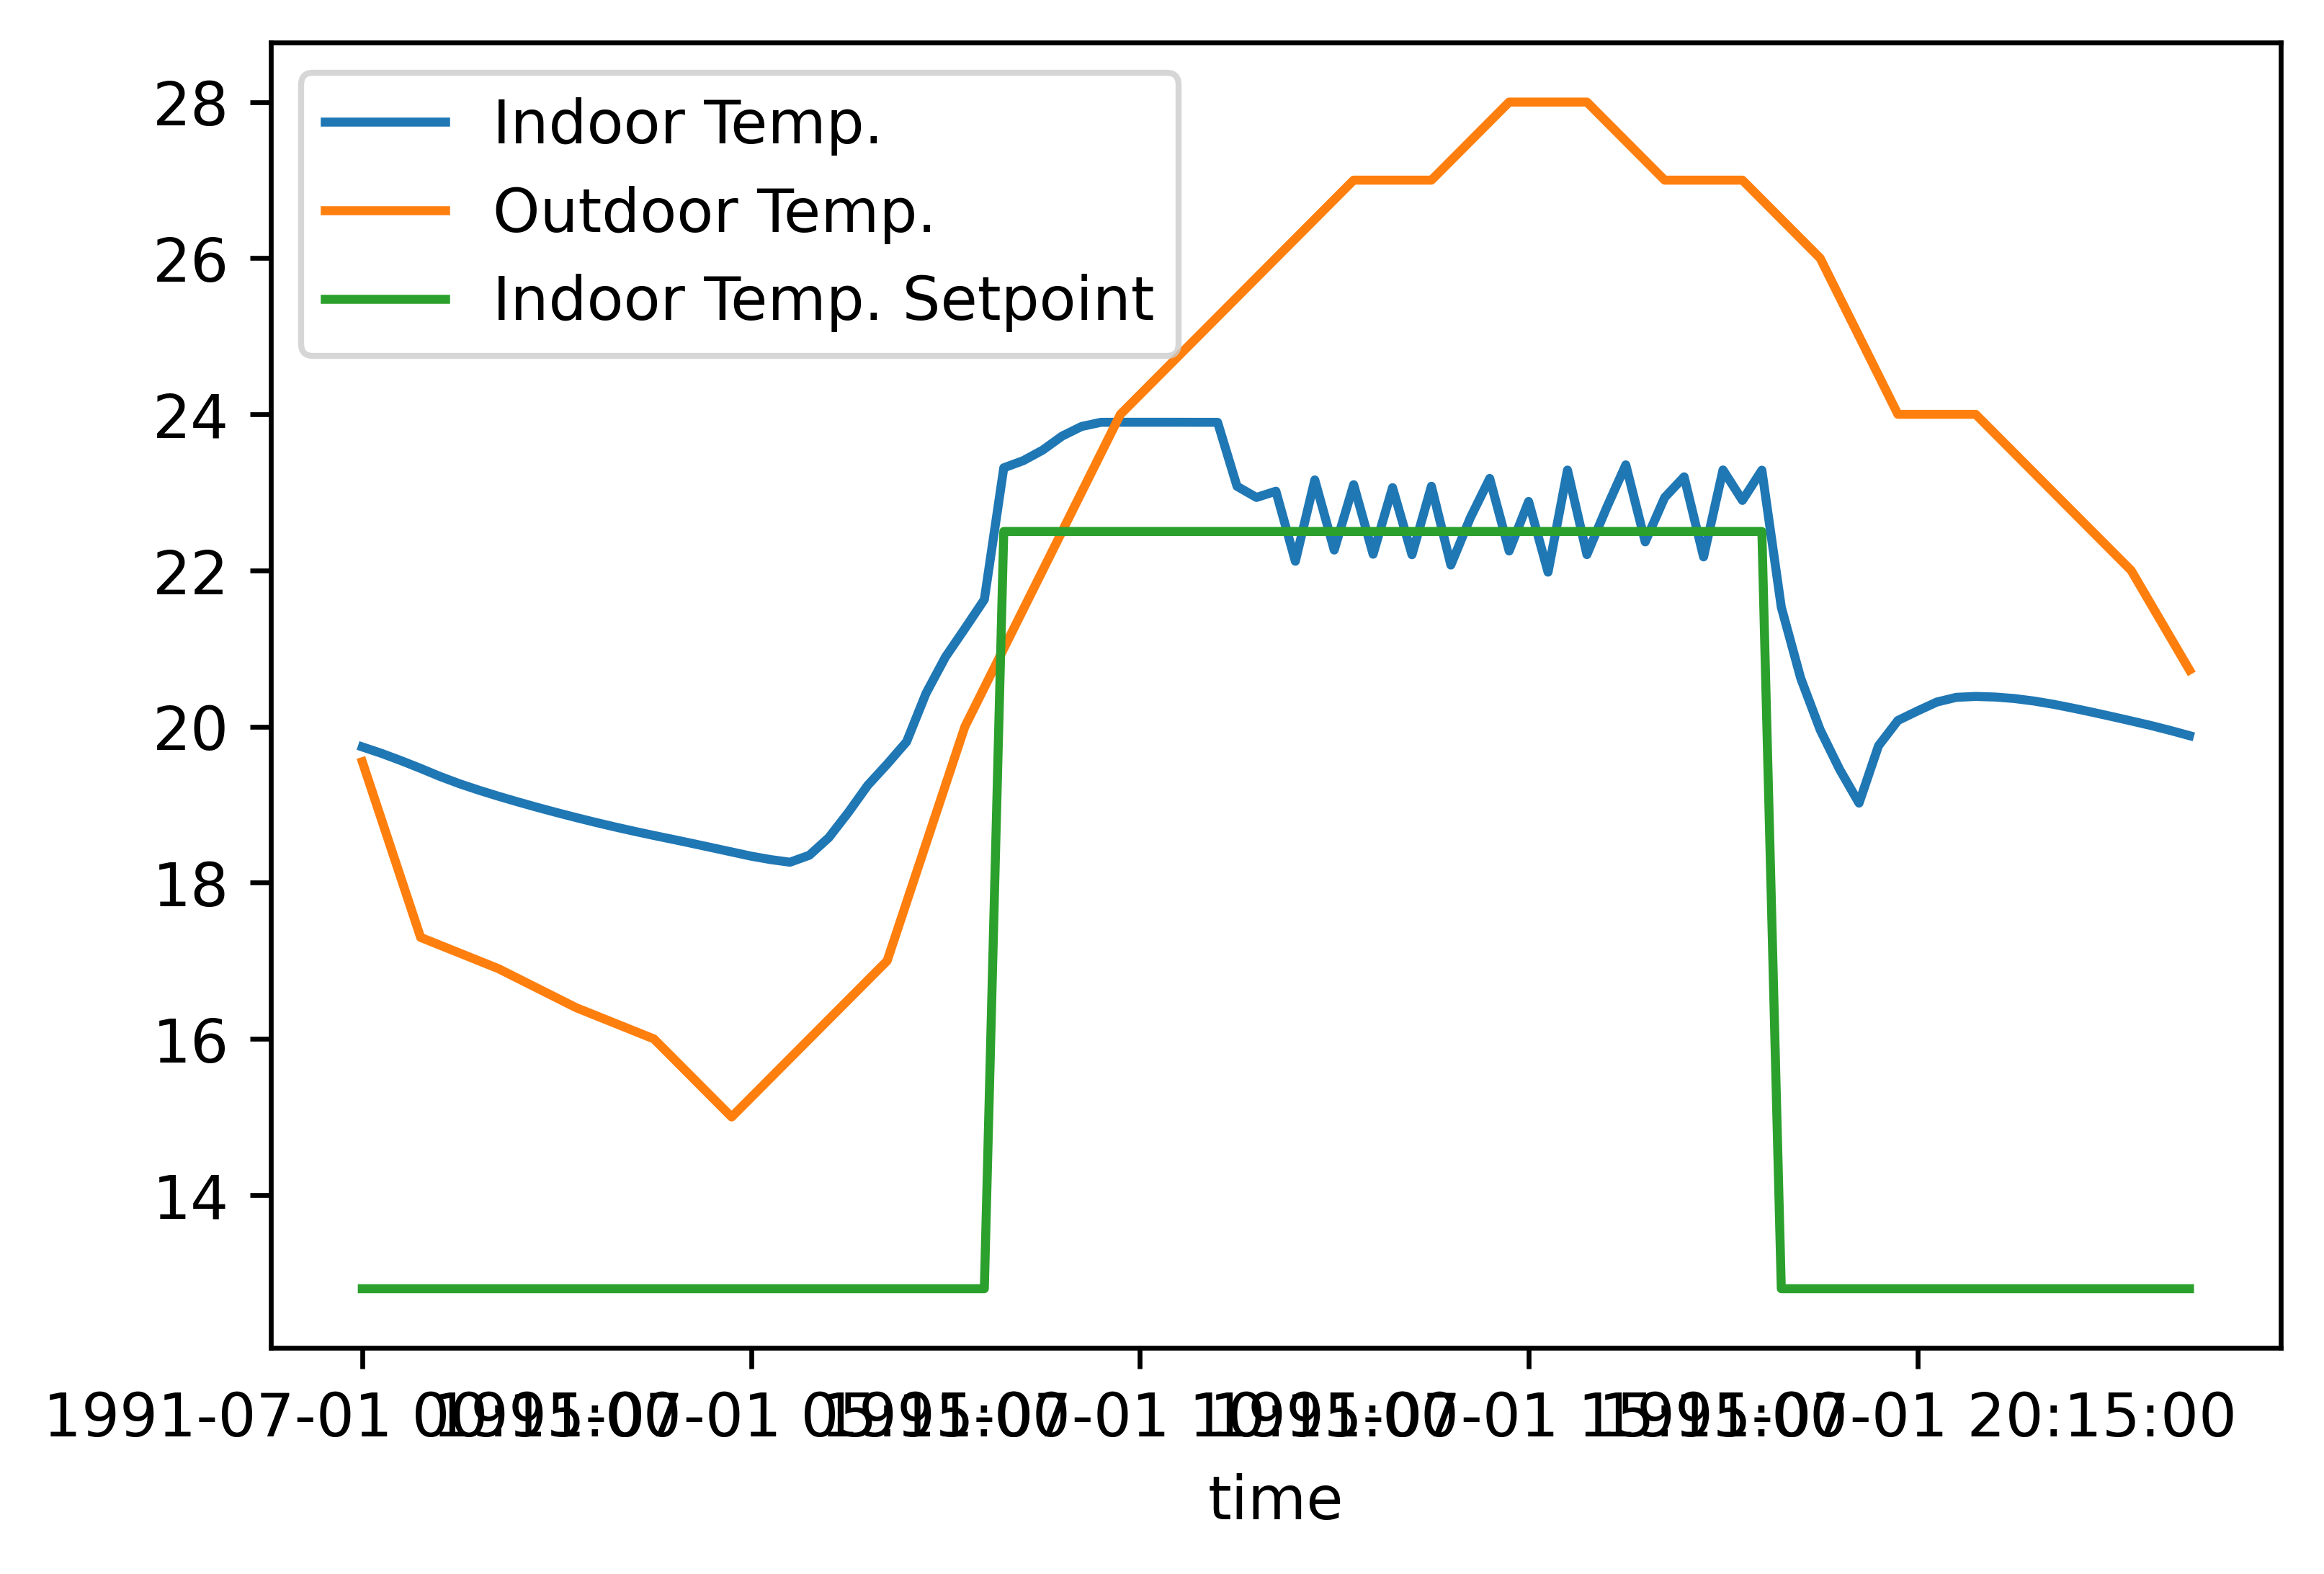

In [20]:
df["1991-07-01":"1991-07-02"].plot(y=["Indoor Temp.", 'Outdoor Temp.', 'Indoor Temp. Setpoint'])

In [13]:
df["1991-07-01":"1991-07-02"]['Indoor Temp. Setpoint'].unique()

array([12.8, 22.5])

In [4]:
df = pd.read_csv("baselines/SAT_SP_customOcc_cooling_blindsAllAlwaysOn_setpoint0_daylightingTrue.csv", index_col="time")

In [6]:
df["1991-07-01 00:30:00":"1991-08-02 00:00:00"]

Outdoor Temp.  Diff. Solar Rad.  Direct Solar Rad.  \
time                                                                      
1991-07-01 00:30:00          18.80               0.0                0.0   
1991-07-01 00:45:00          18.05               0.0                0.0   
1991-07-01 01:00:00          17.30               0.0                0.0   
1991-07-01 01:15:00          17.20               0.0                0.0   
1991-07-01 01:30:00          17.10               0.0                0.0   
...                            ...               ...                ...   
1991-08-01 23:00:00          23.80               0.0                0.0   
1991-08-01 23:15:00          23.80               0.0                0.0   
1991-08-01 23:30:00          23.80               0.0                0.0   
1991-08-01 23:45:00          23.80               0.0                0.0   
1991-08-02 00:00:00          23.80               0.0                0.0   

                     HVAC Power  Sys Out Temp.  Heat Coil Power  \
time                                                              
1991-07-01 00:30:00  975.483535      24.436467              0.0   
1991-07-01 00:45:00  975.483535      24.200097              0.0   
1991-07-01 01:00:00  975.483535      23.956838              0.0   
1991-07-01 01:15:00  975.483535      23.675837              0.0   
1991-07-01 01:30:00  975.483535      23.499708              0.0   
...                         ...            ...              ...   
1991-08-01 23:00:00  975.483535      25.823823              0.0   
1991-08-01 23:15:00  975.483535      25.707993              0.0   
1991-08-01 23:30:00  975.483535      25.634573              0.0   
1991-08-01 23:45:00  975.483535      25.558879              0.0   
1991-08-02 00:00:00  975.483535      25.485243              0.0   

                     Cool Coil Power   MA Temp.  In Node Temp Zone 1  \
time                                                                   
1991-07-01 00:30:00              0.0  23.839192            24.436467   
1991-07-01 00:45:00              0.0  23.602840            24.200097   
1991-07-01 01:00:00              0.0  23.359593            23.956838   
1991-07-01 01:15:00              0.0  23.078594            23.675837   
1991-07-01 01:30:00              0.0  22.902502            23.499708   
...                              ...        ...                  ...   
1991-08-01 23:00:00              0.0  25.228643            25.823823   
1991-08-01 23:15:00              0.0  25.112839            25.707993   
1991-08-01 23:30:00              0.0  25.039473            25.634573   
1991-08-01 23:45:00              0.0  24.963837            25.558879   
1991-08-02 00:00:00              0.0  24.890270            25.485243   

                     In Node Temp Zone 2  ...  Blind Angle Zone 4  \
time                                      ...                       
1991-07-01 00:30:00            24.436467  ...            2.902293   
1991-07-01 00:45:00            24.200097  ...            2.902293   
1991-07-01 01:00:00            23.956838  ...            2.902293   
1991-07-01 01:15:00            23.675837  ...            2.902293   
1991-07-01 01:30:00            23.499708  ...            2.902293   
...                                  ...  ...                 ...   
1991-08-01 23:00:00            25.823823  ...            2.902293   
1991-08-01 23:15:00            25.707993  ...            2.902293   
1991-08-01 23:30:00            25.634573  ...            2.902293   
1991-08-01 23:45:00            25.558879  ...            2.902293   
1991-08-02 00:00:00            25.485243  ...            2.902293   

                     Blind Angle Zone 2  Blind Angle Zone 3  Illum 1 Zone 1  \
time                                                                          
1991-07-01 00:30:00            2.902293            2.902293             0.0   
1991-07-01 00:45:00            2.902293            2.902293             0.0   
1991-07-01 01:00:00   